In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import openpyxl
import re
import os
from variableUtils import *
import variableUtils
from Utils import *
from ClassUtils import *
from pprint import pprint
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from reportlab.lib.pagesizes import letter, landscape, A4, A3
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, PageBreak, Paragraph, Spacer, Image
from reportlab.lib import colors
from reportlab.platypus import Paragraph, Spacer, KeepTogether, KeepInFrame
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
import io
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from openpyxl.formatting.rule import FormulaRule
import PIL

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(sns.__version__)


## BOH3 and DDS4 Qualtrics

In [ ]:
workbookpath = '2025\BOH3+DDS4\Session 4\\2025 BOH3 and DDS4 CAF.xlsx'
# workbookpath = '2025\BOH3+DDS4\\2025 BOH3 and DDS4.xlsx'
def getStudentList(listpath, cohort='BOH3'):
    listdf = pd.read_excel(listpath, keep_default_na=False, na_values=[''])
    if cohort is not None:
        listdf = listdf[listdf['Cohort'] == cohort]
    validIds = listdf['Student ID'].to_list()
    # convert to int
    validIds = [int(id) for id in validIds]
    print(f"Number of valid student IDs in {cohort}: {len(validIds)}")
    return validIds
validIds = getStudentList('2025\RE_ Student List.xlsx', cohort=None)
folder, file, ext = getFolderandFileName(workbookpath)
df = pd.read_excel(workbookpath, keep_default_na=False, na_values=[''])  # This will keep 'NA' text as it is
# turn evey column to lowercase
df.columns = df.columns.str.lower()
# strip all columns
df.columns = df.columns.str.strip()
# remove non-ascii characters
df.columns = df.columns.str.replace(r'[^\x00-\x7F]+', '', regex=True)
df.loc[0] = df.loc[0].str.replace(r'[^\x00-\x7F]+', '', regex=True)
supervisorcol = [col for col in df.columns if 'evaluation#2' in col.lower()]
studentcol = [col for col in df.columns if 'evaluation#1' in col.lower()]
# display(df[supervisorcol[3]].value_counts(dropna=False))
fullnamedict = {col: df.loc[0, col] for col in df.columns}
row0 = df.loc[0]
# row0 = row0.str.replace(r'[^\x00-\x7F]+', '', regex=True)
df.drop(0, inplace=True)
# df['finished'] = df['finished'].astype(bool)
df = df[(df['finished'] == True) | (df['finished'] == 'TRUE') | (df['finished'] == 'true') | (df['finished'] == 'True')]

df['rotation'] = pd.to_numeric(df['rotation'], errors='coerce')
df['rotation'] = df['rotation'].astype('Int64')
# df = df[df['rotation'] == 3]
colAge = [col for col in df.columns if '#2_1_1' in col]
colPtInfo = [col for col in df.columns if re.match(r'pt\.\s*\d+', col)]
def getAgeGroup(age):
    if age <= 6:
        return '0-6'
    elif age <= 17:
        return '7-17'
    elif age >= 18 and age<140:
        return '18+'
    else:
        return np.nan
    
for col in colAge:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # replace all values that are not numbers with np.nan
    # df[col] = df[col].apply(lambda x: x if isinstance(x, (int, float)) else np.nan)
colAgeNew = []
for col in colAge:
    df[f'{col} group'] = df[col].apply(getAgeGroup)
    colAgeNew.append(f'{col} group')

# display(df[df[colId.lower()]==1452727][colAge])
colCode = [col for col in df.columns if 'code' in col.lower()]
colCodeNew = []
for col in colCode:
    df[col] = df[col].astype(str)
    df[f'{col} list'] = df[col].apply(lambda x: [f'0{item}' if item.isdigit() and len(item) == 2 else item for item in re.split(r',\s*', x)])  # Handles optional spaces after commas and adds 0 before two-digit items
    colCodeNew.append(f'{col} list')
# display(df)

for col in colCodeNew:
    df[col] = df[col].apply(cleanEntry)

# print(colAge)
# display(df.loc[0, colAge])
colCohort = 'cohort'

# display(dfboh3.head())

colNPts = 'No. of pts'
colId = 'student id'
colOprStuFeedback = 'student reflection'
colCI = 'Clinical Incident'
colCIExp = 'CI Explanation'
colRotation = 'Rotation'
colPriority = [col for col in df.columns if 'priority' in col.lower()]
colDate = 'date'
# filter out valid student IDs
df = df[df[colId].isin(validIds)]
originalDates = df[colDate].copy()

# Try parsing with coercion
df[colDate] = pd.to_datetime(df[colDate], errors='ignore', format='mixed')

# Find the actual problematic original dates
invalidDateValues = originalDates[df[colDate].isna()].unique()

print(f"Invalid date values: {invalidDateValues}")
df[colDate] = df[colDate].dt.strftime('%d %b %Y')
display(df[colDate].value_counts(dropna=False))
# patient info columns are with Pt.\d+ in the column name

# print(colPtInfo)
importantCols =  ['SO Feedback',	'SO Edu Feedback',	'SO Edu Name', 'Obs Feedback',	'Obs Edu Feedback', 'Obs Edu Name']
columnList = [
    "Student Reflection",
    "Edu Feedback",
    "Entrustment",
    "Clinical Incident",
    "CI Explanation",
    "Edu Name"
]
importantCols.extend(columnList)
print(fullnamedict)
print(df['finished'].value_counts(dropna=False))
dfboh3 = df[df[colCohort]=='BOH3']
dfdds4 = df[df[colCohort]=='DDS4']
print(folder)
# dfboh3[dfboh3[colId]==1462377]

### Create age report

In [ ]:
def getNPatients(text):
    # print(text)
    if pd.isna(text):
        return 0
    # select the number of patients from the text, select the highest number Patient 1, Patient 2, Patient 3 etc.
    numbers = re.findall(r'\d+', text)
    if len(numbers) == 0 and 'fta' in text.lower():
        return 'Patient FTA'
    # get the highest number
    if len(numbers):
        return max([int(num) for num in numbers])
    else:
        return 0
    
def createGeneralReport(df, cohort, savefolder):
    idCounts = df[colId].value_counts()
    ids = idCounts.index
    elements = []
    patientCountDf = pd.DataFrame(columns=['Student ID', 'Student Name', '# Patients', 'Patient Ages',
                                           '#18+', '#7-17', '#0-6', 'Clinic'])
    evalDf = pd.DataFrame(columns=['Student ID', 'Student Name', '# Yes', '# No', '# N/A', " No%"])
    
    for id in ids:
        studentDf = df[df[colId] == id]
        studentName = studentDf['given name'].values[0] + ' ' + studentDf['family name'].values[0]
        studentDf['Patient Count'] = studentDf[colNPts.lower()].apply(getNPatients)
        # get fta count
        studentDf['Patient Count'] = studentDf['Patient Count'].replace('Patient FTA', 0).astype(int)
        patientCount = studentDf['Patient Count'].sum()
        ageList = []
        for col in colAge:
            studentDf[col] = studentDf[col].astype(float)
            ageList.extend(studentDf[col].dropna().to_list())
        ageList.sort()
        n18plus = len([age for age in ageList if age >= 18])
        n7to17 = len([age for age in ageList if age >= 7 and age < 18])
        n0to6 = len([age for age in ageList if age >= 0 and age < 7])
        clinic = studentDf['clinic'].values[0]
        patientCountDf = pd.concat([patientCountDf, pd.DataFrame({'Student ID': [id], 'Student Name': [studentName], '# Patients': [patientCount],
             "Patient Ages": [ageList], '#18+': [n18plus], '#7-17': [n7to17], '#0-6': [n0to6], 'Clinic': [clinic]})])
    
        # get the evaluation counts for supervisorcol
        nYes = 0
        nNo = 0
        nNA = 0
        
        for col in supervisorcol:
            nYes += studentDf[col].str.contains('Yes').sum()
            nNo += studentDf[col].str.contains('No').sum()
            nNA += studentDf[col].str.contains('NA').sum()
        nopercent = nNo / (nYes + nNo + nNA + 0.001) * 100
        evalDf = pd.concat([evalDf, pd.DataFrame({'Student ID': [id], 'Student Name': [studentName],
                                                  '# Yes': [nYes], '# No': [nNo], '# N/A': [nNA], ' No%': [nopercent]})])
    
    evalDf.sort_values(by=[' No%', '# Yes'], ascending=[True, False], inplace=True)
    
    # Create a stacked plot of evaluation counts with student id as x axis
    fig, ax = plt.subplots(figsize=(figSize[0], figSize[1]))
    evalDf.set_index('Student ID')[['# Yes', '# No', '# N/A']].iloc[::-1].plot(kind='barh', stacked=True, ax=ax, width=0.8)
    ax.set_xlabel('Count')
    ax.set_ylabel('Student ID')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    img = addPlotImage(fig, 0.9)
    
    elements.append(Paragraph(f'Performance Overview for {cohort}', subsubheadingStyle))
    elements.append(Spacer(1, 12))
    elements.append(img)
    elements.append(Spacer(1, 6))
    elements.append(Paragraph("The students at the bottom are with highest % of No Responses", tableTextStyle))
    
    # Create a table for patientCountDf with bar graphs in the Patient Ages column
    table_data = [['Student ID', 'Student Name', '# Patients', 'Patient Ages', 'Age count', 'Clinic']]
    patientCountDf.sort_values(by='# Patients', ascending=False, inplace=True)
    

    unique_clinics = patientCountDf['Clinic'].unique()
    print(unique_clinics)
    clinic_colors = {clinic: color for clinic, color in zip(unique_clinics, sns.color_palette("husl", len(unique_clinics)))}
    
    for i, row in patientCountDf.iterrows():
        # Create a tiny bar graph for the Patient Ages column
        fig, ax = plt.subplots(figsize=(2, 0.5))
        sns.histplot(row['Patient Ages'], bins=[i for i in range(0, 100, 6)], ax=ax)
        ax.yaxis.set_visible(False)
        ax.xaxis.set_visible(False)
        ax.axvline(x=6.5, color='black', linestyle='dotted')
        ax.axvline(x=18, color='black', linestyle='dotted')
        plt.tight_layout()
        imgdata = io.BytesIO()
        fig.savefig(imgdata, format='png', bbox_inches='tight')
        plt.close(fig)
        imgdata.seek(0)
        img = Image(imgdata, width=4 * inch, height=1 * inch)
        agedict = {'18+': row['#18+'], '7-17': row['#7-17'], '0-6': row['#0-6']}
        agetext = '<br/>'.join([f'{key}: {value}' for key, value in agedict.items()])
        clinic_ = row['Clinic'] if not pd.isna(row['Clinic']) else ''
        table_data.append([row['Student ID'], Paragraph(row['Student Name'], tableTextStyle),
                           row['# Patients'], img, Paragraph(agetext, tableTextStyle), Paragraph(clinic_, tableTextStyle)])
        
    table = Table(table_data, colWidths=[1.2 * inch, 1.5 * inch, 1 * inch, 4 * inch, 1.2 * inch, 1.2 * inch])
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, -1), 0.2 * inch),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 12),
        ('BOTTOMPADDING', (3, 1), (3, -1), 0),  
        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    
    # for i, row in enumerate(patientCountDf.iterrows(), start=1):
    #     clinic = row[1]['Clinic']
    #     if clinic in clinic_colors:
    #         table.setStyle(TableStyle([
    #             ('BACKGROUND', (0, i), (-1, i), clinic_colors[clinic])
    #         ]))
    elements.append(PageBreak())
    elements.append(Paragraph(f'Patient Count and Age Distribution for {cohort}', subsubheadingStyle))
    elements.append(Spacer(1, 12))
    text = f"""
The table shows ages of patients with patient count and age group distribution, but all information
                              regarding patient ages was not filled appropriately. Thus, the age distribution is not accurate for
                              all students.The dotted lines in the graphs indicate the age groups 0-6 and 7-17.
    """
    text2 = f"""Average Patient count is {round(patientCountDf['# Patients'].mean(), -1)} per student. """
    text3 = f"""The highest number of patients seen by a student is {patientCountDf['# Patients'].max()}."""
    text4 = f"""The lowest number of patients seen by a student is {patientCountDf['# Patients'].min()}.""" 
    text5 = "Data is not very accurate due to missing fields in the forms but should be close."
    elements.append(Paragraph(text, tableTextStyle))
    elements.append(Spacer(1, 6))
    elements.append(Paragraph(text2, tableTextStyle))
    elements.append(Spacer(1, 6))
    elements.append(Paragraph(text3, tableTextStyle))
    elements.append(Spacer(1, 6))
    elements.append(Paragraph(text4, tableTextStyle))
    elements.append(Spacer(1, 6))
    elements.append(Paragraph(text5, tableTextStyle))
    elements.append(Spacer(1, 12))

    # elements.append(Paragraph('Clinic Colors Legend', subsubheadingStyle))
    # elements.append(Spacer(1, 12))
    # elements.append(legend_table)
    # elements.append(Spacer(1, 12))

    elements.append(table)
    
    # doc.build(elements)
    # display(patientCountDf)
    # display(evalDf)
    return elements
# savefolder = f'{folder}'
# createGeneralReport(dfboh3, 'BOH3', savefolder)

In [ ]:
def createfronttable(df: pd.DataFrame, title = 'Front Page Summary', type_=None):
    nforms = len(df)
    # age range  dictionary
    ageDict = df[colAgeNew].apply(pd.Series.value_counts).to_dict()
    result = {}
    for group in ageDict.values():
        for key, value in group.items():
            result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    ageDict = result
    print(ageDict)
    # total patients
    df['num patients'] = df[colNPts.lower()].apply(getNPatients) 
    df['num patients'] = df['num patients'].astype(str)
    # display(df[[colId.lower(),'num patients', colNPts.lower()]])
    # get fta count
    fta = df[df['num patients'] == 'Patient FTA'].shape[0]
    print(f'\n\nNumber of FTA: {fta}\n\n')
    df['num patients'] = df['num patients'].replace('Patient FTA', 0).astype(int)
    # get total patients seen by each student
    studentpatients = df.groupby(colId)['num patients'].sum().to_dict()
    print(studentpatients)
    # filter out max and min values
    if studentpatients:
        maxPatients = max(studentpatients.values())
        minPatients = min(studentpatients.values())
    else:
        maxPatients = minPatients = 0
    print(minPatients, maxPatients)
    # get num patients for each clinic
    clinicPatients = df.groupby('clinic')['num patients'].sum().to_dict()
    clinicPatietnsText = "<br/>".join([f"{key}: {value}" for key, value in clinicPatients.items()])
    totalPatients = df['num patients'].sum()
    print(totalPatients)
    # average patient per student
    dfoperators = df[df[colRole.lower()] == 'Operator']
    noperators = len(dfoperators)
    noperatorstudents = len(dfoperators[colId].unique())
    nstudents = len(df[colId].unique())
    avgPatients = totalPatients / (noperatorstudents + 0.00001)
    # average patient per form
    avgPatientsForm = totalPatients / noperators
    print(avgPatients)
    print(avgPatientsForm)

    # priority counts
    priorityDict = df[colPriority].apply(pd.Series.value_counts).to_dict()
    result = {}
    for group in priorityDict.values():
        for key, value in group.items():
            # if , then split the key and add the value to the key
            if ',' in key:
                keys = key.split(',')
                for key in keys:
                    result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
            else:
                result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    priorityDict = result
    print(priorityDict)
    
    # item codes count
    itemCodeList = []
    for col in colCodeNew:
        itemCodeList.extend(df[col].to_list())
    itemCodeList = [item for sublist in itemCodeList for item in sublist]
    itemCodeDict = {item: itemCodeList.count(item) for item in set(itemCodeList)}
    
    # remove nan
    itemCodeDict.pop('nan', None)
    print(itemCodeDict)
    # get top 5 item codes
    top5ItemCodes = dict(sorted(itemCodeDict.items(), key=lambda x: x[1], reverse=True)[:5])
    print(top5ItemCodes)
    # entrustment counts
    # entrustmentCounts = df['entrustment'].value_counts().to_dict()
    # split the keys with :
    # entrustmentCounts = {key.split(':')[0]: value for key, value in entrustmentCounts.items()}
    # print(entrustmentCounts)
    # entrustmentText = "<br/>".join([f"{key}: {value}" for key, value in entrustmentCounts.items()])
    # extract number Lvl \d+ from entrustment
    df['entrustment lvl'] = df['entrustment'].astype(str).str.extract(r'Lvl (\d+)').fillna(0)
    df['entrustment lvl'] = df['entrustment lvl'].astype(int)
    entrustmentCounts = df['entrustment lvl'].value_counts().to_dict()
    # remove 0 key
    entrustmentCounts.pop(0, None)
    entrustmentText = "<br/>".join([f"{key}: {value}" for key, value in entrustmentCounts.items()])
    print(entrustmentText)
    # yes/no/na counts
    df['nYesStudent'] = df[studentcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
    df['nNoStudent'] = df[studentcol].apply(lambda x: (x == 'No').sum(), axis=1)
    df['nNAStudent'] = df[studentcol].apply(lambda x: (x == 'NA').sum(), axis=1)
    df['scoreStu'] = df['nYesStudent']/(df['nYesStudent'] + df['nNoStudent'] + 0.0001)
    df['nYesSupervisor'] = df[supervisorcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
    df['nNoSupervisor'] = df[supervisorcol].apply(lambda x: (x == 'No').sum(), axis=1)
    df['nNASupervisor'] = df[supervisorcol].apply(lambda x: (x == 'NA').sum(), axis=1)
    df['scoreSup'] = df['nYesSupervisor']/(df['nYesSupervisor'] + df['nNoSupervisor'] + 0.0001)
    df['scorediff'] = df['scoreStu'] - df['scoreSup']
    scorediffavg = df['scorediff'].mean()
    # filter out df with entrustment non zero
    dfentrustment = df[df['entrustment lvl'] > 0]
    # dfentrustment.to_excel(f'{folder}\\entrustment.xlsx')
    # correlation between entrustment and score supervisor
    entrustmentCorr = dfentrustment['entrustment lvl'].corr(dfentrustment['scoreSup'])
    print(entrustmentCorr)
    # get column wise Yes/No/NA counts for supervisorcols
    dfcolumnwise = pd.DataFrame(index=supervisorcol, columns=['key', 'Question','Yes', 'No', 'NA'])
    for col in supervisorcol:
        dfcolumnwise.loc[col, 'Yes'] = df[col].str.contains('Yes').sum()
        dfcolumnwise.loc[col, 'No'] = df[col].str.contains('No').sum()
        dfcolumnwise.loc[col, 'NA'] = df[col].str.contains('NA').sum()
        dfcolumnwise.loc[col, 'Question'] = fullnamedict[col].split(' - ')[-1].split('\n')[-1]
        dfcolumnwise.loc[col, 'key'] = fullnamedict[col].split(' - ')[-1].split('\n')[0]
    dfcolumnwise['score'] = dfcolumnwise['Yes']/(dfcolumnwise['Yes'] + dfcolumnwise['No'] + 0.0001)
    dfcolumnwise.sort_values(by='score', ascending=False, inplace=True)
    bestQuestion = dfcolumnwise.loc[dfcolumnwise.index[0], 'key']
    best3Questions = dfcolumnwise.loc[dfcolumnwise.index[:2], 'key']

    worstQuestion = dfcolumnwise.loc[dfcolumnwise.index[-1], 'key']
    worst3Questions = dfcolumnwise.loc[dfcolumnwise.index[-3:], 'key']

    # get role wise counts
    roleDict = df[colRole.lower()].value_counts().to_dict()
    result = {}
    for key, value in roleDict.items():
            if ',' in key:
                keys = key.split(',')
                for key in keys:
                    result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
            else:
                result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    dfrole = result
    roltext = "<br/>".join([f"{key}: {value}" for key, value in dfrole.items()])
    # display(dfcolumnwise)
    
    ageOrder = ["0-6", "7-17", "18+"]

    # Convert ageDict to formatted text in the specified order
    agetext = "<br/>".join([f"{key}: {int(ageDict[key])}" for key in ageOrder if key in ageDict])
    prioritytext = "<br/>".join([f"{key.split('Group ')[-1]}: {int(priorityDict[key])}" for key in priorityDict])
    # create a table for the front page
    dfFront = pd.DataFrame([
    ['Total number of forms submitted', nforms],
    ['Role Distribution', roltext],
    ['Age Range Counts', agetext],
    ['Total number of patients managed by students', totalPatients],
    ['Average number of patients managed per student (min - max)', f'{int(avgPatients) if not pd.isna(avgPatients) else "NaN"}   ({minPatients} - {maxPatients})'],
    # ['Number of forms receiving entrustment level 3 or 4', (df['entrustment lvl'] >= 3).sum()],
    # ['Number of forms receiving entrustment level 2', (df['entrustment lvl'] == 2).sum()],
    # ['Number of forms receiving entrustment level 1', (df['entrustment lvl'] == 1).sum()],
    ['Entrustment Distribution', entrustmentText],
    ['Correlation between entrustment and supervisor score(0-1)<br/>(Higher correlation implies supervisor are giving entrustment scores based on objective checklist scores and have less latent bias, should be 0.2+ <br/>*Not valid for small number of students)', round(entrustmentCorr, 2)],
    ['Difference in student and supervisor ratings (avg)', round(scorediffavg,3)],
    ['Top 5 Item Codes', ', '.join(top5ItemCodes.keys())],  
    ['Priority Group', prioritytext],
    ['Areas students are performing well in', ", ".join(best3Questions)],
    ['Areas that need improvement', ", ".join(worst3Questions)],
    ['Number of FTAs', fta],
    ['Clinic Patient Counts', clinicPatietnsText]
], columns=['Metric', 'Value'])
    if type_ == 'clinic': # remove last row
        dfFront = dfFront.iloc[:-1]
    # # Adding Age Range
    # for key, value in ageDict.items():
    #     dfFront.loc[len(dfFront)] = [f'Age range {key}', value]

    # Adding Priority Group Counts
    # for key, value in priorityDict.items():
    #     dfFront.loc[len(dfFront)] = [f'Priority Group {key}', int(value)]

    # Adding Top 5 Item Codes
    # for key, value in top5ItemCodes.items():
    #     dfFront.loc[len(dfFront)] = [f'Item Code {key}', value]
    # display(dfFront)
    # dfFront.to_excel(f'{folder}\\frontpage.xlsx')
    dfFrontTable = createTable(dfFront, title, colRatio=[3,2], customTextCols=[0, 1], tableTextStyle=tableTextStyleSmall)
    # table is 2nd last item of keepTogether dfFrontTable
    table = dfFrontTable._content[2]
    # change top and bottom padding of the table
    padding = 10
    if type_ == 'clinic':
        padding = 6
    table.setStyle(TableStyle([
        ('TOPPADDING', (0, 0), (-1, -1), padding),
        ('BOTTOMPADDING', (0, 0), (-1, -1), padding),
    ]))
    # get all the contents of dfFrontTable
    # for content in dfFrontTable._content:
    #     print(content)
    # change text of 3rd row and 2nd column to age paragraph
    numRows = len(table._cellvalues)  # Number of rows
    numCols = len(table._cellvalues[0]) if numRows > 0 else 0  # Number of columns

    print(f"Rows: {numRows}, Columns: {numCols}")
    # table._cellvalues[2][1] = ageparagraph
    # add number of students for each rotation
    # Add a separate row for each rotation with the number of unique students
    rotations = df[colRotation.lower()].unique()
    for rotation in rotations:
        n_students = df[df[colRotation.lower()] == rotation][colId.lower()].nunique()
        dfFront.loc[len(dfFront)] = [f'Number of students in rotation {rotation}', n_students]
    # get item counts for each item code for each rotation

    # # for each rotation, get the item codes and their counts
    # for rotation in rotations:
    #     dfrotation = df[df[colRotation.lower()] == rotation]
    #     itemCodeList = []
    #     for col in colCodeNew:
    #         itemCodeList.extend(dfrotation[col].to_list())
    #     itemCodeList = [item for sublist in itemCodeList for item in sublist]
    #     itemCodeDict = {item: itemCodeList.count(item) for item in set(itemCodeList)}
    #     # remove nan and zero counts
    #     itemCodeDict = {key: value for key, value in itemCodeDict.items() if key != 'nan' and value > 0}
    #     # divide the values by the number of students in the rotation
    #     n_students = dfrotation[colId.lower()].nunique()
    #     itemCodeDict = {key: value / n_students for key, value in itemCodeDict.items()}
    #     for item, count in itemCodeDict.items():
    #         dfFront.loc[len(dfFront)] = [f'Rotation {rotation} Avg. # {item}', count]

    itemCodeList = []
    for col in colCodeNew:
        itemCodeList.extend(df[col].to_list())
    itemCodeList = [item for sublist in itemCodeList for item in sublist]
    itemCodeDict = {item: itemCodeList.count(item) for item in set(itemCodeList)}
    # remove nan and zero counts
    itemCodeDict = {key: value for key, value in itemCodeDict.items() if key != 'nan' and value > 0}
    n_students = df[colId.lower()].nunique()
    for item, count in itemCodeDict.items():
        dfFront.loc[len(dfFront)] = [f'# Avg. Item Code {item}', round(count/ n_students,2)]

    # in dfFront replace the <br/> with \n in all the cells
    for i in range(len(dfFront)):
        for j in range(len(dfFront.iloc[i])):
            if isinstance(dfFront.iloc[i, j], str):
                dfFront.iloc[i, j] = dfFront.iloc[i, j].replace('<br/>', '\n')
                dfFront.iloc[i, j] = dfFront.iloc[i, j].replace('<br>', '\n')
                dfFront.iloc[i, j] = dfFront.iloc[i, j].replace('<br />', '\n')
                dfFront.iloc[i, j] = dfFront.iloc[i, j].replace('<br />', '\n')
    return dfFrontTable, dfFront
# createfronttable(df)

In [ ]:
# get the ages from all the columns
def plotages(df, title):
    ages = []
    for col in colAge:
        ages.extend(df[col].to_list())
    
    # remove nan
    ages = [age for age in ages if not np.isnan(age)]
    # print(ages)
    fig, ax = plt.subplots(figsize=(figSize[0], figSize[1]*0.8))
    sns.histplot(ages, bins=[i for i in range(0, 100, 10)], ax=ax)
    # show total number of ages
    total = len(ages)
    plt.text(0.90, 0.90, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title(title)
    plt.xlabel('Age')
    return fig

def plotpie(df, title):
    # plot pie chart of counts of Role column
    fig, ax = plt.subplots(figsize=figSize)
    total = len(df)
    rolecountDict = df[colRole.lower()].value_counts().to_dict()
    result = {}
    for key, value in rolecountDict.items():
            if ',' in key:
                keys = key.split(',')
                for key in keys:
                    result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
            else:
                result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    roleCountDf = pd.DataFrame(result.items(), columns=['Role', 'Count'])
    roleCountDf.set_index('Role', inplace=True)
    roleCountDf.plot.pie(y='Count', ax=ax, autopct=lambda x: autopct(x, total))
    # df[colRole.lower()].value_counts().plot.pie(ax=ax, autopct=lambda x: autopct(x, total))
    plt.title(title)
    plt.text(0.9, 0.9, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    return fig

def plotagegroups(df, title):
    dummydf = pd.DataFrame(columns = ['Age Group', 'Code'])
    for ageCol, codeCol in zip(colAgeNew, colCodeNew):
        dummydf = pd.concat([dummydf, df[[ageCol, codeCol]].rename(columns={ageCol: 'Age Group', codeCol: 'Code'})])
    # remove nan ages
    dummydf = dummydf[dummydf['Age Group'].notna()]
    # print(dummydf['Age Group'].unique())
    # display(dummydf.head(20))
    nsubplots = len(dummydf['Age Group'].unique())
    # create a square grid of subplots
    rows = int(np.ceil(nsubplots/2))
    cols = 2
    fig, ax = plt.subplots(nsubplots, 1, figsize=(figSize[0], figSize[1]))    
    # ax = ax.flatten()
    j=0
    for i, group in enumerate(dummydf['Age Group'].unique()):
        # remove nan entries
        # print(f'{group}: {dummydf[dummydf["Age Group"]==group].shape[0]}')
        total = dummydf[dummydf['Age Group']==group].shape[0]
        # get all the codes
        codes = []
        for j, row in dummydf[dummydf['Age Group']==group].iterrows():
            codes.extend(row['Code'])
        # remove nan
        codes = [code for code in codes if code != 'nan']
        # remove if not a number
        # codes = [code for code in codes if code.isnumeric()]
        # remove if more than 5 characters
        codes = [code for code in codes if len(code) <= 5]
        # print(codes)
        # Calculate frequency of each code
        code_counts = pd.Series(codes).value_counts(ascending=False)
        # remove counts less than 2
        if len(code_counts)>15:
            code_counts = code_counts[code_counts>=3]
        # take top 15
        code_counts = code_counts[:15]
        sns.barplot(x=code_counts.index, y=code_counts.values, ax=ax[i])
        ax[i].set_title(f'({group} years)')
        ax[i].set_xlabel('Items')
        ax[i].set_ylabel('Frequency')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, fontsize=8)
        ax[i].text(0.9, 0.9, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
        # y ticks should be integers
        ax[i].yaxis.get_major_locator().set_params(integer=True)
        ax[i].grid(linestyle='--', alpha=0.3)
    # remove the last subplot if not needed
    # if nsubplots % 2:
    #     fig.delaxes(ax[-1])
    # plt.title(f'{title} - {group}')
    # plt.xlabel('Codes')
    # increase the space between subplots
    plt.tight_layout()
    plt.suptitle(f'{title} - #Items performed by Age Group (Top 15)', fontsize=16, y=1.02)
    return fig

def plotallcodes(df, title, figsize = (figSize[0], figSize[1])):
    # plot all codes in subplots with no more than 20 bars each
    codelist = []
    for col in colCodeNew:
        codelist.extend(df[col].to_list())
    codes = [code for sublist in codelist for code in sublist]
    # remove nan
    codes = [code for code in codes if code != 'nan']
    # remove if not a number
    # codes = [code for code in codes if code.isnumeric()]
    # remove if more than 5 characters
    codes = [code for code in codes if len(code) <= 5]
    print(codes)
    # Calculate frequency of each code
    code_counts = pd.Series(codes).value_counts(ascending=False)
    # remove counts less than 2
    code_counts = code_counts[code_counts >= 2]

    # Divide into subplots with no more than 20 bars each
    num_codes = len(code_counts)
    maxbars = 20 if num_codes <=80 else 25 
    num_subplots = int(np.ceil(num_codes / maxbars))
    fig, axes = plt.subplots(num_subplots, 1, figsize=figsize)
    if num_subplots == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot

    for i, ax in enumerate(axes):
        start_idx = i * maxbars
        end_idx = start_idx + maxbars
        subset = code_counts[start_idx:end_idx]
        sns.barplot(x=subset.index, y=subset.values, ax=ax)
        # ax.text(0.9, 0.9, f'Total: {len(codes)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        for j, v in enumerate(subset.values):
            if max(subset.values) > 4:
                ax.text(j, v + 0.5, str(v), color='black', ha='center', fontsize=8)
            else:
                ax.text(j, v/2, str(v), color='black', ha='center', fontsize=8)
            
        ax.set_title(f'{title} (Part {i + 1})')
        if len(axes) == 1:
            ax.set_title(f'{title}')
        ax.set_xlabel('Items')
        ax.set_ylabel('Frequency')
        ax.set_ylim(0, max(subset.values)*1.1)  # Set y-axis limit to accommodate text
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.tight_layout()
    # plt.suptitle(f'{title} - #Items performed by Age Group (Top 15)', fontsize=16, y=1.02)
    return fig

def createcohortreport(df, cohort):

    doc = SimpleDocTemplate(f'{folder}\\{cohort} session 4 till date summary.pdf', pagesize= pageSize, leftMargin = leftMargin,
                                rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
    elements = []
    elements.append(Paragraph(f'{cohort} Summary', headingStyle))
    elements.append(Spacer(1, 24))
    frontpagetable, frontpageDf = createfronttable(df)
    # frontpageDf.to_excel(f'{folder}\\{cohort} frontpage.xlsx', index=False)
    elements.append(frontpagetable)
    elements.append(PageBreak())
    figcodecounts = plotallcodes(df, f'{cohort} - All Codes')
    imgcodecounts = addPlotImage(figcodecounts, 0.9)
    elements.append(imgcodecounts)
    elements.append(Spacer(1, 24))
    # elements.append(Spacer(1, 24))
    fig1 = plotpie(df, f'Role distribution for {cohort}')
    img1 = addPlotImage(fig1, 0.6)
    elements.append(img1)
    elements.append(Spacer(1, 24))
    fig2 = plotages(df, f'Age distribution for {cohort}')
    img2 = addPlotImage(fig2, 0.6)
    elements.append(img2)
    fig3 = plotagegroups(df, f'{cohort}')
    img3 = addPlotImage(fig3, 0.85)
    elements.append(img3)
    elements.append(PageBreak())
    # elements.extend(createGeneralReport(df, cohort, folder))
    # add a critical incident table
    CIdf = df[df[colCI.lower()] == 'Yes'][[colDate.lower(), colId.lower(), colCI.lower(), colCIExp.lower()]]
    # rename the columns from lower to original
    CIdf.rename(columns={colDate.lower(): colDate, colId.lower(): 'Student ID', colCI.lower(): colCI, colCIExp.lower(): colCIExp}, inplace=True)
    CIdf[colCIExp] = CIdf[colCIExp].replace('\n', '<br/>')
    CITable = createTable(CIdf, 'Critical Incidents', colRatio=[1, 1, 1.5, 4.5], customTextCols=[3], tableTextStyle=tableTextStyleSmall)
    # elements.append(Paragraph('Critical Incidents', subsubheadingStyle))
    elements.append(Spacer(1, 12))
    elements.append(CITable)
    elements.append(PageBreak())
    # create a table for each clinic
    clinicFrontTables = {}
    for clinic in df['clinic'].unique():
        if clinic == '' or pd.isna(clinic) or clinic == 'nan':
            continue
        dfclinic = df[df['clinic'] == clinic]
        clinicTable, dfclinic = createfronttable(dfclinic, f'{clinic} Summary', type_='clinic')
        clinicFrontTables[clinic] = dfclinic.set_index('Metric')['Value']
        # dfclinic.to_excel(f'{folder}\\{cohort} {clinic} frontpage.xlsx', index=False)
        elements.append(clinicTable)
        elements.append(Spacer(1, 24))
    dfAllClinics = pd.DataFrame(clinicFrontTables)
    dfAllClinics.to_excel(f'{folder}\\{cohort} all clinics.xlsx')
    doc.build(elements)
    # return elements
print(folder)
createcohortreport(dfboh3.copy(), 'BOH3')
createcohortreport(dfdds4.copy(), 'DDS4')

### Get simple info

In [ ]:
display(dfboh3.head(5))
# dfboh3[colDate.lower()] = pd.to_datetime(dfboh3[colDate.lower()], format = 'mixed')
# dfboh3[colDate.lower()] = dfboh3[colDate.lower()].dt.strftime('%#d %b %Y')
dfboh3['num patients'] = dfboh3[colNPts.lower()].apply(getNPatients)
dfboh3['num patients'] = dfboh3['num patients'].astype(str)
dfboh3['num patients'] = dfboh3['num patients'].replace('Patient FTA', 0).astype(int)
dfboh3['name'] = dfboh3['family name'] + ' ' + dfboh3['given name']
dfboh3['entrustment level'] = dfboh3['entrustment'].astype(str).str.extract(r'(Lvl \d+)')
dfboh3['# Yes'] = dfboh3[supervisorcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
dfboh3['# No'] = dfboh3[supervisorcol].apply(lambda x: (x == 'No').sum(), axis=1)
dfboh3['# NA'] = dfboh3[supervisorcol].apply(lambda x: (x == 'NA').sum(), axis=1)
display(dfboh3.head(5))
# get total patients seen by each student
studentpatients = dfboh3.groupby(colId)['num patients'].sum()
studentpatients = studentpatients.reset_index()
studentpatients['Student Name'] = studentpatients[colId].apply(lambda x: dfboh3[dfboh3[colId] == x]['name'].values[0])
studentpatients =studentpatients[[colId, 'Student Name', 'num patients']]
studentpatients.sort_values(by='num patients', ascending=False, inplace=True)
studentpatients.rename(columns={colId.lower(): 'Student ID', 'num patients': '# Patients'}, inplace=True)

display(studentpatients.head(5))
# colCodeNew columns are list of codes, aggregate by date in column colDate to see what codes were used on that date
dfAggCodebyDate = dfboh3.groupby([colId.lower(), colDate.lower()], as_index=False).agg({'name': 'first', **{col: 'sum' for col in colCodeNew}})
dfAggCodebyDate['All Codes'] = dfAggCodebyDate[colCodeNew].apply(lambda row: sum(row, []), axis=1)
# display(dfAggCodebyDate.head(20))
def cleanList(codeList):
    return [x for x in codeList if not (pd.isna(x) or x is np.nan or x == 'nan')]

for col in colCodeNew:
    dfAggCodebyDate[col] = dfAggCodebyDate[col].apply(cleanList)
display(dfAggCodebyDate.head(5))

# get a df of student id and number of unique dates
dfUniqueDates = dfAggCodebyDate.groupby([colId.lower()])[colDate.lower()].nunique().reset_index()
dfUniqueDates['name'] = dfUniqueDates[colId.lower()].apply(lambda x: dfboh3[dfboh3[colId] == x]['name'].values[0])
dfUniqueDates.rename(columns={colDate.lower(): 'Days Attended', colId.lower(): 'Student ID', 'name': 'Student Name'}, inplace=True)
dfUniqueDates = dfUniqueDates[['Student ID', 'Student Name', 'Days Attended']]
dfUniqueDates.sort_values(by='Days Attended', ascending=False, inplace=True)
display(dfUniqueDates.head(5))
nStudents = dfboh3[colId.lower()].nunique()
print(f'Number of students: {nStudents}')

# get entrustment counts
entrustmentCounts = dfboh3['entrustment'].value_counts().to_dict()
display(entrustmentCounts)

# get Critical incidents counts for each student
CIdf = dfboh3[dfboh3[colCI.lower()] == 'Yes'][[colDate.lower(), colId.lower(), colCI.lower(), colCIExp.lower()]]
CIdf.sort_values(by=[colId.lower(), colDate.lower()], inplace=True)
# aggregate by student id and get counts
CIdfAgg = CIdf.groupby(colId.lower())[colCI.lower()].count().reset_index()
display(CIdf.head(25))
display(CIdfAgg.head(15))

doc = SimpleDocTemplate(f'{folder}\\BOH3 till session 4 basic info.pdf', pagesize= pageSize, leftMargin = leftMargin,
                            rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
elements = []
# first table of id date and all codes
dfAggCodebyDate.rename(columns={colId.lower(): 'Student ID', colDate.lower(): 'Date', 'name': 'Student Name'}, inplace=True)
dfAggCodebyDate = dfAggCodebyDate[['Student ID', 'Student Name', 'Date', 'All Codes']]
# sort codes within the list
dfAggCodebyDate['All Codes'] = dfAggCodebyDate['All Codes'].apply(lambda x: sorted(x))
# remove rows with empty codes list
# dfAggCodebyDate = dfAggCodebyDate[dfAggCodebyDate['All Codes'].astype(bool)]
dfAggCodebyDate.sort_values(by=['Student Name', 'Date'], inplace=True)
dfAggCodebyDate['All Codes Unique'] = dfAggCodebyDate['All Codes'].apply(lambda x: ', '.join(set(x)))

# entrustment level counts for each student
levelCounts = (
    dfboh3
    .groupby([colId.lower(), 'entrustment level'])
    .size()
    .unstack(fill_value=0)  # Make levels into columns, missing levels = 0
)
levelCounts.reset_index(inplace=True)
levelCounts.rename(columns={colId.lower(): 'Student ID'}, inplace=True)
levelCounts['Student Name'] = levelCounts['Student ID'].apply(lambda x: dfboh3[dfboh3[colId] == x]['name'].values[0])
levelCounts = levelCounts[['Student ID', 'Student Name'] + [f'Lvl {i}' for i in range(1, 5)]]
levelCounts['Lvl 1 + 2'] = levelCounts['Lvl 1'] + levelCounts['Lvl 2']
levelCounts['Lvl 3 + 4'] = levelCounts['Lvl 3'] + levelCounts['Lvl 4']
levelCounts['Total'] = levelCounts[['Lvl 1', 'Lvl 2', 'Lvl 3', 'Lvl 4']].sum(axis=1)
levelCounts.sort_values(by=['Lvl 1', 'Lvl 2'], inplace=True, ascending=False)
# add number of patients seen by each student to the table using map
levelCounts['# Patients'] = levelCounts['Student ID'].map(studentpatients.set_index('Student ID')['# Patients'])
display(levelCounts.head(5))    

# get aggregate Yes No NA counts for each student
yesNoNaCounts = (
    dfboh3
    .groupby(colId.lower())[['# Yes', '# No', '# NA']]
    .sum()
    .reset_index()
)
yesNoNaCounts.rename(columns={colId.lower(): 'Student ID', '# Yes': 'Yes', '# No': 'No', '# NA': 'NA'}, inplace=True)
yesNoNaCounts['Student Name'] = yesNoNaCounts['Student ID'].apply(lambda x: dfboh3[dfboh3[colId] == x]['name'].values[0])
yesNoNaCounts = yesNoNaCounts[['Student ID', 'Student Name', 'Yes', 'No', 'NA']]
yesNoNaCounts['Score'] = (yesNoNaCounts['Yes'] / (yesNoNaCounts['Yes'] + yesNoNaCounts['No'])).round(2)

yesNoNaCounts.sort_values(by='Score', ascending=False, inplace=True)
display(yesNoNaCounts.head(5))

# age information for patients
patientCountDf = pd.DataFrame(columns=['Student ID', 'Student Name', '# Patients',
                                           '#18+', '#7-17', '#0-6'])
for id in dfboh3[colId].unique():
    studentDf = dfboh3[dfboh3[colId] == id]
    studentName = studentDf['given name'].values[0] + ' ' + studentDf['family name'].values[0]
    studentDf['Patient Count'] = studentDf[colNPts.lower()].apply(getNPatients)
    # get fta count
    studentDf['Patient Count'] = studentDf['Patient Count'].replace('Patient FTA', 0).astype(int)
    patientCount = studentDf['Patient Count'].sum()
    ageList = []
    for col in colAge:
        studentDf[col] = studentDf[col].astype(float)
        ageList.extend(studentDf[col].dropna().to_list())
    ageList.sort()
    n18plus = len([age for age in ageList if age >= 18])
    n7to17 = len([age for age in ageList if age >= 7 and age < 18])
    n0to6 = len([age for age in ageList if age >= 0 and age < 7])
    clinic = studentDf['clinic'].values[0]
    patientCountDf = pd.concat([patientCountDf, pd.DataFrame({'Student ID': [id], 'Student Name': [studentName], '# Patients': [patientCount],
                                                               '#18+': [n18plus], '#7-17': [n7to17], '#0-6': [n0to6]})])

patientCountDf.sort_values(by='# Patients', ascending=False, inplace=True)
display(patientCountDf.head(5))
# ===========================================================================================================================================================================

# add a entrustment level counts table for each student
levelCountsTable = createTable(levelCounts[['Student ID', 'Student Name', 'Lvl 1', 'Lvl 2', 'Lvl 3', 'Lvl 4', '# Patients']], 'Entrustment Level Counts for each Student', 
                               colRatio=[1, 1, 1, 1, 1, 1, 1], customTextCols=[1], tableTextStyle=tableTextStyle, topPadding=7, bottomPadding=7)
elements.append(levelCountsTable)
elements.append(Spacer(1, 12))
overallEntrustmentCounts = dfboh3['entrustment level'].value_counts()
overallEntrustmentCounts = overallEntrustmentCounts.reset_index()
overallEntrustmentCounts.rename(columns={'index': 'Entrustment Level', 0: 'Counts'}, inplace=True)
overallEntrustmentCountsTable = createTable(overallEntrustmentCounts, 'Overall Entrustment Level Counts', colRatio=[1, 1], customTextCols=[], tableTextStyle=tableTextStyle)
elements.append(overallEntrustmentCountsTable)
elements.append(PageBreak())

# Score table for each student
yesNoNaCountsTable = createTable(yesNoNaCounts, 'MC Scores for each Student', colRatio=[1, 2, 1, 1, 1, 1], customTextCols=[], tableTextStyle=tableTextStyle)
elements.append(yesNoNaCountsTable)

# add a table for the number of critical incidents for each student
elements.append(Paragraph('Critical Incidents', subheadingStyle))
elements.append(Spacer(1, 24))
CIdfAgg.rename(columns={colId.lower(): 'Student ID', colCI.lower(): 'Critical Incidents'}, inplace=True)
CIdfAggTable = createTable(CIdfAgg, 'Critical Incident counts for each Student', colRatio=[1, 1], customTextCols=[], tableTextStyle=tableTextStyle, topPadding=6, bottomPadding=6)
elements.append(CIdfAggTable)   
elements.append(Spacer(1, 12))
CIdfTable = createTable(CIdf, 'Critical Incidents for each Student', colRatio=[1, 1, 1.5, 4.5], customTextCols=[3], tableTextStyle=tableTextStyleSmall, topPadding=6, bottomPadding=6)
elements.append(CIdfTable)
elements.append(PageBreak())

# add a table for patienta ages
patientCountTable = createTable(patientCountDf, 'Patient Age Counts for each Student', colRatio=[1, 2, 1, 1, 1, 1], customTextCols=[1], tableTextStyle=tableTextStyle)
elements.append(patientCountTable)
elements.append(PageBreak())


# add tables for each student for their codes
studentCodeCountRecords = []
for id in dfAggCodebyDate['Student ID'].unique():
    name = dfAggCodebyDate[dfAggCodebyDate['Student ID'] == id]['Student Name'].values[0]
    thisDf = dfAggCodebyDate[dfAggCodebyDate['Student ID'] == id]
    thisDf['All Codes'] = thisDf['All Codes'].apply(lambda x: ', '.join(x))
    thisDf['Date formatted'] = pd.to_datetime(thisDf['Date'], format='mixed')
    thisDf.sort_values(by='Date formatted', inplace=True)
    thisTable = createSplitTable(thisDf[['Date', 'All Codes Unique']], f'All Codes for {name} ({id})', colRatio=[1, 2], customTextCols=[1, 0], tableTextStyle=tableTextStyleSmall,
                            topPadding=5, bottomPadding=5)
    elements.append(thisTable)
    elements.append(Spacer(1, 12))

    # cumulative codes with counts
    thisDf['All Codes'] = thisDf['All Codes'].apply(lambda x: x.split(', '))
    thisDfExploded = thisDf.explode('All Codes')
    thisDfCodeCounts = thisDfExploded.groupby([ 'All Codes']).size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)
    
    # plot a bar graph of the counts
    fig, ax = plt.subplots(figsize=(figSize[0]*1, figSize[1]*0.3))
    sns.barplot(x=thisDfCodeCounts['All Codes'], y=thisDfCodeCounts['Counts'], ax=ax)
    ax.set_title(f'All Code Counts for {name} ({id})')
    ax.set_xlabel('Codes')
    ax.set_ylabel('Counts')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    total = thisDfCodeCounts['Counts'].sum()  # add a text box with the total number of codes
    ax.text(0.9, 0.9, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    for j, v in enumerate(thisDfCodeCounts['Counts']):   # show the counts on top of the bars
        ax.text(j, v + 0.5, str(v), color='black', ha='center', fontsize=8)
    ax.set_ylim(0, max(thisDfCodeCounts['Counts'])*1.1)  # Set y-axis limit to accommodate text
    img = addPlotImage(fig, 0.85)

    elements.append(img)
    studentCodeCountRecords.append({'Student ID': id, 'Student Name': name, 'Image': img})
    # thisCodeCountsTable = createTable(thisDfCodeCounts, f'All Codes for {name}({id}) - Counts', colRatio=[1, 2], customTextCols=[0], tableTextStyle=tableTextStyle)
    # elements.append(thisCodeCountsTable)
    elements.append(PageBreak())






# add a table for the number of unique dates for each student
dfUniqueDatesTable = createTable(dfUniqueDates, ' # Days attended for each Student', colRatio=[1, 1, 1], customTextCols=[], tableTextStyle=tableTextStyle)
elements.append(dfUniqueDatesTable)
elements.append(PageBreak())

# add a table for the number of patients seen by each student
studentpatientsTable = createTable(studentpatients, 'Patient Count for each Student', colRatio=[1, 1, 1], customTextCols=[], tableTextStyle=tableTextStyle)
elements.append(studentpatientsTable)
elements.append(PageBreak())

# # add a table for counts of codes for each student
# studentCodeCountRecords = pd.DataFrame(studentCodeCountRecords)
# studentCodeCountTable = createTable(studentCodeCountRecords, 'All Codes counts for each Student', colRatio=[0.9, 1.1, 6], customTextCols=[0, 1], tableTextStyle=tableTextStyleSmall)
# elements.append(studentCodeCountTable)
# elements.append(PageBreak())



doc.build(elements)

### Create student wise report

In [ ]:
def createEvalDf(row):
    evaldf = pd.DataFrame(columns = ['Key Competency', 'Marking Checklist', 'Student', 'Educator'])
    for stucol, educol in zip(studentcol, supervisorcol):
        # get common text in fullnamedict[stucol] and fullnamedict[educol]
        # commonText = 
        markingchecklist = fullnamedict[stucol].split(' Student Evaluation - ')[1]
        key = ''.join(markingchecklist.split('\n')[:-1])
        markingchecklist = markingchecklist.split('\n')[-1]
        # print(key, markingchecklist)
        student = row[stucol]
        educator = row[educol]
        evaldf = pd.concat([evaldf, pd.DataFrame({'Key Competency':key, 'Marking Checklist': [markingchecklist], 
                                                  'Student': [student], 'Educator': [educator]})])
    return evaldf


def createfronttableStudent(df: pd.DataFrame, title = 'Front Page Summary', type_=None):
    nforms = len(df)
    # age range  dictionary
    ageDict = df[colAgeNew].apply(pd.Series.value_counts).to_dict()
    result = {}
    for group in ageDict.values():
        for key, value in group.items():
            result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    ageDict = result
    # print(ageDict)
    # total patients
    df['num patients'] = df[colNPts.lower()].apply(getNPatients) 
    df['num patients'] = df['num patients'].astype(str)
    # display(df[[colId.lower(),'num patients', colNPts.lower()]])
    # get fta count
    fta = df[df['num patients'] == 'Patient FTA'].shape[0]
    # print(f'\n\nNumber of FTA: {fta}\n\n')
    df['num patients'] = df['num patients'].replace('Patient FTA', 0).astype(int)
    # get total patients seen by each student
    studentpatients = df.groupby(colId)['num patients'].sum().to_dict()
    # print(studentpatients)
    # filter out max and min values
    if studentpatients:
        maxPatients = max(studentpatients.values())
        minPatients = min(studentpatients.values())
    else:
        maxPatients = minPatients = 0
    # print(minPatients, maxPatients)
    # get num patients for each clinic
    clinicPatients = df.groupby('clinic')['num patients'].sum().to_dict()
    clinicPatietnsText = "<br/>".join([f"{key}: {value}" for key, value in clinicPatients.items()])
    totalPatients = df['num patients'].sum()
    # print(totalPatients)
    # average patient per student
    dfoperators = df[df[colRole.lower()] == 'Operator']
    noperators = len(dfoperators)
    noperatorstudents = len(dfoperators[colId].unique())
    nstudents = len(df[colId].unique())
    avgPatients = totalPatients / noperatorstudents
    # average patient per form
    avgPatientsForm = totalPatients / noperators
    # print(avgPatients)
    # print(avgPatientsForm)

    # priority counts
    priorityDict = df[colPriority].apply(pd.Series.value_counts).to_dict()
    result = {}
    for group in priorityDict.values():
        for key, value in group.items():
            # if , then split the key and add the value to the key
            if ',' in key:
                keys = key.split(',')
                for key in keys:
                    result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
            else:
                result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    priorityDict = result
    # print(priorityDict)
    
    # item codes count
    itemCodeList = []
    for col in colCodeNew:
        itemCodeList.extend(df[col].to_list())
    itemCodeList = [item for sublist in itemCodeList for item in sublist]
    itemCodeDict = {item: itemCodeList.count(item) for item in set(itemCodeList)}
    
    # remove nan
    itemCodeDict.pop('nan', None)
    # print(itemCodeDict)
    # get top 5 item codes
    top5ItemCodes = dict(sorted(itemCodeDict.items(), key=lambda x: x[1], reverse=True)[:5])
    # print(top5ItemCodes)
    df['entrustment lvl'] = df['entrustment'].astype(str).str.extract(r'Lvl (\d+)').fillna(0)
    df['entrustment lvl'] = df['entrustment lvl'].astype(int)
    entrustmentCounts = df['entrustment lvl'].value_counts().to_dict()
    # remove 0 key
    entrustmentCounts.pop(0, None)
    # sort the dict by key
    entrustmentCounts = dict(sorted(entrustmentCounts.items()))
    entrustmentText = "<br/>".join([f"{key}: {value}" for key, value in entrustmentCounts.items()])
    # print(entrustmentText)
    # yes/no/na counts
    df['nYesStudent'] = df[studentcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
    df['nNoStudent'] = df[studentcol].apply(lambda x: (x == 'No').sum(), axis=1)
    df['nNAStudent'] = df[studentcol].apply(lambda x: (x == 'NA').sum(), axis=1)
    df['scoreStu'] = df['nYesStudent']/(df['nYesStudent'] + df['nNoStudent'] + 0.0001)
    df['nYesSupervisor'] = df[supervisorcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
    df['nNoSupervisor'] = df[supervisorcol].apply(lambda x: (x == 'No').sum(), axis=1)
    df['nNASupervisor'] = df[supervisorcol].apply(lambda x: (x == 'NA').sum(), axis=1)
    # want to find where student has Yes and supervisor has No
    nStuYesSupNo = 0
    for stucol, supcol in zip(studentcol, supervisorcol):
        nStuYesSupNo += df[(df[stucol] == 'Yes') & (df[supcol] == 'No')].shape[0]

    df['scoreSup'] = df['nYesSupervisor']/(df['nYesSupervisor'] + df['nNoSupervisor'] + 0.0001)
    df['scorediff'] = df['scoreStu'] - df['scoreSup']
    scorediffavg = df['scorediff'].mean()
    # filter out df with entrustment non zero
    dfentrustment = df[df['entrustment lvl'] > 0]
    # dfentrustment.to_excel(f'{folder}\\entrustment.xlsx')
    # correlation between entrustment and score supervisor
    entrustmentCorr = dfentrustment['entrustment lvl'].corr(dfentrustment['scoreSup'])
    # print(entrustmentCorr)
    # get column wise Yes/No/NA counts for supervisorcols
    dfcolumnwise = pd.DataFrame(index=supervisorcol, columns=['key', 'Question','Yes', 'No', 'NA'])
    for col in supervisorcol:
        dfcolumnwise.loc[col, 'Yes'] = df[col].str.contains('Yes').sum()
        dfcolumnwise.loc[col, 'No'] = df[col].str.contains('No').sum()
        dfcolumnwise.loc[col, 'NA'] = df[col].str.contains('NA').sum()
        dfcolumnwise.loc[col, 'Question'] = fullnamedict[col].split(' - ')[-1].split('\n')[-1]
        dfcolumnwise.loc[col, 'key'] = fullnamedict[col].split(' - ')[-1].split('\n')[0]
    dfcolumnwise['score'] = dfcolumnwise['Yes']/(dfcolumnwise['Yes'] + dfcolumnwise['No'] + 0.0001)
    dfcolumnwise.sort_values(by='score', ascending=False, inplace=True)
    bestQuestion = dfcolumnwise.loc[dfcolumnwise.index[0], 'key']
    best3Questions = dfcolumnwise.loc[dfcolumnwise.index[:2], 'key']

    worstQuestion = dfcolumnwise.loc[dfcolumnwise.index[-1], 'key']
    worst3Questions = dfcolumnwise.loc[dfcolumnwise.index[-3:], 'key']

    # get role wise counts
    roleDict = df[colRole.lower()].value_counts().to_dict()
    result = {}
    for key, value in roleDict.items():
            if ',' in key:
                keys = key.split(',')
                for key in keys:
                    result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
            else:
                result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    dfrole = result
    roltext = "<br/>".join([f"{key}: {value}" for key, value in dfrole.items()])
    # display(dfcolumnwise)
    
    ageOrder = ["0-6", "7-17", "18+"]

    # Convert ageDict to formatted text in the specified order
    agetext = "<br/>".join([f"{key}: {int(ageDict[key])}" for key in ageOrder if key in ageDict])
    prioritytext = "<br/>".join([f"{key.split('Group ')[-1]}: {int(priorityDict[key])}" for key in priorityDict])

    # get critical incidents if any
    dfCI = df[df[colCI.lower()] == 'Yes']
    nCI = len(dfCI)
    CItext = ", ".join([f"{row['date'].strftime('%d-%m-%Y')}" for i, row in dfCI.iterrows()]) if nCI > 0 else 'None'
    # print(CItext)
    # create a table for the front page
    dfFront = pd.DataFrame([
    ['Total number of forms submitted', nforms],
    ['Role Distribution', roltext],
    ['Age Range Counts', agetext],
    ['Total number of patients managed by student', totalPatients],
    ['Entrustment Distribution', entrustmentText],
    # ['Correlation between entrustment and supervisor score(0-1)<br/>(Higher correlation implies supervisor are giving entrustment scores based on objective checklist scores and have less latent bias, should be 0.2+ <br/>*Not valid for small number of students)', round(entrustmentCorr, 2)],
    # ['Difference in student and supervisor ratings (avg)', round(scorediffavg,3)],
    ['Number of times where student has Yes and supervisor has No', nStuYesSupNo],
    ['Top 5 Item Codes', ', '.join(top5ItemCodes.keys())],  
    ['Priority Group', prioritytext],
    ['Areas students are performing well in', ", ".join(best3Questions)],
    ['Areas that need improvement', ", ".join(worst3Questions)],
    ['Number of FTAs', fta],
    ['Clinic Patient Counts', clinicPatietnsText],
    ['Critical Incidents', CItext]
], columns=['Metric', 'Value'])
    if type_ == 'clinic': # remove last row
        dfFront = dfFront.iloc[:-1]

    dfFrontTable = createTable(dfFront, title, colRatio=[3,2], customTextCols=[0, 1], tableTextStyle=tableTextStyleSmall, topPadding=6, bottomPadding=6)
    # table is 2nd last item of keepTogether dfFrontTable
    table = dfFrontTable._content[2]
    # # change top and bottom padding of the table
    # padding = 10
    # if type_ == 'clinic':
    #     padding = 6
    # table.setStyle(TableStyle([
    #     ('TOPPADDING', (0, 0), (-1, -1), padding),
    #     ('BOTTOMPADDING', (0, 0), (-1, -1), padding),
    # ]))

    # change text of 3rd row and 2nd column to age paragraph
    numRows = len(table._cellvalues)  # Number of rows
    numCols = len(table._cellvalues[0]) if numRows > 0 else 0  # Number of columns

    # print(f"Rows: {numRows}, Columns: {numCols}")
    # table._cellvalues[2][1] = ageparagraph
    return dfFrontTable

def createReport(studentDf, id, name, savefolder):
    os.makedirs(savefolder, exist_ok=True)
    print(id, name)
    elements = []
    doc = SimpleDocTemplate(f'{savefolder}\\{name} ({id}).pdf', pagesize= pageSize, leftMargin = leftMargin,
                            rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
    elements.append(Paragraph(f'{name} ({id})', headingStyle))
    elements.append(Spacer(1, 24))
    elements.append(createfronttableStudent(studentDf, 'Student Summary'))
    # elements.append(PageBreak())
    # create a plot for item codes count
    fig = plotallcodes(studentDf, 'Items Performed Overall', (figSize[0]*1, figSize[1]*0.5))
    img = addPlotImage(fig, 0.85)
    elements.append(img)
    elements.append(Spacer(1, 12))

    rotation1Df = studentDf[studentDf[colRotation.lower()] == 1]
    rotation2Df = studentDf[studentDf[colRotation.lower()] == 2]
    rotation3Df = studentDf[studentDf[colRotation.lower()] == 3]
    rotation4Df = studentDf[studentDf[colRotation.lower()] == 4]
    # elements.append(Paragraph('Rotation 1', subheadingStyle))
    # elements.append(Spacer(1, 12))
    elements.append(createfronttableStudent(rotation1Df, 'Rotation 1 Summary'))
    # elements.append(PageBreak())
    # elements.append(Paragraph('Rotation 2', subheadingStyle))
    elements.append(Spacer(1, 12))
    elements.append(createfronttableStudent(rotation2Df, 'Rotation 2 Summary'))
    elements.append(Spacer(1, 12))
    elements.append(createfronttableStudent(rotation3Df, 'Rotation 3 Summary'))
    elements.append(Spacer(1, 12))
    elements.append(createfronttableStudent(rotation4Df, 'Rotation 4 Summary'))
    elements.append(PageBreak())
    dfDateRoleItems = pd.DataFrame(columns=['Date', 'Role', 'Items', 'No. of Patients'])
    for i, row in studentDf.iterrows():
        date = row['date'].strftime('%d-%m-%Y')
        role = row['role']#.replace(',', '<br/>')
        items = []
        for col in colCodeNew:
            items.extend(row[col])
        items = [item for item in items if item != 'nan']
        items = list(set(items))    
        # convert to string
        items = ', '.join(items).strip(',')
        # get the number of patients
        npts = getNPatients(row[colNPts.lower()])
        # get the clinical incident
        dfDateRoleItems = pd.concat([dfDateRoleItems, pd.DataFrame({'Date': [date], 'Role': [role], 'Items': [items], 'No. of Patients': [npts]})])
    # display(dfDateRoleItems)
    table = createTable(dfDateRoleItems, 'Item Summary', colRatio = [1, 1.5, 3, 2], customTextCols=[1,2])
    elements.append(table)
    elements.append(PageBreak())
    studentDf.reset_index(drop=True, inplace=True)
    for i, row in studentDf.iterrows():
        # for all the important columns display column name and value
        elements.append(Paragraph(f'Form {i+1}: {row["date"].strftime("%d-%m-%Y")}', subheadingStyle))
        elements.append(Paragraph(f'Role: {row["role"]}', subsubheadingStyle))
        elements.append(Spacer(1, 10))
        # fill in patient info in colPtInfo
        lastPatient = None  # Keep track of the last patient number displayed
        tableTextStyleL = ParagraphStyle('LargeFont', parent=styles['Normal'], fontSize=11, alignment=0)
        for col in colPtInfo:
            if pd.isna(row[col.lower()]) or row[col.lower()] == 'nan':
                continue
            
            # Extract patient number using regex
            match = re.search(r'pt\.(\d+)', col.lower())
            if match:
                patientNum = match.group(1)
                
                # Check if this is a new patient number
                if lastPatient != patientNum:
                    elements.append(Paragraph(f'Patient {patientNum}', subsubheadingStyleL))  # Add bold subheading
                    elements.append(Spacer(1, 12))  # Add some space after the heading
                    lastPatient = patientNum  # Update the last patient tracker
            
            # Add patient info
            if 'code' in col.lower() or 'categories' in col.lower():
                continue
            elements.append(Paragraph(f'{fullnamedict[col]}: {row[col]}', tableTextStyleL))
            elements.append(Spacer(1, 6))
        # fill in the important columns
        for col in importantCols:
            if pd.isna(row[col.lower()]) or row[col.lower()] == 'nan':
                continue
            # print(f'{col}: {row[col.lower()]}')
            elements.append(Paragraph(f'{col.strip()}', smallsubsubheadingStyleL))
            elements.append(Spacer(1, 6))
            text = row[col.lower()].strip().replace('\n', '<br/>')
            # text = row[col.lower()].strip()
            # remove non-ascii characters
            # text = re.sub(r'[^\x00-\x7F]+', '', text)

            elements.append(Paragraph(f'{text}', tableTextStyleL))
            elements.append(Spacer(1, 12))

        roleList = row[colRole.lower()].split(',')
        if 'Operator' in roleList:
            # elements.append(Paragraph(f'Evaluation', subheadingStyle))
            evaldf = createEvalDf(row)
            table = createTable(evaldf, 'Evaluation', colRatio = [2, 5, 1, 1], customTextCols=[0, 1], cellHighlight=True, 
                                tableTextStyle=tableTextStyleSmall, topPadding=6, bottomPadding=6)
            elements.append(table)


        elements.append(PageBreak())
        # break

    doc.build(elements)


    pass

# BOH3 first
def createStudentReport(df, cohort, savefolder):
    saveFolder = f'{savefolder}\\{cohort}'
    os.makedirs(saveFolder, exist_ok=True)
    # print(dfboh3.columns)
    idCounts = df[colId].value_counts()
    ids = idCounts.index
    # print(idCounts)
    for id in ids:
        studentDf = df[df[colId]==id]
        studentName = studentDf['family name'].values[0] + ' ' + studentDf['given name'].values[0]
        studentDf['date'] = pd.to_datetime(studentDf['date'], format='mixed')
        createReport(studentDf, id, studentName, os.path.join(savefolder, cohort))
        # break

savefolder = f'{folder}\\Student Reports till date'
os.makedirs(savefolder, exist_ok=True)
createStudentReport(dfboh3, 'BOH3', savefolder) 
createStudentReport(dfdds4, 'DDS4', savefolder)
    

In [ ]:
# filter out specific students
import shutil
# Data
data = {
    "Student ID": [
        1473826, 1443680, 1472637, 1472568, 1455126, 1472445, 1472938,
        1419850, 1472336, 1469829, 1337652, 1452784, 1473169, 1472946,
        1473013, 1464586, 1461567, 1473664, 1463403
    ],
    "Family Name": [
        "Lau", "Lee", "Chia", "Soylamis", "Dioguardi", "Fraig", "Hussein",
        "Khatibi", "Qattan", "Zheng", "Al Maalouf", "Ktaifan", "Aktag", "La",
        "Fatima", "Ghimire Chhetri", "Hasna", "Huynh", "Huynh"
    ],
    "Given Name": [
        "Chloe", "Anicca", "Nicole", "Ibrahim", "Georgia", "Jacob", "Aisha",
        "Zahra", "Dina", "Wenhui", "Rami", "Ranim", "Arzi", "Kylie",
        "Asma", "Aayasha", "Raquel", "Chelsea", "Amy"
    ]
}

# Create DataFrame
filterdf = pd.DataFrame(data)
for i, row in filterdf.iterrows():
    filename = f'{row["Family Name"]} {row["Given Name"]} ({row["Student ID"]}).pdf'
    # check if the file exists in BOH3 and DDS4 folders
    boh3file = os.path.join(savefolder, 'BOH3', filename)
    dds4file = os.path.join(savefolder, 'DDS4', filename)
    if os.path.exists(boh3file):
        shutil.copy(boh3file, os.path.join(savefolder, filename))
    elif os.path.exists(dds4file):
        shutil.copy(dds4file, os.path.join(savefolder, filename))
    else:
        print(f'File not found for {filename}')

#### Clinic wise data

In [ ]:
def clinicReport(df, cohort):
    clinics = df['clinic'].unique()
    print(clinics)
    # display(df[df['clinic']=='Other'])
    ## replace Other with values in q58 column
    # df.loc[df['clinic']=='Other', 'clinic'] = df.loc[df['clinic']=='Other', 'q58']
    # print(df['clinic'].unique())
    # replace 'Primary Care - Emergency' 'PC emergency' 'PC Emergency' 'Primary care emergency' wiht 'PC Emergency'
    df.loc[df['clinic'].str.contains('Emergency', case=False), 'clinic'] = 'PC Emergency'
    reportdf = pd.DataFrame(columns = ['Clinic', '# Students', 'Items', 'Avg. # Patients', 'Avg. Entrustment', '# FTA'])
    tabledata = [reportdf.columns.to_list()[:2]]
    clinicgraphdict = {}
    for clinic in clinics:
        dfclinic = df[df['clinic']==clinic][df['role']=='Operator'][df['finished']==True]
        if len(dfclinic)==0:
            continue
        print(clinic)
        # if clinic!=' Northeast Health':
        #     continue
        # display(dfclinic)
        dfclinic['#patients'] = dfclinic[colNPts.lower()].apply(getNPatients)
        nfta = dfclinic[dfclinic['#patients']=='Patient FTA'].shape[0]
        dfclinic['#patients'] = dfclinic['#patients'].replace('Patient FTA', 0).astype(int)
        # drop 0 patients
        dfclinic = dfclinic[dfclinic['#patients']!=0]
      
        nstudents = len(dfclinic[dfclinic['role']=='Operator'][colId.lower()].unique())
        # get all the items
        items = []
        for col in colCodeNew:
            for item in dfclinic[col]:
                items.extend(item)
        items = [item for item in items if item != 'nan']

        items = [code for code in items if len(code) <= 5]
        # strip , . or space
        items = [item.strip(',. ') for item in items]

        # create a graph of items
        fig, ax = plt.subplots(figsize=(figSize[0], figSize[1]*0.4))
        code_counts = pd.Series(items).value_counts(ascending=False)
        total = len(items)
        # remove counts less than 2

        sns.barplot(x=code_counts.index, y=code_counts.values, ax=ax)
        ax.set_title(None)
        ax.set_xlabel('Items')
        ax.set_ylabel('Frequency')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
        ax.text(0.9, 0.9, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        # y ticks should be integers
        ax.yaxis.get_major_locator().set_params(integer=True)
        plt.tight_layout()
        img = addPlotImage(fig, 0.9)
        if len(items)!=0:
            clinicgraphdict[clinic] = img
        items = list(set(items))
        items = ', '.join(items).strip(',')
        avgpatients = round(dfclinic[dfclinic['role'] == 'Operator']['#patients'].mean(), 2)
        dfclinic['entrustment'] = dfclinic['entrustment'].str.extract(r'Lvl (\d+)').astype(float)
        avgentrustment = dfclinic[dfclinic['role'] == 'Operator']['entrustment'].mean()
        avgentrustment = round(avgentrustment, 2)
        reportdf = pd.concat([reportdf, pd.DataFrame({'Clinic': [clinic], '# Students': [nstudents],
                                    'Items': [items], 'Avg. # Patients': [avgpatients], 'Avg. Entrustment': [avgentrustment],
                                    '# FTA': [nfta]})])
        tabledata.append([clinic, img])
        # break
    # display(reportdf)
    doc = SimpleDocTemplate(f'{folder}\\Clinic Summary {cohort}.pdf', pagesize= pageSize, leftMargin = leftMargin,
                                rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
    elements = []
    # swith 3rd and 4th columns
    reportdf = reportdf.iloc[:, [0, 1, 3, 2] + list(range(4, reportdf.shape[1]))]
    table = createTable(reportdf, f'Clinic Summary {cohort}', colRatio = [1, 0.9, 1.3, 3.8, 1.5, 0.6], customTextCols=[0,3])
    # second table with tabledata
    colRatio = [1, 9]
    table2 = Table(tabledata, colWidths = [ratio/sum(colRatio) * variableUtils.pageSize[0] * 0.9 for ratio in colRatio])
    table2.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, -1), 0.2 * inch),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 12),
        ('BOTTOMPADDING', (2, 1), (2, -1), 0),  
        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    elements.append(table)
    elements.append(PageBreak())
    # elements.append(table2)

    # add the clinic graphs
    elements.append(Paragraph('Item Distribution for Clinics', subheadingStyle))
    elements.append(Spacer(1, 18))  
    for clinic, img in clinicgraphdict.items():
        header = Paragraph(clinic, subsubheadingStyle)
        # elements.append(Paragraph(clinic, subheadingStyle))
        # elements.append(Spacer(1, 12))
        elements.append(KeepTogether([header, Spacer(1, 12), img]))
        # elements.append(PageBreak())
        elements.append(Spacer(1, 12))

    doc.build(elements)

clinicReport(dfboh3, 'BOH3')
clinicReport(dfdds4, 'DDS4')
clinicReport(df, 'BOH3+DDS4')

## DDS3

### GP and Perio

In [45]:
workbookpath = '2025\DDS3\DDS3 CAF 2025_February 25, 2025_17.02.xlsx'
workbookpath = '2025\DDS3\GP+Perio\DDS3 CAF 2025_.xlsx'
folder, file, ext = getFolderandFileName(workbookpath)
def getStudentList(listpath, cohort='BOH3'):
    listdf = pd.read_excel(listpath, keep_default_na=False, na_values=[''])
    if cohort is not None:
        listdf = listdf[listdf['Cohort'] == cohort]
    validIds = listdf['Student ID'].to_list()
    # convert to int
    validIds = [int(id) for id in validIds]
    print(f"Number of valid student IDs in {cohort}: {len(validIds)}")
    return validIds
validIds = getStudentList('2025\RE_ Student List.xlsx', cohort=None)
validIds = [str(id) for id in validIds]  # convert to string for comparison
df=pd.read_excel(workbookpath)
row0 = df.loc[0]
fullnamedict = {col: row0[col] for col in df.columns}
df.drop(0, inplace=True)
# for i, col in enumerate(df.columns):
#     print(i, col)
dfcolumns = df.columns.to_list()
# student details
studentinfoCols = dfcolumns[17:23]
studentIdCol = dfcolumns[19]
df[studentIdCol] = df[studentIdCol].astype(str)
nameGCol = dfcolumns[17]
nameFCol = dfcolumns[18]
dateCol = dfcolumns[22]
# da details
roleCol = 'STUDENT ROLE'
# replace Assistant (did not have a patient today) with Assistant
df.loc[df[roleCol]=='Assistant (did not have a patient today)', roleCol] = 'Assistant'
roleClinicLoc = 'CLINIC LOC'
roleClinicType = 'CLINIC TYPE'
nopatientreason = 'DA NO PATIENT REASON'
nopatientreasonother = 'DA NO PATIENT REASON_4_TEXT'
# if other is selected in nopatientreason, then use nopatientreasonother
OTHER_TEXT = 'Other (please specify)'
df.loc[df[nopatientreason]==OTHER_TEXT, nopatientreason] = df.loc[df[nopatientreason]==OTHER_TEXT, nopatientreasonother]
# student evaluation cols
daEvalColsStu = dfcolumns[30:33]
daEvalColsSup = dfcolumns[33:36]
daICStu = dfcolumns[36]
daICExpStu = dfcolumns[37]
daReflecStu = dfcolumns[38]
# supervisor evaluation cols
daICSup = dfcolumns[39]
daICExpSup = dfcolumns[40]
daReflecSup = dfcolumns[43]
daNameSup = dfcolumns[44]
daGold = dfcolumns[42]    # student getting gold 
daIssues = dfcolumns[41]  # student having issues
# appicable clinics = GP Perio
clinics = ['GP', 'Perio']
# clinics = ['GP']
# clinics = ['Perio']
# clinics=['Fixed Pros']
df = df[df[roleClinicType].isin(clinics)]
df[nameFCol] = df[nameFCol].astype(str)
df[nameGCol] = df[nameGCol].astype(str)
# df = df[df[roleClinicType]=='GP']
# df = df[df[roleClinicType]=='Perio']
df = df[df[studentIdCol].isin(validIds)]
df[dateCol] = pd.to_datetime(df[dateCol], errors='coerce', format='mixed')
print(len(df))
display(df.tail())

Number of valid student IDs in None: 619
2328


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,STUDENT INFORMATION_1,STUDENT INFORMATION_4,STUDENT INFORMATION_2,STUDENT INFORMATION_8,STUDENT INFORMATION_7,STUDENT INFORMATION_6,STUDENT ROLE,CLINIC LOC,EXTERNAL CLINIC,CLINIC TYPE,DA NO PATIENT REASON,DA NO PATIENT REASON_4_TEXT,DA GOALS,DA STU SELF EVAL#1_1,DA STU SELF EVAL#1_2,DA STU SELF EVAL#1_3,DA STU SELF EVAL#2_1,DA STU SELF EVAL#2_2,DA STU SELF EVAL#2_3,DA STU INFECTION CON,DA STU IC NOTES,DA STUDENT REFLEC,DA SUP INFEC CONTROL,DA SUP IC NOTE,DA NOTIFICATION,DA GOLD,DA SUPER FEEDBACK,DA SUP NAME,DA SUP SIGNATURE_Id,DA SUP SIGNATURE_Name,DA SUP SIGNATURE_Size,DA SUP SIGNATURE_Type,OP PREP FEELINGS,SESSION GOALS,OP # OF PTS,OP PT DETAILS_1,OP PT DETAILS_2,OP 2 PT DETAILS_1,OP 2 PT DETAILS_2,OP 3 PT DETAILS_1,OP 3 PT DETAILS_2,OP 4 PT DETAILS_1,OP 4 PT DETAILS_2,EXAM/DX ITEMS,HYG/PREV ITEMS,PERIO ITEMS,ORAL SURG ITEMS,ENDO ITEMS,DIRECT RESTO ITEMS,FIXED PROS ITEMS,REM PROS ITEMS,GENERAL ITEMS,ADDITIONAL PROCEDURE#1_1_1,ADDITIONAL PROCEDURE#1_2_1,ADDITIONAL PROCEDURE#1_3_1,ADDITIONAL PROCEDURE#1_4_1,ADDITIONAL PROCEDURE#1_5_1,ADDITIONAL PROCEDURE#2_1_1,ADDITIONAL PROCEDURE#2_2_1,ADDITIONAL PROCEDURE#2_3_1,ADDITIONAL PROCEDURE#2_4_1,ADDITIONAL PROCEDURE#2_5_1,LA,TXMENT PLANNING,OP STU COMPLEXITY#1_1,OP STU COMPLEXITY#2_1,OP STU NEW PROCEDURE,OP GEN SELF EVAL#1_1,OP GEN SELF EVAL#1_2,OP GEN SELF EVAL#1_3,OP GEN SELF EVAL#1_4,OP GEN SELF EVAL#1_5,OP GEN SELF EVAL#1_6,OP GEN SELF EVAL#1_7,OP GEN SELF EVAL#1_8,OP GEN SELF EVAL#2_1,OP GEN SELF EVAL#2_2,OP GEN SELF EVAL#2_3,OP GEN SELF EVAL#2_4,OP GEN SELF EVAL#2_5,OP GEN SELF EVAL#2_6,OP GEN SELF EVAL#2_7,OP GEN SELF EVAL#2_8,OP CLIN SELF EVAL#1_1,OP CLIN SELF EVAL#1_2,OP CLIN SELF EVAL#1_3,OP CLIN SELF EVAL#1_4,OP CLIN SELF EVAL#1_5,OP CLIN SELF EVAL#1_6,OP CLIN SELF EVAL#1_7,OP CLIN SELF EVAL#1_8,OP CLIN SELF EVAL#1_9,OP CLIN SELF EVAL#1_10,OP CLIN SELF EVAL#1_11,OP CLIN SELF EVAL#1_12,OP CLIN SELF EVAL#1_13,OP CLIN SELF EVAL#1_14,OP CLIN SELF EVAL#1_15,OP CLIN SELF EVAL#1_16,OP CLIN SELF EVAL#1_17,OP CLIN SELF EVAL#1_18,OP CLIN SELF EVAL#1_19,OP CLIN SELF EVAL#1_20,OP CLIN SELF EVAL#1_21,OP CLIN SELF EVAL#1_22,OP CLIN SELF EVAL#1_23,OP CLIN SELF EVAL#1_24,OP CLIN SELF EVAL#1_25,OP CLIN SELF EVAL#1_26,OP CLIN SELF EVAL#1_27,OP CLIN SELF EVAL#1_28,OP CLIN SELF EVAL#1_29,OP CLIN SELF EVAL#1_30,OP CLIN SELF EVAL#1_31,OP CLIN SELF EVAL#1_32,OP CLIN SELF EVAL#1_33,OP CLIN SELF EVAL#1_34,OP CLIN SELF EVAL#1_35,OP CLIN SELF EVAL#1_36,OP CLIN SELF EVAL#1_37,OP CLIN SELF EVAL#1_38,OP CLIN SELF EVAL#1_39,OP CLIN SELF EVAL#1_40,OP CLIN SELF EVAL#1_41,OP CLIN SELF EVAL#1_42,OP CLIN SELF EVAL#1_43,OP CLIN SELF EVAL#1_44,OP CLIN SELF EVAL#1_45,OP CLIN SELF EVAL#1_46,OP CLIN SELF EVAL#1_47,OP CLIN SELF EVAL#1_48,OP CLIN SELF EVAL#1_49,OP CLIN SELF EVAL#1_50,OP CLIN SELF EVAL#1_51,OP CLIN SELF EVAL#1_52,OP CLIN SELF EVAL#1_53,OP CLIN SELF EVAL#1_54,OP CLIN SELF EVAL#1_55,OP CLIN SELF EVAL#2_1,OP CLIN SELF EVAL#2_2,OP CLIN SELF EVAL#2_3,OP CLIN SELF EVAL#2_4,OP CLIN SELF EVAL#2_5,OP CLIN SELF EVAL#2_6,OP CLIN SELF EVAL#2_7,OP CLIN SELF EVAL#2_8,OP CLIN SELF EVAL#2_9,OP CLIN SELF EVAL#2_10,OP CLIN SELF EVAL#2_11,OP CLIN SELF EVAL#2_12,OP CLIN SELF EVAL#2_13,OP CLIN SELF EVAL#2_14,OP CLIN SELF EVAL#2_15,OP CLIN SELF EVAL#2_16,OP CLIN SELF EVAL#2_17,OP CLIN SELF EVAL#2_18,OP CLIN SELF EVAL#2_19,OP CLIN SELF EVAL#2_20,OP CLIN SELF EVAL#2_21,OP CLIN SELF EVAL#2_22,OP CLIN SELF EVAL#2_23,OP CLIN SELF EVAL#2_24,OP CLIN SELF EVAL#2_25,OP CLIN SELF EVAL#2_26,OP CLIN SELF EVAL#2_27,OP CLIN SELF EVAL#2_28,OP CLIN SELF EVAL#2_29,OP CLIN SELF EVAL#2_30,OP CLIN SELF EVAL#2_31,OP CLIN SELF EVAL#2_32,OP CLIN SELF EVAL#2_33,OP CLIN SELF EVAL#2_34,OP CLIN SELF EVAL#2_35,OP CLIN SELF EVAL#2_36,OP CLIN SELF EVAL#2_37,OP CLIN SELF EVAL#2_38,OP CLIN SELF EVAL#2_39,OP CLIN SELF 

### Overall

In [47]:
# Function to map reasons to categories
def categorize_reason(reason):
    if pd.isna(reason):
        return np.nan
    reason = reason.lower()
    if 'cancel' in reason or 'fta' in reason:
        return 'Cancellation'
    elif 'no ' in reason and 'book' in reason:
        return 'No Booking'
    elif 'fill' in reason:
        return 'Unable to Fill'
    elif 'assistant' in reason:
        return 'Assigned as Assistant'
    return 'Other'
def getGoldRatio(df, goldCol= daGold):
    info = {'number': df[goldCol].str.contains('Yes').sum()}
    return info

def getIssueRatio(df, issuesCol= daIssues):
    info = {'number': df[issuesCol].str.contains('Yes').sum()}
    return info

def getRoleCounts(df):
    return df[roleCol].value_counts()

,Student ID,Student Name,Total Forms,Operator,Assistant
0,1232770,Zak Sami,28,26,2
0,993640,Mary Liu,27,22,5
0,1027970,Jason Wu,27,23,4
0,1309763,Luisana Tovar,27,24,3
0,1384393,Kareem Soliman,26,19,7


Creating table for Role Counts
['Patient Cancelled by Cllaing DTC  - Email sent to me to advise of the cancellation'
 'Unable to fill appointment time' nan 'Patient FTA'
 'Patient late cancelled' 'DTC did not fill in appt'
 'DTC did not book new pt ' 'No patient booked' 'No pt booked by DHSV'
 'None of my patients could attend, a new patient was requested in advance but no one was booked in.'
 'Blocked off from clinic operator due to injury' 'Student Illness'
 'Patient accidentally showed up the day before appointment. seen by BOH student instead. rebooked to another appt for perio clinic.  '
 'Patient Illness' 'pt did not receive appt reminder'
 'NP block not filled' 'student illness'
 "Pt was booked with DTC but realised he doesn't want to be that waitlist. "
 'Patient got in a car accident '
 'Pt did not wish to continue treatment with DTC'
 'New patient request block not filled.' 'audit' 'AUDIT'
 'Audit + Patients could not be scheduled'
 'Did not receive new patient for this sessi

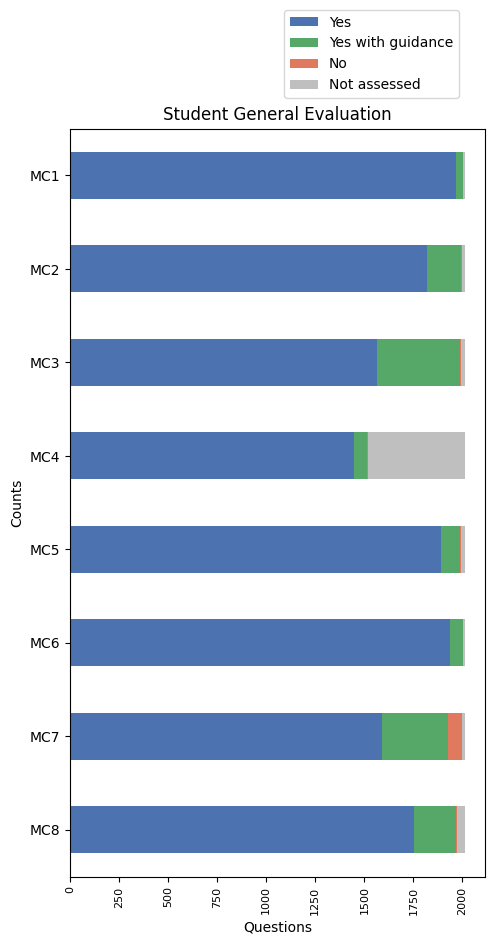

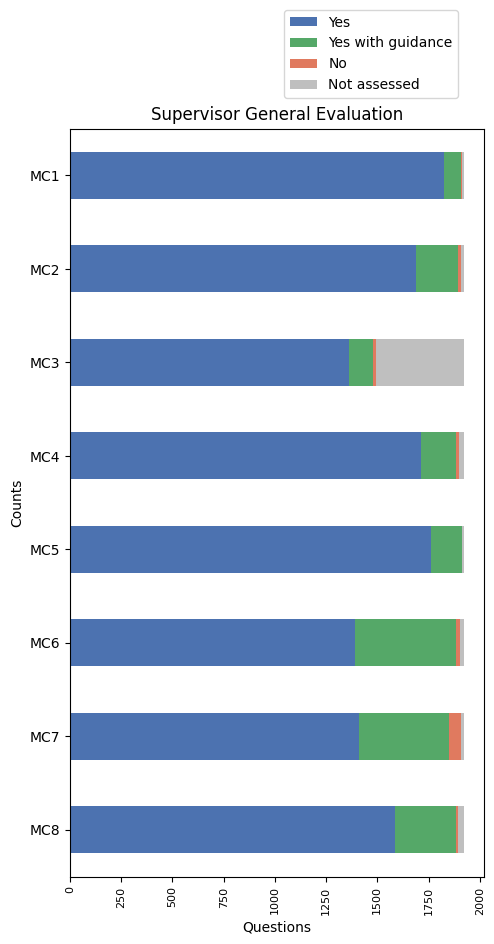

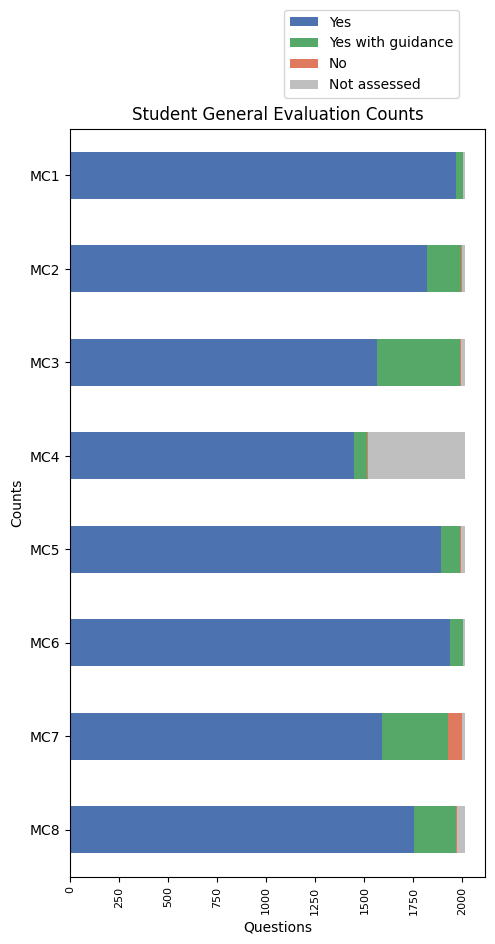

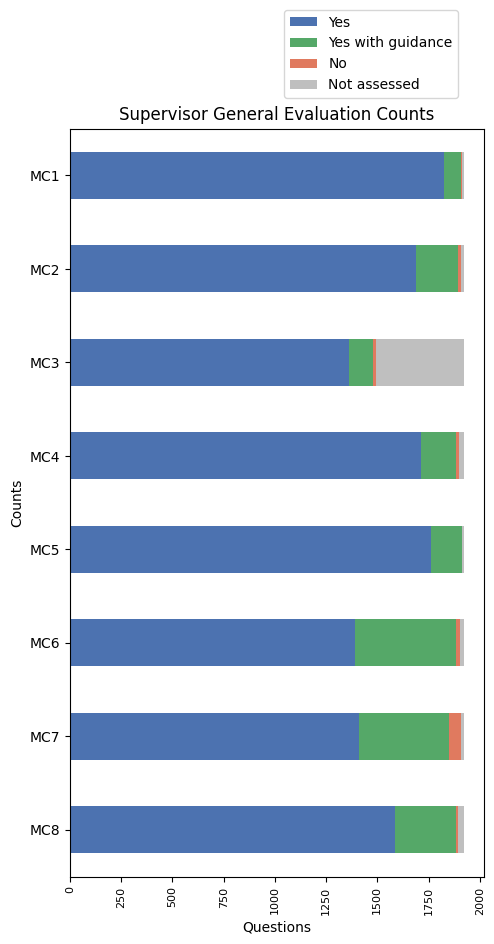

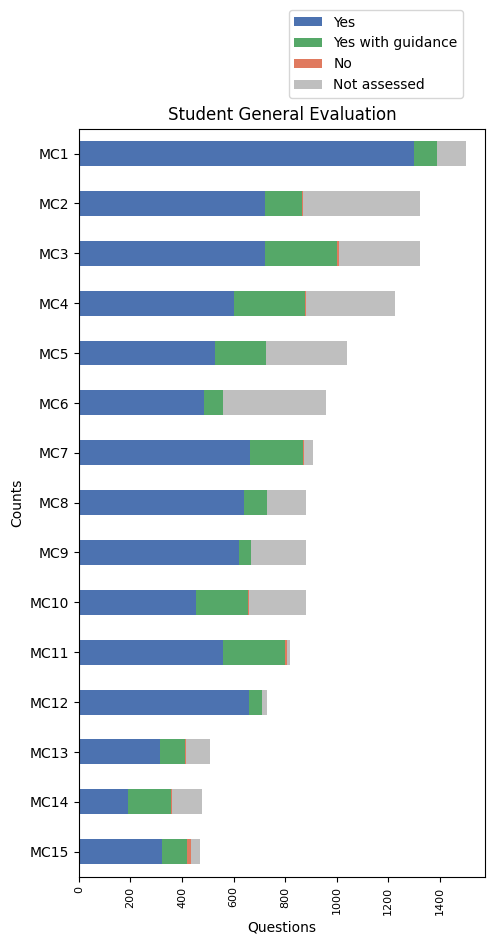

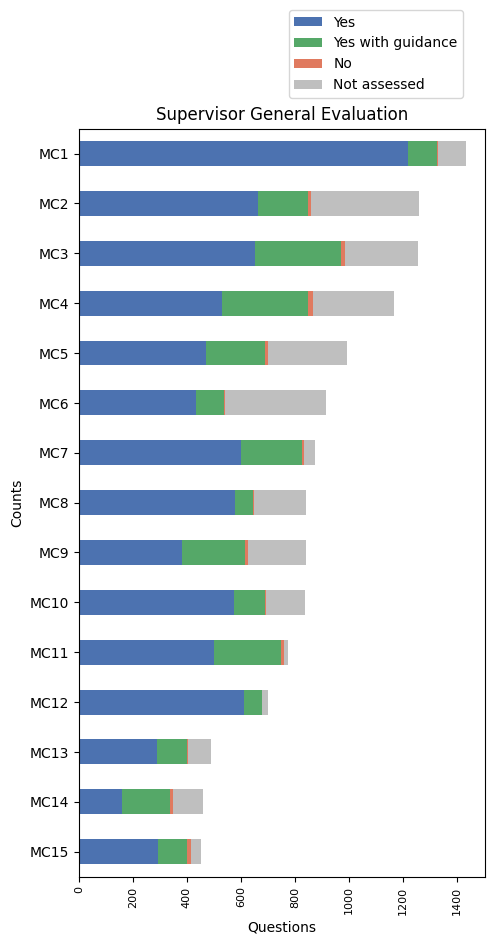

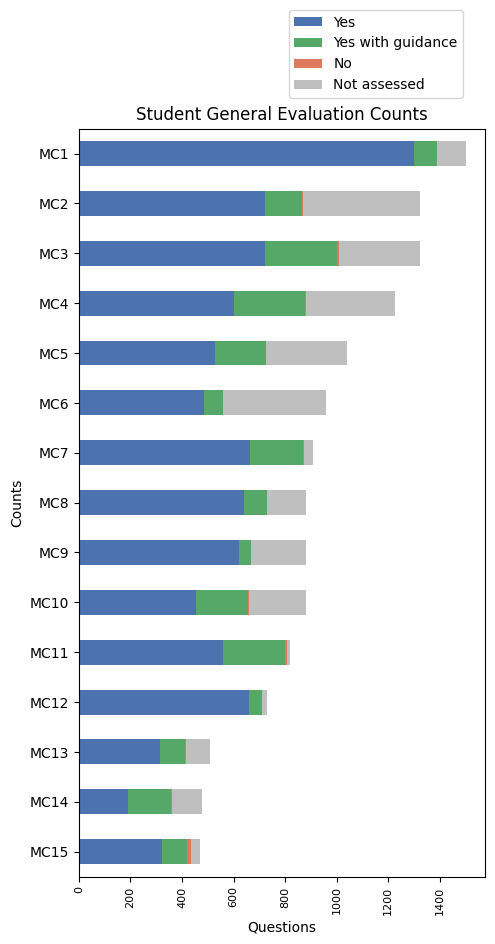

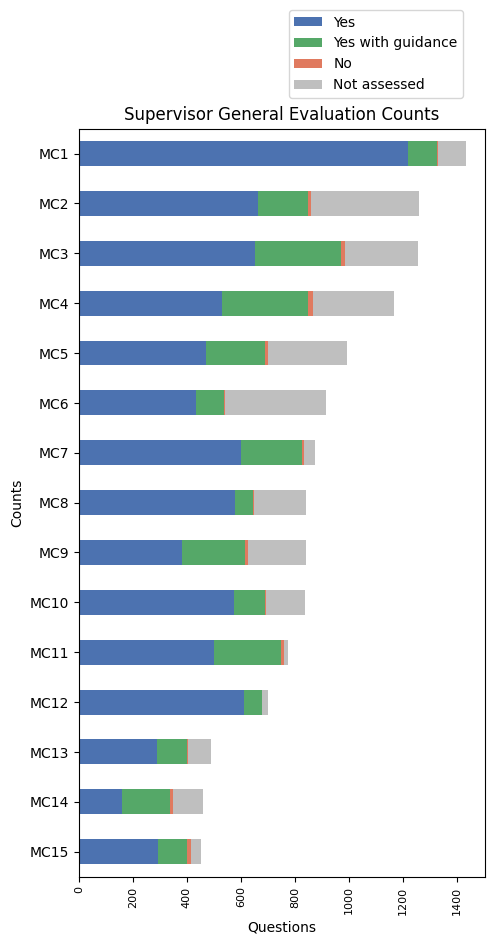

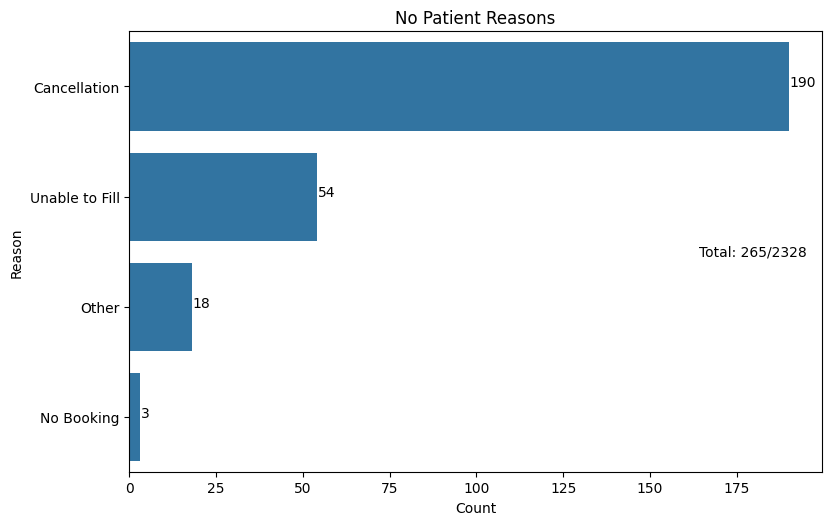

In [48]:
nTotal = len(df) # total forms
nStudents = len(df[studentIdCol].unique()) # number of students
dfidcounts = df[studentIdCol].value_counts().to_frame() # get student id values

# get role pie chart
fig, ax = plt.subplots(figsize=figSize)
df[roleCol].value_counts().plot.pie(ax=ax, autopct=lambda x: autopct(x, nTotal))
plt.title('Role Distribution')
plt.text(0.9, 0.9, f'Total: {nTotal}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
# plt.show()
imgrolepie = addPlotImage(fig, 0.5)

# get clinic pie chart
fig, ax = plt.subplots(figsize=figSize)
df[roleClinicType].value_counts().plot.pie(ax=ax, autopct=lambda x: autopct(x, nTotal))
plt.title('Clinic Type Distribution')
plt.text(0.9, 0.9, f'Total: {nTotal}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
# plt.show()
imgclinicpie = addPlotImage(fig, 0.5)

# create student, total, roles df===================================================================================
rolecountDf = pd.DataFrame(columns = ['Student ID', 'Student Name', 'Total Forms'] + df[roleCol].unique().tolist()[::-1])
# rolecountDf = pd.DataFrame(columns = ['Student ID', 'Student Name', 'Total Forms'] )
for id in dfidcounts.index:
    studentDf = df[df[studentIdCol]==id]
    studentName = studentDf[nameGCol].values[0] + ' ' + studentDf[nameFCol].values[0]
    totalforms = len(studentDf)
    rolecount = studentDf[roleCol].value_counts().astype(int)
    nopatient = studentDf[nopatientreason].value_counts().sum()
    rolecountDf = pd.concat([rolecountDf, pd.DataFrame({'Student ID': [id], 'Student Name': [studentName],
                                                         'Total Forms': [totalforms], **rolecount.to_dict()})])
rolecountDf.fillna(0, inplace=True)
display(rolecountDf.head())
rolecounttable = createTable(rolecountDf, 'Role Counts', colRatio = [1, 3, 1] + [1]*len(df[roleCol].unique()), customTextCols=[1],
                             bottomPadding=8)

# get bar chart of no patient reasons===============================================================================================
print(df[nopatientreason].unique())
df['category'] = df[nopatientreason].apply(categorize_reason) # Apply the categorization function
nNoPatient = df['category'].value_counts()
# print(nNoPatient)
totalnopatient = nNoPatient.sum()
nNoPatientdf = nNoPatient.to_frame().reset_index()
nNoPatientdf.columns = ['Reason', 'Count']
fig, ax = plt.subplots(figsize=(figSize[0], figSize[1]*0.45))
sns.barplot(x='Count', y='Reason', data=nNoPatientdf, ax=ax, orient='h')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.set_title('No Patient Reasons')
# show total number of patients
plt.text(0.9, 0.50, f'Total: {totalnopatient}/{nTotal}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
# show numbers on bars
for i, v in enumerate(nNoPatientdf['Count']):
    ax.text(v + 0.2, i, str(v), color='black')
fig.tight_layout()
plt.show()
imgnofill = addPlotImage(fig, 0.9)

In [49]:
# evalution counts for each column
plt.ioff()

# get all unique values in oclumns daEvalColsStu
def getEvalCounts(df, evalCols):
    uniquevals = []
    for col in evalCols:
        uniquevals.extend(df[col].unique())
    uniquevals = list(set(uniquevals))
    # remove nan
    uniquevals = [val for val in uniquevals if not pd.isna(val)]
    # create df for evaluation counts for each column
    evalcountDf = pd.DataFrame(columns = ['Question'] + uniquevals)
    for col in evalCols:
        evalcount = df[col].value_counts()
        fulltext = fullnamedict[col].split('-')[-1].replace('\n\n', '\n')
        evalcountDf = pd.concat([evalcountDf, pd.DataFrame({'Question': [fulltext],
                                                             **evalcount.to_dict()})])
    evalcountDf.fillna(0, inplace=True)
    return evalcountDf

evalcountDfStu = getEvalCounts(df, daEvalColsStu)
evalcountDfSup = getEvalCounts(df, daEvalColsSup)
# replace Yes withih guidance with Yes with guidance
evalcountDfSup.rename(columns={'Yes witih guidance': 'Yes with guidance'}, inplace=True)
display(evalcountDfStu)
display(evalcountDfSup)
colorDict = {
    'Yes': '#4c72b0',             # Muted Blue
    'Yes with guidance': '#55a868',  # Soft Green
    'No': '#e07a5f',             # Warm Red-Orange
    'Not assessed': '#bfbfbf',    # Neutral Grey
    'NA': '#bfbfbf'              # Grey for renamed 'Not assessed'
}

# crate pie charts for both student and supervisor with each having subplots for counts for each question
def createEvalPieChart(df, title):
    fig, ax = plt.subplots(
        nrows=df.shape[0], 
        ncols=1, 
        figsize=(figSize[0]*0.5, figSize[1]*0.8), 
        sharex=True
    )
    
    df.reset_index(drop=True, inplace=True)
    df.rename(columns={"Not assessed": "NA"}, inplace=True)
    # remove columns with 0 counts
    for i, row in df.iterrows():
        # remove columns with 0 counts
        row = row[row != 0]
        labels = row[1:].index
        sizes = row[1:].values
        # strip the labels
        labels = [label.strip() for label in labels]
        print(labels)
        # Get colors from colorDict or default
        pieColors = [colorDict[label] for label in labels]
        
        ax[i].pie(
            sizes, 
            autopct=lambda x: autopct(x, sizes.sum()), 
            labels=labels, 
            colors=pieColors, 
            textprops={'fontsize': 8}
        )
        ax[i].set_title(row['Question'], fontsize=7)
    
    # Increase the space between subplots
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle(title, fontsize=16, y=1.02)
    
    return fig


figstu = createEvalPieChart(evalcountDfStu, 'Student Evaluation Counts')
figsup = createEvalPieChart(evalcountDfSup, 'Supervisor Evaluation Counts')

def figToImage(fig):
    """Converts a Matplotlib figure to a PIL Image"""
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    return PIL.Image.open(buf)

# Convert both figures to images
imgStu = addPlotImage(figstu, 0.9)
imgSup = addPlotImage(figsup, 0.9)

# get gold and issue ratios
goldratio = getGoldRatio(df)
issueratio = getIssueRatio(df)
nAssistant = df[df[roleCol]=='Assistant'].shape[0]
print(goldratio, issueratio)

# IC breaches count
icbreach = df[daICSup].str.contains('Yes').sum()

# student feedback
# find non na values in daStuReflec
nNonNaStu = df[daReflecStu].notna().sum()
nNonNaSup = df[daReflecSup].notna().sum()
# find in role Assistant and Operator
nNonNaStuOper = df[df[roleCol]=='Operator'][daReflecStu].notna().sum()
nNonNaStuAssist = df[df[roleCol]=='Assistant'][daReflecStu].notna().sum()
# get number of positive and negative feedback (to do)

# get supervisor name value counts
supervisors = df[daNameSup].value_counts()
print(supervisors)
# Supervisor info is not valid as most only checked one student each


,Question,Yes with guidance,Not assessed,Yes,No
0,Professional behaviour & ethical conduct\natt...,5,40,219,1
0,Clinical safety\nincluding posture & sharps m...,4,52,209,0
0,Communication & respect/care for patient/s,4,53,208,0


,Question,Not assessed,Yes with guidance,Yes
0,Professional behaviour & ethical conduct\natt...,40,6,180
0,Clinical safety\nincluding posture & sharps m...,55,4,167
0,Communication & respect/care for patient/s,54,4,169


['Yes with guidance', 'NA', 'Yes', 'No']
['Yes with guidance', 'NA', 'Yes']
['Yes with guidance', 'NA', 'Yes']
['NA', 'Yes with guidance', 'Yes']
['NA', 'Yes with guidance', 'Yes']
['NA', 'Yes with guidance', 'Yes']
{'number': 2} {'number': 0}
DA SUP NAME
L Naharnowicz             23
Dr V Makadia              15
Dr Dalya Alzard           12
Dr Sheran Nagendran       11
Glenda Farmer             11
JK Fraser                 10
Janice Mouritz             9
Marwa Mostafa              9
RLHarvey                   8
Jyoti Anand                7
Ben Ross                   7
Dr Mandy Bhatti            7
Dr. Zhen Zeng              7
Dr Anastasia Kalantzis     7
Asseman                    6
Jonathan Goldberg          6
Sally Hashemi              5
Lauren Tieh                5
Dr Belinda Yeo             4
Dr. Ben Ross               4
Dr Janice Mouritz          4
Abella Huynh               4
Udovicic                   4
Asseman Fayaz              4
Annie Fang                 4
DR L Smythe        

#### OP info now

In [50]:
serviceCols = dfcolumns[60:68]
colServiceGeneral = dfcolumns[68]
additionalCols = dfcolumns[69:79]
complexityColStu = dfcolumns[81]
complexityColSup = dfcolumns[82]
colGeneralEvalStu = dfcolumns[84:92]
colGeneralEvalSup = dfcolumns[92:100]
colClnincEvalStu = dfcolumns[100:155]
colClnincEvalSup = dfcolumns[155:210]
opICStu = dfcolumns[210]
opICExpStu = dfcolumns[211]
opReflecStu = dfcolumns[212]
opICSup = dfcolumns[213]
opICExpSup = dfcolumns[214]
opOverallComp = dfcolumns[215]
opIssues = dfcolumns[216]
opGold = dfcolumns[217]
opReflecSup = dfcolumns[218]
opNameSup = dfcolumns[219]
opNPts = 'OP # OF PTS'
df[opNPts] = df[opNPts].fillna(0).astype(int)
colPtInfo = ['OP PT DETAILS_2', 'OP 2 PT DETAILS_2', 'OP 3 PT DETAILS_2', 'OP 4 PT DETAILS_2']
importantColsDa = [roleClinicLoc, roleClinicType, nopatientreason, daICStu, daICExpStu, daReflecStu, daICSup, daICExpSup, daReflecSup, daNameSup, daGold, daIssues]
importantColsOp = ['LA', 'TXMENT PLANNING', opICStu, opICExpStu, opICSup, opICExpSup, opReflecStu, opOverallComp, opIssues, opGold, opReflecSup, opNameSup]
importantCols = importantColsDa + importantColsOp
df[serviceCols] = df[serviceCols].astype(str)
df[additionalCols] = df[additionalCols].astype(str)
df[colServiceGeneral] = df[colServiceGeneral].astype(str)

In [51]:
# for each student get number of patients aggregate by id
nPatients = df.groupby(studentIdCol)[opNPts].sum()
nPatients = nPatients.to_frame()
display(nPatients)
avgPatients = nPatients.mean()
minPatients = nPatients.min()
maxPatients = nPatients.max()
print(avgPatients, minPatients, maxPatients)

,OP # OF PTS
STUDENT INFORMATION_2,
1027970,22
1031163,22
1064909,19
1069842,19
1079663,19
1079946,24
1079984,25
1080247,16
1081308,23


OP # OF PTS    21.77551
dtype: float64 OP # OF PTS    15
dtype: int64 OP # OF PTS    31
dtype: int64


In [52]:
def extractReadableText(item):
    # Extract any three-digit numbers first
    three_digit_number = re.search(r'\b\d{3}\b', item)
    if three_digit_number:
        return three_digit_number.group(0)
    
    # Check for numerical codes and add leading zeros if needed
    if re.match(r'^\d{1,2}$', item):
        return item.zfill(3)
    elif re.match(r'^\d{1,2}[/-]\d{1,2}$', item):
        parts = re.split(r'[/-]', item)
        return '/'.join([part.zfill(3) for part in parts])
    elif re.match(r'^\d+$', item):
        return item
    else:
        # Extract first three words for short text
        words = item.split()
        return ' '.join(words[:3]) if len(words) > 3 else item

In [53]:
readableItems = {   '': '',
    '- Adjusted incisal edges of lower anterior teeth\n- Primary Impressions': 'Adjusted incisal edges',
    '011 Comprehensive oral examination': '011',
    'Completed 011 and 221 - to be checked by supervisor next appointment': '011',
    '012 Periodic oral examination': '012',
    '013 Oral examination - limited': '013',
    '019 Letter of referral': '019',
    '022 / 024 Intraoral periapical or bitewing': '022 / 024',
    '061 Pulp testing': '061',
    '072 / 073 Intra-oral & extra-oral photographic records': '072 / 073',
    '111 Removal of plaque and/or stain': '111',
    '12': '012',
    '113': '113',
    '113 Recontouring/polishing of pre-existing restoration': '113',
    '114 / 115 Removal of calculus': '114 / 115',
    '121': '121',
    '121 / 123 Application of remin agent': '121 / 123',
    '13': '013',
    '131': '131',
    '131 Dietary analysis and advice': '131',
    '14': '014',
    '141': '141',
    '141 Oral hygiene instruction': '141',
    '142 Tobacco counselling': '142',
    '15 onlay prep': '15 onlay prep',
    '165': '165',
    '171 Odontoplasty': '171',
    '22': '022',
    '221': '221',
    '221 Clinical perio analysis and recording': '221',
    '221 Clinical periodontal analysis and recording': '221',
    '222': '222',
    '222 Periodontal debridement': '222',
    '24': '024',
    '311': '311',
    '311 / 316 Removal of a tooth or part(s) thereof': '311',
    '314': '314',
    '316': '316',
    '37': '037',
    '387': '387',
    '392 Drainage of abscess': '392',
    '42D': '42D',
    '42M': '42M',
    '46': '046',
    '47': '047',
    '521-525 Anterior restoration': '521-525',
    '523': '523',
    '531-535 Posterior restoration': '531-535',
    '572 Provisional/interim restoration': '572',
    '577 Cusp capping': '577',
    '61': '061',
    '627': '627',
    '71': '071',
    '72': '072',
    '73': '073',
    '741': '741',
    '776': '776',
    '799': '799',
    '918': '918',
    '927': '927',
    '927 Provision of medication/medicament': '927',
    '9270': '927',
    '935': '935',
    '941': '941',
    'Additional tooth Extraction': 'Additional tooth Extraction',
    'Adjustment of a denture clasp': 'Adjustment of a denture clasp',
    'Alginate impression of mandibular arch': 'Alginate impression',
    'Alginate impression of maxillary arch': 'Alginate impression',
    'Antibiotic prophylaxis for infective endocarditis': 'Antibiotic prophylaxis',
    'Arabic interpreter: Ezart': 'Arabic interpreter Ezart',
    'Clinical Perio Analysis': 'Clinical Perio Analysis',
    "Completed 011 but didn't charge yet because need supervisor to check odontogram": '011',
    'Completed history taking and odontogram': 'Completed history taking',
    'Consultation of relining upper full acrylic denture': 'Consultation of relining',
    'Denture adjustment': 'Denture adjustment',
    'Denture assessment': 'Denture assessment',
    'Denture insert': 'Denture insert',
    'Denture reline': 'Denture reline',
    'Denture repair': 'Denture repair',
    'Denture review': 'Denture review',
    'Desensitising procedure': 'Desensitising procedure',
    'Duraphat applied to 23D': 'Duraphat applied',
    'Exo of an additional tooth': 'Exo',
    'Impressions for occlusal appliance': 'Impressions for occlusal',
    'Incomplete periodontal examination': 'Incomplete periodontal examination',
    'Incomplete periodontal examination due to calculus deposits.': 'Incomplete periodontal examination',
    'Indirect restoration cementation': 'Indirect restoration cementation',
    'Initiated 011': '011',
    'Insertion of occlusal appliance': 'Insertion of occlusal',
    'Interpreter': 'Interpreter',
    'Interpreter on-site (Mandarin)': 'Interpreter',
    'Interpretor - did not show up': 'Interpretor',
    'Intra-oral photos to capture the lesion on the buccal mucosa': 'Intra-oral photos',
    'LA': 'LA',
    'Limited exam': 'Limited exam',
    'Local Anaesthesia': 'Local Anaesthesia',
    'Mandarin interpreter': 'Interpreter',
    'Medical history consultation': 'Medical history consultation',
    'Multiple recontourings': 'Multiple recontourings',
    'No Coding applicable': 'No Coding applicable',
    'Not yet complete': 'Not yet complete',
    'OH': 'OH',
    'OHI': 'OHI',
    'OPG': 'OPG',
    'OPG Radiograph': 'Radiograph',
    'OPG referral': 'OPG',
    'Oral Hygiene Instruction': 'Oral Hygiene Instruction',
    'Over the phone': 'Over the phone',
    'PA radiographs': 'Radiograph',
    'Panoramic radiograph': 'Radiograph',
    'Post and/or core for a crown': 'Post and/or core',
    'Primary impressions': 'Primary impressions',
    'Pulp test': 'Pulp test',
    'Pulp testing with TTP and CO2': 'Pulp test',
    'Recall limited exam': 'Recall limited exam',
    'Removal of a crown/onlay/bridge': 'Removal',
    'Saliva screening': 'Saliva test',
    'Saliva screening test': 'Saliva test',
    'Saliva tesing': 'Saliva test',
    'Saliva test': 'Saliva test',
    'Saliva testing': 'Saliva test',
    'saliva screening test': 'Saliva test',
    'Saliva Screening Test': 'Saliva test',
    'Secondary impressions': 'Secondary impressions',
    'Sectional removal of a tooth': 'Sectional removal',
    'Splinting': 'Splinting',
    'Splinting crown of tooth': 'Splinting',
    'Temporary crown/restoration': 'Temporary crown/restoration',
    'Tooth Mouse given to patient': 'Tooth Mouse',
    'Tooth Mousse': 'Tooth Mousse',
    'Tooth mousse given to pt': 'Tooth mousse',
    'Topical remin agent to address pt concerns': 'Topical remin agent',
    'Unchecked 012 by supervisor': '012',
    'and odontogram': 'odontogram',
    'dental hx': 'dental hx',
    'diagnostic model': 'diagnostic model',
    'diet analysis and advice': 'diet analysis',
    'diet counselling': 'diet counselling',
    'extra-oral photography': 'photography',
    'initiated 011 but did not complete periodontal charting; completed med hx': '011',
    'intra-oral photography': 'photography',
    'language: Mandarin': 'Interpreter',
    'perio charted finished but have yet to be checked by demo': 'perio charted finished',
    'pick up impression for upper and lower denture': 'pick up impression',
    'preliminary direct restoration for crown': 'preliminary direct restoration',
    'primary impression': 'primary impression',
    'primary impression with alginate and stock tray': 'primary impression',
    'pulp tests': 'pulp tests',
    'radiograph- 1st exposure': 'radiograph',
    'recontoured 16P RC overhang': 'recontoured 16P',
    'saliva analysis': 'saliva test',
    'saliva test': 'saliva test',
    'saliva testing': 'saliva test',
    'topical F': 'topical F',
    'unable to complete in time. To be finished next session.': '',
    'Exo additional tooth': 'Exo',
    'Rest seat preparation': 'Rest seat preparation'}

In [54]:
def process_row(row, serviceCols, colServiceGeneral, additionalCols):
    allCodes = []
    # Get codes from the service columns
    for col in serviceCols:
        if col not in df.columns:
            pprint(f"Column {col} not found in the DataFrame")
            continue
        if pd.isna(row[col]) or row[col] == 'nan':
            continue
        allCodes += row[col].split(',') # Find all the codes done for a row
    if colServiceGeneral in df.columns:          
        if pd.isna(row[colServiceGeneral]) or row[colServiceGeneral] == 'nan':
            pass
        else:              
            general_codes = row[colServiceGeneral].split(',')
            if len(general_codes) > 0:
                # pprint(f"General codes: {general_codes}")
                pass
            allCodes += general_codes
    # Get codes from additional columns
    for col in additionalCols:
        if col not in df.columns:
            pprint(f"Column {col} not found in the DataFrame")
            continue
        if pd.isna(row[col]) or row[col] == 'nan':
            continue
        allCodes += row[col].split(',')
    return ', '.join(allCodes)


laCol = 'LA'
df['ItemsOp'] = df.apply(lambda row: process_row(row, serviceCols, colServiceGeneral, additionalCols), axis=1)
# add LA to string if Yes
df['ItemsOp'] = df.apply(lambda row: f'{row["ItemsOp"]}, LA' if row[laCol]=='Yes' else row['ItemsOp'], axis=1)
# display(df['ItemsOp'].head(25))


# get bar chart of item counts
items = []
for item in df['ItemsOp']:
    items.extend(item.split(', '))
items = [item.strip() for item in items]
# remove nan
items = [item for item in items if item != 'nan']
# remove if more than 5 characters
uniqueItems = list(set(items))
print(uniqueItems)
# readableItems = {item: extractReadableText(item) for item in uniqueItems}
pprint(readableItems, indent=4)
# create a graph of items

code_counts = pd.Series(items).value_counts(ascending=False)
# remove empty strings
code_counts = code_counts[code_counts.index != '']
total = len(items)
# change the index to readable items
code_counts.index = [readableItems[item] if item in readableItems else item for item in code_counts.index]
display(code_counts)
code_counts = code_counts[code_counts.index != '']
# remove counts less than 2
code_counts = code_counts[code_counts > 2]
# plot
fig, ax = plt.subplots(figsize=(figSize[0], figSize[1]*0.6))
sns.barplot(x=code_counts.index, y=code_counts.values, ax=ax, edgecolor=None)
ax.set_title('Item Distribution')
ax.set_xlabel('Items')
ax.set_ylabel('Frequency')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.text(0.9, 0.9, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
# y ticks should be integers
ax.yaxis.get_major_locator().set_params(integer=True)
plt.tight_layout()
imgItemDist = addPlotImage(fig, 0.9)


# complexity count pie charts for student and supervisors in 2 subplots
complexityCountsStu = df[complexityColStu].value_counts()
complexityCountsSup = df[complexityColSup].value_counts()
totalStu = complexityCountsStu.sum()
totalSup = complexityCountsSup.sum()
fig, axes = plt.subplots(1, 2, figsize=(figSize[0], figSize[1]*1.5))
axes[0].pie(complexityCountsStu, autopct=lambda x: autopct(x, totalStu), labels=complexityCountsStu.index)
axes[0].set_title('Student Complexity')
axes[1].pie(complexityCountsSup, autopct=lambda x: autopct(x, totalSup), labels=complexityCountsSup.index)
axes[1].set_title('Supervisor Complexity')
# write the total number of values
axes[0].text(0.9, 0.9, f'Total: {totalStu}', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
axes[1].text(0.9, 0.9, f'Total: {totalSup}', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
plt.tight_layout()
imgComplexity = addPlotImage(fig, 0.9)

# if both student and supervisor have the different complexity, bar the nan values add a flag to complexityflag column
df['complexityflag'] = df[complexityColStu].fillna('nan') != df[complexityColSup].fillna('nan')
# get the counts
complexityflag = df['complexityflag'].value_counts()
print(complexityflag)
# display(df[df['complexityflag']].head())

# get general evaluation counts for student and supervisor columns and plot a stacked bar chart
uniquevals = [ 'Yes', 'Yes with guidance','No', 'Not assessed']
colors = ['blue', 'green', 'orange', 'lightgrey']
colors = ['#4c72b0',  # Muted Blue for 'Yes'
          '#55a868',  # Soft Green for 'Yes with guidance'
          '#e07a5f',  # Warm Red-Orange for 'No'
          '#bfbfbf']  # Neutral Grey for 'Not assessed'

def getEvalCounts(df, colGeneralEval):
    # create df for evaluation counts for each column
    evalcountDf = pd.DataFrame(columns = ['Question'] + uniquevals)
    for col in colGeneralEval:
        evalcount = df[col].value_counts()
        fulltext = fullnamedict[col].split('-')[-1].replace('\n\n', '\n')
        evalcountDf = pd.concat([evalcountDf, pd.DataFrame({'Question': [fulltext],
                                                             **evalcount.to_dict()})])
    evalcountDf.fillna(0, inplace=True)
    # sort by the total sum of the columns
    evalcountDf['sum'] = evalcountDf[uniquevals].sum(axis=1)
    evalcountDf = evalcountDf.sort_values('sum', ascending=False).drop('sum', axis=1)
    evalcountDf = evalcountDf.head(15)
    return evalcountDf


# create stacked bar chart for general evaluation counts
def createStackedBarChart(df, title, plotCol):
    fig, ax = plt.subplots(figsize=(figSize[0]*0.6, figSize[1]*0.8))
    plotdf = df.set_index(plotCol)
    plotdf = plotdf.loc[::-1]  # Reverse the order of bars
    plotdf.plot(kind='barh', stacked=True, ax=ax, color=colors)
    ax.set_title(title)
    ax.set_xlabel('Questions')
    ax.set_ylabel('Counts')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.legend(loc='center left', bbox_to_anchor=(0.5, 1.1))
    plt.tight_layout()
    return fig

# Create pseudo labels for questions

def createPseudoLabels(df):
    pseudo_labels = {}
    for i, question in enumerate(df['Question']):
        pseudo_label = f'MC{i+1}'
        pseudo_labels[question] = pseudo_label
    return pseudo_labels

# Apply pseudo labels to the dataframe
def applyPseudoLabels(df, pseudo_labels):
    df['PseudoLabel'] = df['Question'].map(pseudo_labels)
    return df

# Create reference table
def createReferenceTable(pseudo_labels):
    reference_table = pd.DataFrame(list(pseudo_labels.items()), columns=['Original Question', 'Pseudo Label'])
    return reference_table

# Generate pseudo labels and apply them
def createEvalPlots(df, colGeneralEvalStu, colGeneralEvalSup):
    evalcountDfStu = getEvalCounts(df, colGeneralEvalStu)
    evalcountDfSup = getEvalCounts(df, colGeneralEvalSup)
    display(evalcountDfStu.head())
    display(evalcountDfSup.head())
    pseudo_labels_stu = createPseudoLabels(evalcountDfStu)
    pseudo_labels_sup = createPseudoLabels(evalcountDfSup)
    evalcountDfStu = applyPseudoLabels(evalcountDfStu, pseudo_labels_stu)
    evalcountDfSup = applyPseudoLabels(evalcountDfSup, pseudo_labels_sup)

    # Create reference tables
    reference_table_stu = createReferenceTable(pseudo_labels_stu)
    reference_table_sup = createReferenceTable(pseudo_labels_sup)

    # Display reference tables
    # display(reference_table_stu)
    # display(reference_table_sup)

    # Create stacked bar charts with pseudo labels
    figstu = createStackedBarChart(evalcountDfStu[['PseudoLabel'] + uniquevals], 'Student General Evaluation', 'PseudoLabel')
    figsup = createStackedBarChart(evalcountDfSup[['PseudoLabel'] + uniquevals], 'Supervisor General Evaluation', 'PseudoLabel')

    figstu = createStackedBarChart(evalcountDfStu, 'Student General Evaluation Counts', 'PseudoLabel')
    figsup = createStackedBarChart(evalcountDfSup, 'Supervisor General Evaluation Counts', 'PseudoLabel')
    # Convert both figures to images
    imgStu = figToImage(figstu)
    imgSup = figToImage(figsup)
    # Create a new figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(figSize[0], figSize[1]))
    # Display images in the subplots
    axes[0].imshow(imgStu)
    axes[0].axis('off')
    axes[1].imshow(imgSup)
    axes[1].axis('off')
    plt.tight_layout()
    evalImgOp = addPlotImage(fig, 0.9)
    refTable = createTable(reference_table_stu, 'Reference Table', colRatio = [4, 1], customTextCols=[0])
    return evalImgOp, refTable

evalImgOp, refTable = createEvalPlots(df, colGeneralEvalStu, colGeneralEvalSup)
evalImgOp2, refTable2 = createEvalPlots(df, colClnincEvalStu, colClnincEvalSup)

# get IC breaches count
icbreachdf = df[df[opICSup]=='Yes']
icbreachdf.rename({studentIdCol: 'Student ID'}, axis=1, inplace=True)
icbreachdf['Student Name'] = icbreachdf[nameGCol] + ' ' + icbreachdf[nameFCol]
icbreachdf = icbreachdf[['Student ID', 'Student Name', opICExpSup]]
icbreachtable = createTable(icbreachdf, 'Students with IC Breaches', colRatio = [1, 2, 4], customTextCols=[1, 2])
# get gold and issue ratios
opgoldratio = getGoldRatio(df, goldCol=opGold)
opIssuesratio = getIssueRatio(df, issuesCol=opIssues)
nOperator = df[df[roleCol]=='Operator'].shape[0]
# get overall competency counts and plot a pie chart
opOverallCompCounts = df[opOverallComp].value_counts()
totalOp = opOverallCompCounts.sum()
fig, ax = plt.subplots(figsize=(figSize[0], figSize[1]*0.8))
ax.pie(opOverallCompCounts, autopct=lambda x: autopct(x, totalOp), labels=opOverallCompCounts.index)
ax.set_title('Overall Competency')
plt.tight_layout()
imgOverallComp = addPlotImage(fig, 0.9)



['', 'cusp capping', '222 Periodontal debridement', '165', 'surgical extraction of 48', '314', 'Temporary crown/restoration', 'Omed referral', 'Lithium Dislocate Crown insertion', 'Not yet complete', 'Smoking cessation', '012 Periodic oral examination', 'Finish of 011', 'Desensitising procedure â€“ per appointment', 'Duraphat applied to 23D', 'Saliva testing completed', 'Rest seat preparation', '113 Recontouring/polishing of pre-existing restoration', '653', 'SPLINT item; Insert splint & adjusted it for patient', 'Subsequent radiograph BW', '532', '523', 'Amal for 47DO', '927O Provision of medication other - Tooth mousse', '15 onlay prep', 'Exo additional tooth', '19', 'FLuoride gell Flairesse applied Q1 and Q4', 'Clinical Perio Analysis', '311', 'Local Anaesthesia', 'Could not complete 011 because pt had to leave early', '776', '34 and 36 - two charges', '731', 'Oral Hygiene Instruction', 'Saliva test completed', 'Additional tooth Extraction', 'Denture design and treatment planning', 

LA                                                                                                                                                                                        831
141                                                                                                                                                                                       674
114 / 115                                                                                                                                                                                 585
011                                                                                                                                                                                       495
022 / 024                                                                                                                                                                                 446
222                                               

complexityflag
False    1959
True      369
Name: count, dtype: int64


,Question,Yes,Yes with guidance,No,Not assessed
0,Professional behaviour & ethical conduct\natt...,1967,35,2,10
0,"Preparation for appointment\norganisation, ap...",1819,174,7,14
0,Clinical rationale & applied scientific/clini...,1563,422,7,22
0,Medical history taking\nsafety and relevance ...,1446,69,3,496
0,Clinical safety\nincluding posture & sharps m...,1892,93,8,21


,Question,Yes,Yes with guidance,No,Not assessed
0,Professional behaviour & ethical conduct\natt...,1825,84,6,10
0,"Preparation for appointment\norganisation, ap...",1687,209,14,15
0,Medical history taking\nsafety and relevance ...,1361,120,13,430
0,Clinical safety\nincluding posture & sharps m...,1712,173,13,26
0,Communication & respect/care for patient/s,1762,149,1,12


Creating table for Reference Table


,Question,Yes,Yes with guidance,No,Not assessed
0,Specific post op instructions and care,1299,89,2,110
0,Applied risk assessment \npresumptive and/or ...,722,144,2,455
0,Diagnosis/es and problem list,721,282,6,313
0,centred,600,278,4,344
0,Periodontal assessment,529,196,2,311


,Question,Yes,Yes with guidance,No,Not assessed
0,Specific post op instructions and care,1217,109,4,102
0,Applied risk assessment \npresumptive and/or ...,663,184,12,400
0,Diagnosis/es and problem list,651,321,12,273
0,centred,531,316,19,302
0,Periodontal assessment,470,221,9,291


Creating table for Reference Table
Creating table for Students with IC Breaches


In [55]:
# analyse info per row/student
# get studentid value counts
studentidcounts = df[studentIdCol].value_counts()
print(studentidcounts)
# for each row get Yes No and Not assessed counts for geneeral evaluation and clinic evaluation
# first for general evaluation
df['Yes General Stu'] = df[colGeneralEvalStu].apply(lambda x: (x == 'Yes').sum(), axis=1)
df['Yes with guidance General Stu'] = df[colGeneralEvalStu].apply(lambda x: (x == 'Yes with guidance').sum(), axis=1)
df['No General Stu'] = df[colGeneralEvalStu].apply(lambda x: (x == 'No').sum(), axis=1)
df['Not assessed General Stu'] = df[colGeneralEvalStu].apply(lambda x: (x == 'Not assessed').sum(), axis=1)
# score is 1 for Yes, 1 for Yes with guidance, 0 for No and 0.5 for Not assessed (Yes + Yes with guidance)/(Yes + Yes with guidance + No + 0.5*Not assessed)
df['General Stu Score'] = (df['Yes General Stu'] + df['Yes with guidance General Stu'] + 0.5*df['Not assessed General Stu'])/(df['Yes General Stu'] + df['Yes with guidance General Stu'] + df['No General Stu'] + 0.5*df['Not assessed General Stu'])
# then for clinic evaluation
df['Yes Clinic Stu'] = df[colClnincEvalStu].apply(lambda x: (x == 'Yes').sum(), axis=1)
df['Yes with guidance Clinic Stu'] = df[colClnincEvalStu].apply(lambda x: (x == 'Yes with guidance').sum(), axis=1)
df['No Clinic Stu'] = df[colClnincEvalStu].apply(lambda x: (x == 'No').sum(), axis=1)
df['Not assessed Clinic Stu'] = df[colClnincEvalStu].apply(lambda x: (x == 'Not assessed').sum(), axis=1)
df['Clinic Stu Score'] = (df['Yes Clinic Stu'] + df['Yes with guidance Clinic Stu'] + 0.5*df['Not assessed Clinic Stu'])/(df['Yes Clinic Stu'] + df['Yes with guidance Clinic Stu'] + df['No Clinic Stu'] + 0.5*df['Not assessed Clinic Stu'])

# Plot the scores v/s overall competencies as two scatter plots one for student and one for supervisor
fig, ax = plt.subplots(1, 2, figsize=(figSize[0], figSize[1] * 0.45))

# Only include operators
dfscatter = df[df[roleCol] == 'Operator']
xCategories = dfscatter[opOverallComp].unique()
# General Evaluation Scatter + Box Plot
sns.boxplot(y='General Stu Score', x=opOverallComp, data=dfscatter, ax=ax[0], showcaps=False, 
            boxprops={'facecolor':'none'}, whiskerprops={'linewidth':0}, medianprops={'color':'black'})
sns.scatterplot(y='General Stu Score', x=opOverallComp, data=dfscatter, ax=ax[0], alpha=0.7)
ax[0].set_title('General Evaluation Score vs Overall Competency')

# Clinic Evaluation Scatter + Box Plot
sns.boxplot(y='Clinic Stu Score', x=opOverallComp, data=dfscatter, ax=ax[1], showcaps=False, 
            boxprops={'facecolor':'none'}, whiskerprops={'linewidth':0}, medianprops={'color':'black'})
sns.scatterplot(y='Clinic Stu Score', x=opOverallComp, data=dfscatter, ax=ax[1], alpha=0.7)
ax[1].set_title('Clinic Evaluation Score vs Overall Competency')

# Rotate x labels
for i in range(2):
    ax[i].set_xticklabels([label.get_text().split('/')[0] for label in ax[i].get_xticklabels()], rotation=90)

plt.tight_layout()
imgScatter1 = addPlotImage(fig, 0.9)

# now same for supervisor
# first for general evaluation
df['Yes General Sup'] = df[colGeneralEvalSup].apply(lambda x: (x == 'Yes').sum(), axis=1)
df['Yes with guidance General Sup'] = df[colGeneralEvalSup].apply(lambda x: (x == 'Yes with guidance').sum(), axis=1)
df['No General Sup'] = df[colGeneralEvalSup].apply(lambda x: (x == 'No').sum(), axis=1)
df['Not assessed General Sup'] = df[colGeneralEvalSup].apply(lambda x: (x == 'Not assessed').sum(), axis=1)
df['General Sup Score'] = (df['Yes General Sup'] + df['Yes with guidance General Sup'] + 0.5*df['Not assessed General Sup'])/(df['Yes General Sup'] + df['Yes with guidance General Sup'] + df['No General Sup'] + 0.5*df['Not assessed General Sup'])
# then for clinic evaluation
df['Yes Clinic Sup'] = df[colClnincEvalSup].apply(lambda x: (x == 'Yes').sum(), axis=1)
df['Yes with guidance Clinic Sup'] = df[colClnincEvalSup].apply(lambda x: (x == 'Yes with guidance').sum(), axis=1)
df['No Clinic Sup'] = df[colClnincEvalSup].apply(lambda x: (x == 'No').sum(), axis=1)
df['Not assessed Clinic Sup'] = df[colClnincEvalSup].apply(lambda x: (x == 'Not assessed').sum(), axis=1)
df['Clinic Sup Score'] = (df['Yes Clinic Sup'] + df['Yes with guidance Clinic Sup'] + 0.5*df['Not assessed Clinic Sup'])/(df['Yes Clinic Sup'] + df['Yes with guidance Clinic Sup'] + df['No Clinic Sup'] + 0.5*df['Not assessed Clinic Sup'])

# Plot the scores v/s overall competencies as two scatter plots one for student and one for supervisor
fig, ax = plt.subplots(1, 2, figsize=(figSize[0], figSize[1] * 0.45))

# Only include operators
dfscatter = df[df[roleCol] == 'Operator']
xCategories = dfscatter[opOverallComp].unique()
# General Evaluation Scatter + Box Plot
sns.boxplot(y='General Sup Score', x=opOverallComp, data=dfscatter, ax=ax[0], showcaps=False, 
            boxprops={'facecolor':'none'}, whiskerprops={'linewidth':0}, medianprops={'color':'black'})
sns.scatterplot(y='General Sup Score', x=opOverallComp, data=dfscatter, ax=ax[0], alpha=0.7)
ax[0].set_title('General Evaluation Score vs Overall Competency')

# Clinic Evaluation Scatter + Box Plot
sns.boxplot(y='Clinic Sup Score', x=opOverallComp, data=dfscatter, ax=ax[1], showcaps=False, 
            boxprops={'facecolor':'none'}, whiskerprops={'linewidth':0}, medianprops={'color':'black'})
sns.scatterplot(y='Clinic Sup Score', x=opOverallComp, data=dfscatter, ax=ax[1], alpha=0.7)
ax[1].set_title('Clinic Evaluation Score vs Overall Competency')

# Rotate x labels
for i in range(2):
    ax[i].set_xticklabels([label.get_text().split('/')[0] for label in ax[i].get_xticklabels()], rotation=90)
# don't show x axis title for both
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.tight_layout()
imgScatter2 = addPlotImage(fig, 0.9)

# Unfinished students
colFinished = 'Finished'
Unfinished = df[df[colFinished]=='FALSE']
print(Unfinished)
Unfinishednames = Unfinished[nameGCol] + ' ' + Unfinished[nameFCol]
UnfinishedText = f'These student forms are unfinished: {", ".join(Unfinishednames)}'
# now save the df
# df.to_excel(f'{folder}/{file} new.xlsx', index=False)

STUDENT INFORMATION_2
1232770    28
993640     27
1027970    27
1309763    27
1384393    26
1287253    26
1391596    26
1307153    26
1170752    26
1064909    26
1174172    26
1211876    26
1173233    25
1180737    25
1399221    25
1170316    25
1391557    25
1172496    25
1420124    25
1384392    25
1173101    25
1399214    25
1399220    25
1402039    25
1371861    24
1181472    24
1377158    24
1081787    24
1113227    24
1402789    24
1420062    24
1031163    24
1168876    24
1388926    24
1402035    24
1081308    24
1082185    24
1212518    24
1420060    24
1394124    24
1420079    24
1170745    24
1107398    24
992914     24
1384390    24
1181425    24
1420053    24
587525     24
1300764    24
1083971    24
1079946    24
1391578    24
1387067    24
1187046    24
1170993    24
1079984    24
1081376    24
1082018    24
1178529    23
1330715    23
1420100    23
1383423    23
758770     23
1309751    23
1420122    23
1420119    23
1301220    23
1420118    23
1389354    23
1329195    2

In [ ]:
doc = SimpleDocTemplate(f'{folder}\\DDS3 {"+".join(clinics)} Summary.pdf', pagesize= pageSize, leftMargin = leftMargin,
                            rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
elements = []
elements.append(Paragraph('Summary', headingStyle))
elements.append(Spacer(1, 24))
elements.append(Paragraph('General Information', subheadingStyle))
elements.append(Spacer(1, 12))
elements.append(Paragraph(f'Clinics: {", ".join(clinics)}', subsubheadingStyle))
elements.append(Spacer(1, 24))
if len(clinics)> 1:
    elements.append(Paragraph('Clinic Distribution', subsubheadingStyle))
    elements.append(Spacer(1, 12))
    elements.append(imgclinicpie)
    elements.append(Spacer(1, 24))
elements.append(Paragraph('Role Distribution', subsubheadingStyle))
elements.append(Spacer(1, 12))
elements.append(imgrolepie)
elements.append(Spacer(1, 24))
elements.append(rolecounttable)
elements.append(KeepTogether([
    Paragraph('No Patient Reasons', subsubheadingStyle),
    Spacer(1, 12),
    imgnofill,
]))

elements.append(PageBreak())
# elements.append(Spacer(1, 24))
elements.append(Paragraph('DA Information', subheadingStyle))
elements.append(Spacer(1, 12))
elements.append(Paragraph('Evaluation Summary', subsubheadingStyle))
elements.append(Spacer(1, 24))
elements.append(imgStu)
elements.append(Spacer(1, 12))
elements.append(imgSup)
elements.append(PageBreak())
elements.append(Spacer(1, 24))
elements.append(Paragraph('Gold Stars and Issues', subsubheadingStyle))
elements.append(Spacer(1, 12))
elements.append(Paragraph(f'Number of Gold Stars: {goldratio["number"]}/{nAssistant}.', tableTextStyle))
elements.append(Spacer(1, 6))
elements.append(Paragraph(f'Percentage of Gold Stars: {round(goldratio["number"]/nAssistant*100,2)}%', tableTextStyle))
elements.append(Spacer(1, 6))
elements.append(Paragraph(f'Number of Issues Raised: {issueratio["number"]}/{nAssistant}', tableTextStyle))
elements.append(Spacer(1, 6))
elements.append(Paragraph(f'Number of IC Breaches: {icbreach}/{nAssistant}', tableTextStyle))
elements.append(Spacer(1, 24))
elements.append(Paragraph(f'Student and Supervisor Reflections', subsubheadingStyle))
elements.append(Spacer(1, 12))
elements.append(Paragraph(f'Number of Student Reflections: {nNonNaStu}/{nAssistant}', tableTextStyle))
elements.append(Spacer(1, 6))
elements.append(Paragraph(f'Number of Supervisor Reflections: {nNonNaSup}/{nAssistant}', tableTextStyle))
elements.append(Spacer(1, 12))
# elements.append(Paragraph(f'Supervisor grading Information', subsubheadingStyle))
# elements.append(Spacer(1, 6))
# elements.append(Paragraph(f'Supervisor Information is not valid as most only checked one student each', tableTextStyle))
elements.append(PageBreak())

# operator info now
elements.append(Paragraph('Operator Information', subheadingStyle))
elements.append(Spacer(1, 12))
elements.append(imgItemDist)
elements.append(Spacer(1, 12))
elements.append(Paragraph('Complexity Information', subsubheadingStyle))
elements.append(Spacer(1, 24))
elements.append(imgComplexity)
elements.append(Spacer(1, 12))
elements.append(Paragraph("Some supervisors are not filling in the complexity, IDK if this is a problem. For them I am using student's complexity level", tableTextStyle))
elements.append(Spacer(1, 12))

elements.append(KeepTogether([
    Paragraph('Evaluation Information General', subsubheadingStyle),
    Spacer(1, 12),
    evalImgOp,
    Spacer(1, 12),
    refTable,
    PageBreak()
]))

elements.append(KeepTogether([
    Paragraph('Evaluation Information Clinic', subsubheadingStyle),
    Spacer(1, 12),
    evalImgOp2,
    Spacer(1, 12),
    refTable2,
    PageBreak()
]))

elements.append(Paragraph('Overall Competency', subsubheadingStyle))
elements.append(Spacer(1, 12))
elements.append(imgOverallComp)
elements.append(Spacer(1, 24))

elements.append(Paragraph('Gold Stars and Issues', subsubheadingStyle))
elements.append(Spacer(1, 12))
elements.append(Paragraph(f'Number of Gold Stars: {opgoldratio["number"]}/{nOperator}.', tableTextStyle))
elements.append(Spacer(1, 6))
elements.append(Paragraph(f'Percentage of Gold Stars: {round(opgoldratio["number"]/nOperator*100,2)}%', tableTextStyle))
elements.append(Spacer(1, 6))
elements.append(Paragraph(f'Number of Issues Raised: {opIssuesratio["number"]}/{nOperator}', tableTextStyle))
elements.append(Spacer(1, 6))
elements.append(Paragraph(f'Number of IC Breaches: {icbreach}/{nOperator}', tableTextStyle))
elements.append(Spacer(1, 24))
elements.append(icbreachtable)
elements.append(PageBreak())
elements.append(Paragraph('Scatter Plots for score v/s competency', subheadingStyle))
elements.append(Spacer(1, 24))
elements.append(Paragraph('Student Evaluation', subsubheadingStyle))
elements.append(Spacer(1, 12))
elements.append(imgScatter1)
elements.append(Spacer(1, 24))
elements.append(Paragraph('Supervisor Evaluation', subsubheadingStyle))
elements.append(Spacer(1, 12))
elements.append(imgScatter2)
elements.append(Spacer(1, 24))
elements.append(Paragraph('Correlation between overall competency and scores have improved but still the <i>Developing Competency</i> is too spread out in scores. Implies objectivity in marking has increased but still needs improvement.', tableTextStyle))
elements.append(PageBreak())
elements.append(Paragraph('Unfinished Students', subheadingStyle))
elements.append(Spacer(1, 12))
elements.append(Paragraph(UnfinishedText, tableTextStyle))

doc.build(elements)
import sys
sys.exit("Stopping execution")

### Student reports

In [59]:
def createEvalDf(row, studentcol, supervisorcol):
    evaldf = pd.DataFrame(columns = [ 'Marking Checklist', 'Student', 'Educator'])
    for stucol, educol in zip(studentcol, supervisorcol):
        # get common text in fullnamedict[stucol] and fullnamedict[educol]
        # commonText = 
        markingchecklist = fullnamedict[stucol].split(' Student - ')[-1]
        # remove non alphanumeric characters
        markingchecklist = re.sub(r'\W+', ' ', markingchecklist)
        student = row[stucol]
        educator = row[educol]
        # if both are nan, continue
        if (pd.isna(student) or student == 'nan') and (pd.isna(educator) or educator == 'nan'):
            continue
        evaldf = pd.concat([evaldf, pd.DataFrame({ 'Marking Checklist': [markingchecklist], 
                                                  'Student': [student], 'Educator': [educator]})])
    return evaldf


smallsubsubheadingStyleL = ParagraphStyle('Heading3', parent=styles['Heading3'], fontSize=13, alignment=0)
def createReport(studentDf, id, name, savefolder):
    os.makedirs(savefolder, exist_ok=True)
    print(id, name)
    elements = []
    doc = SimpleDocTemplate(f'{savefolder}\\{name} ({id}).pdf', pagesize= pageSize, leftMargin = leftMargin,
                            rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
    elements.append(Paragraph(f'{name} ({id})', headingStyle))
    elements.append(Spacer(1, 24))
    dfDateRoleItems = pd.DataFrame(columns=['Date', 'Role', 'Items', 'No. of Patients'])
    allstudentcol = [col for col in studentDf.columns if '#1' in col.lower()]
    allsupervisorcol = [col for col in studentDf.columns if '#2' in col.lower()]
    for i, row in studentDf.iterrows():
        date = row[dateCol].strftime('%d-%m-%Y')
        role = row[roleCol]
        items = []
        for item in row['ItemsOp'].split(', '):
            if item.strip() not in readableItems:
                continue
            items.append(readableItems[item.strip()])
        # remove nan
        items = [item for item in items if item != 'nan']
        items = list(set(items))    
        # convert to string
        items = ', '.join(items).strip(',')
        # get the number of patients
        npts = row[opNPts]
        # get the clinical incident
        dfDateRoleItems = pd.concat([dfDateRoleItems, pd.DataFrame({'Date': [date], 'Role': [role], 'Items': [items], 'No. of Patients': [npts]})])
    display(dfDateRoleItems)
    table = createTable(dfDateRoleItems, 'Item Summary', colRatio = [1, 1.5, 3, 2], customTextCols=[2])
    elements.append(table)
    elements.append(PageBreak())
    studentDf.reset_index(drop=True, inplace=True)
    for i, row in studentDf.iterrows():
        # for all the important columns display column name and value
        elements.append(Paragraph(f'Form {i+1}: {row[dateCol].strftime("%d-%m-%Y")}', subheadingStyle))
        elements.append(Paragraph(f'Role: {row[roleCol]}', subsubheadingStyle))
        elements.append(Spacer(1, 10))
        # fill in patient info in colPtInfo
        for col in colPtInfo:
            if pd.isna(row[col]) or row[col] == 'nan':
                continue
            elements.append(Paragraph(f'{fullnamedict[col]}: {row[col]}', tableTextStyle))
            elements.append(Spacer(1, 6))

        # fill in the important columns
        for col in importantCols:
            if pd.isna(row[col]) or row[col] == 'nan':
                continue
            # print(f'{col}: {row[col]}')
            elements.append(Paragraph(f'{fullnamedict[col]}', smallsubsubheadingStyleL))
            elements.append(Spacer(1, 6))
            elements.append(Paragraph(f'{row[col].strip()}', tableTextStyleL))
            elements.append(Spacer(1, 12))

        # if row[roleCol] == 'Operator' and int(row[opNPts]) > 0:
            # elements.append(Paragraph(f'Evaluation', subheadingStyle))
        evaldf = createEvalDf(row, allstudentcol, allsupervisorcol)
        evaldf.replace({'Not assessed': 'NA', 'Not relevant': 'NA', 'Not reviewed':'NA', 'nan': 'NA'}, inplace=True)
        evaldf['Student'] = evaldf['Student'].astype(str)
        evaldf['Educator'] = evaldf['Educator'].astype(str)
        evaldf.replace({'nan': 'NA'}, inplace=True)
        # remove rows where both student and educator are NA, nan
        evaldf = evaldf[~((evaldf['Student']=='NA') & (evaldf['Educator']=='NA'))]
        table = createTable(evaldf, 'Evaluation', colRatio = [5, 2, 2], customTextCols=[0], cellHighlight=True, 
                            tableTextStyle=tableTextStyleSmall)
        elements.append(table)


        elements.append(PageBreak())
        # break
    doc.build(elements)
    pass


def createStudentReport(df, cohort, savefolder):
    idCounts = df[studentIdCol].value_counts()
    ids = idCounts.index
    print(idCounts)
    for id in ids:
        studentDf = df[df[studentIdCol]==id]
        studentName = studentDf[nameFCol].values[0] + ' ' + studentDf[nameGCol].values[0]
        # display(studentDf)
        createReport(studentDf, id, studentName, os.path.join(savefolder, cohort))
        # break

savefolder = f'{folder}\\Student Reports {"+".join(clinics)}'
createStudentReport(df, f'DDS3', savefolder) 

    

STUDENT INFORMATION_2
1232770    28
993640     27
1027970    27
1309763    27
1384393    26
1287253    26
1391596    26
1307153    26
1170752    26
1064909    26
1174172    26
1211876    26
1173233    25
1180737    25
1399221    25
1170316    25
1391557    25
1172496    25
1420124    25
1384392    25
1173101    25
1399214    25
1399220    25
1402039    25
1371861    24
1181472    24
1377158    24
1081787    24
1113227    24
1402789    24
1420062    24
1031163    24
1168876    24
1388926    24
1402035    24
1081308    24
1082185    24
1212518    24
1420060    24
1394124    24
1420079    24
1170745    24
1107398    24
992914     24
1384390    24
1181425    24
1420053    24
587525     24
1300764    24
1083971    24
1079946    24
1391578    24
1387067    24
1187046    24
1170993    24
1079984    24
1081376    24
1082018    24
1178529    23
1330715    23
1420100    23
1383423    23
758770     23
1309751    23
1420122    23
1420119    23
1301220    23
1420118    23
1389354    23
1329195    2

,Date,Role,Items,No. of Patients
0,20-01-2025,Operator,011,1
0,22-01-2025,Operator,"141, 012, 222, 111",1
0,29-01-2025,Assistant,,0
0,02-07-2025,Operator,"114 / 115, 012",1
0,02-11-2025,Operator,"114 / 115, 141, 011, 113",1
0,02-11-2025,Operator,,0
0,18-02-2025,Operator,"Denture adjustment, 114 / 115, 141, 011, 221",1
0,21-02-2025,Operator,"114 / 115, 141, 012",1
0,25-02-2025,Operator,"114 / 115, 141, 012, 113",1
0,24-02-2025,Operator,,1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
993640 Liu Mary


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"799, 011",1
0,24-01-2025,Assistant,,0
0,21-01-2025,Operator,,0
0,02-05-2025,Operator,"061, 221, 022 / 024",1
0,02-07-2025,Assistant,,0
0,02-12-2025,Assistant,,0
0,02-09-2025,Operator,,0
0,19-02-2025,Operator,"LA, 531-535",1
0,21-02-2025,Operator,"221, 141, 022 / 024, 111",1
0,26-02-2025,Operator,"011, 022 / 024, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1027970 Wu Jason


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"114 / 115, 141, 121 / 123, 221",1
0,02-05-2025,Operator,"LA, 521-525",1
0,02-04-2025,Operator,,0
0,02-12-2025,Operator,"531-535, 927, 141, 012, 121 / 123",1
0,14-02-2025,Operator,"113, 221, 114 / 115",1
0,19-02-2025,Operator,"061, 011, 022 / 024",1
0,26-02-2025,Operator,"LA, 531-535",1
0,26-02-2025,Operator,"LA, 531-535",1
0,28-02-2025,Operator,"013, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1309763 Tovar Luisana


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,,1
0,22-01-2025,Operator,,1
0,31-01-2025,Operator,"141, 121 / 123, 221, 111",1
0,02-05-2025,Operator,"072 / 073, 022 / 024, 061, 121 / 123, 013",1
0,02-12-2025,Operator,"072 / 073, 022 / 024, 061, 121 / 123, 011",1
0,14-02-2025,Operator,"114 / 115, 141, 121 / 123",1
0,19-02-2025,Operator,"Temporary crown/restoration, 15 onlay prep, 79...",1
0,26-02-2025,Operator,"LA, 121 / 123, 521-525",1
0,28-02-2025,Assistant,,0
0,03-05-2025,Operator,"Temporary crown/restoration, LA, Rest seat pre...",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1384393 Soliman Kareem


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,22-01-2025,Assistant,,0
0,02-05-2025,Operator,"531-535, Oral Hygiene Instruction, 114 / 115, ...",1
0,02-07-2025,Operator,"221, 111",1
0,02-12-2025,Operator,"LA, 012, 531-535",1
0,19-02-2025,Operator,"022 / 024, 114 / 115, 011, 121 / 123, 111",1
0,21-02-2025,Operator,"114 / 115, LA, 121 / 123",1
0,26-02-2025,Operator,"LA, 521-525, 011, 022 / 024",1
0,03-05-2025,Assistant,,0
0,03-07-2025,Operator,"114 / 115, 165, LA",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1287253 Nguyen Toan


,Date,Role,Items,No. of Patients
0,23-01-2025,Assistant,,0
0,24-01-2025,Assistant,,0
0,24-01-2025,Assistant,,0
0,02-06-2025,Operator,"019, 022 / 024, 141, 011, 111",1
0,02-07-2025,Assistant,,0
0,13-02-2025,Operator,"011, 022 / 024",1
0,20-02-2025,Operator,022 / 024,1
0,21-02-2025,Assistant,,0
0,03-06-2025,Operator,"Saliva test, 141, 121 / 123, 047, 111",1
0,03-07-2025,Operator,"LA, 222",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1391596 Han Jessica


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"141, 222, 111",1
0,02-05-2025,Operator,"Primary impressions, 799, 142, 141, 011, prima...",1
0,02-12-2025,Assistant,,0
0,14-02-2025,Operator,"222, 142, 141, LA, 111",1
0,19-02-2025,Operator,"Primary impressions, 013, 776, pick up impression",1
0,14-02-2025,Operator,,0
0,14-02-2025,Operator,,0
0,26-02-2025,Assistant,,0
0,28-02-2025,Operator,"141, 222, 013, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1307153 Park Jonathan Keunhyung


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,24-01-2025,Operator,"222, 114 / 115, LA, 013, 221",1
0,21-01-2025,Operator,,0
0,02-04-2025,Operator,"061, 012, 221, 022 / 024",1
0,02-07-2025,Operator,"221, 111",1
0,02-11-2025,Operator,"Interpreter, Over the phone, 011, 935",1
0,18-02-2025,Operator,,1
0,21-02-2025,Assistant,,0
0,25-02-2025,Operator,"141, 013, LA, 221",1
0,03-04-2025,Operator,"Denture adjustment, 022 / 024, 741, 141, 013, ...",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1170752 Ma Lucy


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,24-01-2025,Operator,"141, 121 / 123, 221, 111",1
0,02-04-2025,Operator,"114 / 115, 141, 012, 121 / 123",1
0,02-07-2025,Operator,"LA, 012, 222",1
0,02-11-2025,Operator,"061, 012, 141, 111",1
0,18-02-2025,Operator,"523, 131, 927, 141, LA, 121 / 123",1
0,21-02-2025,Operator,"LA, 222",1
0,25-02-2025,Operator,"061, 521-525, LA, 113",1
0,03-04-2025,Operator,"LA, 012, 531-535",1
0,03-07-2025,Operator,"114 / 115, 072 / 073, 121 / 123",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1064909 Hsu Amy


,Date,Role,Items,No. of Patients
0,21-01-2025,Assistant,,0
0,24-01-2025,Operator,"Denture adjustment, 131, 141, 013, 111",1
0,20-01-2025,Operator,,0
0,29-01-2025,Operator,011,1
0,02-07-2025,Operator,"LA, 222",1
0,02-11-2025,Operator,"121 / 123, 141, 011, 111",1
0,18-02-2025,Assistant,,0
0,21-02-2025,Assistant,,0
0,25-02-2025,Operator,"061, 121 / 123, LA, 531-535",1
0,03-04-2025,Operator,"141, 011, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1174172 Min Kaixuan


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"Not yet complete, 799, 011",1
0,24-01-2025,Assistant,,0
0,02-05-2025,Operator,"072 / 073, 011, 022 / 024, 131",1
0,02-07-2025,Operator,"222, 141, LA, 221, 111",1
0,02-12-2025,Operator,"047, 012, Denture review, Saliva test",1
0,19-02-2025,Operator,"LA, 012, 531-535",1
0,21-02-2025,Assistant,,0
0,26-02-2025,Operator,"222, 114 / 115, Denture review, 012, 121 / 123...",1
0,03-05-2025,Assistant,,0
0,03-07-2025,Operator,"114 / 115, 141, 011, 121 / 123, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1211876 Binda Andrea


,Date,Role,Items,No. of Patients
0,24-01-2025,Operator,"Clinical Perio Analysis, 141, 221, OHI",1
0,21-01-2025,Operator,011,1
0,02-04-2025,Operator,"141, 011, 111, 531-535",1
0,02-07-2025,Operator,"114 / 115, 141, 222, LA",1
0,02-11-2025,Operator,011,1
0,18-02-2025,Operator,"LA, 531-535",1
0,21-02-2025,Operator,"LA, 222, 111",1
0,25-02-2025,Operator,011,1
0,03-04-2025,Operator,"Denture repair, 013, Denture review",1
0,03-07-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1173233 Tie-Roebert Gabriel


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"061, 011, 022 / 024",1
0,31-01-2025,Operator,"141, 013, 221",1
0,02-05-2025,Operator,,0
0,02-05-2025,Assistant,,0
0,02-12-2025,Operator,"531-535, 022 / 024, 061, LA, 577",1
0,14-02-2025,Operator,"LA, 222, 022 / 024",1
0,19-02-2025,Operator,"387, Splinting, LA, 311",1
0,28-02-2025,Operator,"061, 222, LA",1
0,26-02-2025,Assistant,,0
0,03-05-2025,Operator,"061, 013",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1180737 Lee Fiona


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,24-01-2025,Assistant,,0
0,29-01-2025,Assistant,,0
0,02-07-2025,Operator,"114 / 115, LA, 222, 111",1
0,02-12-2025,Assistant,,0
0,19-02-2025,Assistant,,0
0,21-02-2025,Assistant,,0
0,26-02-2025,Operator,"011, 531-535",2
0,03-05-2025,Operator,"114 / 115, Primary impressions, 013, 531-535",1
0,03-07-2025,Operator,"141, 222, LA, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1399221 Natalia Disha


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,011,1
0,24-01-2025,Operator,"141, 012, 111",1
0,02-05-2025,Operator,"222, 113, 131, 114 / 115, 061, 141, 121 / 123,...",1
0,02-07-2025,Operator,"222, 171",1
0,02-12-2025,Operator,011,1
0,19-02-2025,Operator,"LA, Removal, 311",1
0,21-02-2025,Operator,"012, 221",1
0,26-02-2025,Operator,"LA, 311",1
0,03-05-2025,Operator,"061, 072 / 073, 011, 022 / 024",1
0,03-07-2025,Operator,"114 / 115, LA, 222",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1170316 Pham Nicholas


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,24-01-2025,Operator,"141, 221, 121 / 123, 111",1
0,02-04-2025,Operator,"114 / 115, 012, 121 / 123, Denture adjustment",1
0,02-07-2025,Operator,"114 / 115, 141, 013",1
0,02-11-2025,Operator,"113, 114 / 115, 141, 011, 121 / 123",1
0,18-02-2025,Operator,"LA, 012, 121 / 123, 531-535",1
0,21-02-2025,Operator,"114 / 115, 222",1
0,25-02-2025,Operator,"114 / 115, 141",1
0,03-04-2025,Operator,521-525,1
0,03-07-2025,Operator,013,1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1391557 Sobry Alexandra


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,24-01-2025,Operator,"141, 221, 111",1
0,02-04-2025,Operator,"141, 013, 111, 531-535",1
0,02-07-2025,Operator,"114 / 115, LA, 222",1
0,02-11-2025,Operator,"LA, 531-535",1
0,18-02-2025,Operator,"Primary impressions, 011, 022 / 024",1
0,21-02-2025,Operator,"LA, 222",1
0,25-02-2025,Operator,"LA, 121 / 123, 521-525",1
0,03-04-2025,Operator,"114 / 115, LA, 222, 311",1
0,03-07-2025,Operator,"141, 221, 131, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1172496 Kim Heesung (Hannah)


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,"799, No Coding applicable",1
0,24-01-2025,Assistant,,0
0,02-04-2025,Assistant,,0
0,02-07-2025,Operator,"141, 221, 111",1
0,02-11-2025,Operator,"121 / 123, 141, 011, 111",1
0,18-02-2025,Operator,"022 / 024, 131, 141, LA, 121 / 123, 011, 221, ...",1
0,21-02-2025,Operator,"222, LA, 013, 221, 941, Local Anaesthesia",1
0,25-02-2025,Operator,"Local Anaesthesia, LA, 521-525, 941",1
0,03-04-2025,Operator,"222, 022 / 024, LA, 121 / 123, 011, 941",1
0,03-07-2025,Operator,"072 / 073, 141, 012, 121 / 123, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420124 Quach Anthony Khoi Nguyen Do


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,011,1
0,24-01-2025,Operator,"141, 012, 221, 111",1
0,29-01-2025,Operator,"171, 114 / 115, 141, 121 / 123, 221, 111",1
0,02-07-2025,Operator,"222, 113, 114 / 115, 141, LA",1
0,02-12-2025,Operator,"061, 221, 011, 022 / 024",1
0,19-02-2025,Operator,"141, 011, 022 / 024, 111",1
0,21-02-2025,Operator,"222, 114 / 115, 141, LA, 121 / 123, 111",1
0,26-02-2025,Operator,"LA, 311",1
0,03-05-2025,Operator,"927, LA, 521-525",1
0,03-07-2025,Operator,"013, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1384392 Mihalcea Tudor


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"222, 022 / 024, 061, LA, 221",1
0,02-05-2025,Operator,"221, 012, 022 / 024",1
0,02-12-2025,Operator,"072 / 073, LA, 311",1
0,14-02-2025,Assistant,,0
0,19-02-2025,Assistant,,0
0,26-02-2025,Assistant,,0
0,28-02-2025,Assistant,,0
0,03-05-2025,Operator,"011, 022 / 024",1
0,03-05-2025,Operator,"011, 022 / 024",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1173101 Yu Kenny


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,Primary impressions,1
0,23-01-2025,Operator,,0
0,31-01-2025,Operator,"141, 013, 221, 111",1
0,02-06-2025,Operator,"LA, Denture adjustment, 311, Secondary impress...",1
0,13-02-2025,Operator,"Saliva test, 022 / 024, 141, 011, 047",1
0,14-02-2025,Operator,"022 / 024, 061, 141, 221, 047",1
0,20-02-2025,Operator,"Primary impressions, 131, Secondary impression...",2
0,27-02-2025,Operator,"019, 521-525, 022 / 024",1
0,28-02-2025,Operator,"114 / 115, 141, 222, LA",1
0,03-06-2025,Operator,"531-535, 022 / 024, 131, 061, LA",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1399214 Khan Muhsin


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,29-01-2025,Assistant,,0
0,02-05-2025,Operator,,1
0,02-12-2025,Operator,"061, 799, Recall limited exam, 022 / 024",1
0,14-02-2025,Assistant,,0
0,19-02-2025,Operator,"114 / 115, 141, 012, 121 / 123, 221",1
0,26-02-2025,Operator,"011, 022 / 024, 111",1
0,28-02-2025,Operator,"141, 221, 121 / 123, 111",1
0,03-05-2025,Operator,"141, 011, 022 / 024",1
0,03-12-2025,Operator,"061, 022 / 024",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1399220 Badelles Den Rose


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,011,1
0,31-01-2025,Operator,"022 / 024, 131, 141, 221, 111",1
0,02-05-2025,Operator,"072 / 073, 022 / 024, 061, 011, 221",1
0,02-12-2025,Operator,"061, Primary impressions, 022 / 024",1
0,14-02-2025,Assistant,,0
0,19-02-2025,Operator,"LA, 311",1
0,26-02-2025,Operator,"072 / 073, 012, 022 / 024",1
0,28-02-2025,Operator,"114 / 115, 141, 121 / 123, 113",1
0,03-05-2025,Operator,"072 / 073, 022 / 024, 061, 011, 221",1
0,03-12-2025,Operator,"LA, 521-525, 022 / 024",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1402039 Taghizadeh Karen


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,"011, 221",1
0,29-01-2025,Operator,221,1
0,02-05-2025,Operator,"221, 047, Saliva test, 022 / 024",1
0,02-12-2025,Operator,"114 / 115, 141, 121 / 123, LA",1
0,14-02-2025,Operator,"114 / 115, 141, LA",1
0,19-02-2025,Operator,"141, 011, 111",1
0,26-02-2025,Operator,"114 / 115, LA, 121 / 123, 022 / 024",1
0,28-02-2025,Operator,"061, 221",1
0,03-05-2025,Operator,"572, LA",1
0,03-12-2025,Operator,"LA, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1371861 Deacon Shelby


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,013,1
0,31-01-2025,Operator,"114 / 115, 222, Intra-oral photos, 072",1
0,02-04-2025,Assistant,,0
0,02-11-2025,Operator,"221, 111",1
0,14-02-2025,Operator,"141, 222, 221, 111",1
0,18-02-2025,Operator,"113, 022 / 024, Denture review, 013, 121 / 123...",2
0,25-02-2025,Operator,"141, 011, 111",1
0,28-02-2025,Operator,"114 / 115, 141, 047",1
0,03-04-2025,Assistant,,0
0,03-11-2025,Operator,"114 / 115, LA, 521-525",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1181472 Lian Rex


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"061, 013, 022 / 024",1
0,24-01-2025,Operator,"222, 114 / 115, 141, LA, 221",1
0,02-05-2025,Operator,"Denture adjustment, 022 / 024, Denture review,...",2
0,02-07-2025,Operator,"022 / 024, 141, 013, 221, 111",1
0,02-12-2025,Operator,"072 / 073, 222, 114 / 115, 061, 927, 141, LA, ...",2
0,19-02-2025,Operator,"LA, 531-535, Medical history consultation, 014",2
0,21-02-2025,Operator,"222, 114 / 115, 927, LA, 221, Antibiotic proph...",2
0,26-02-2025,Operator,"531-535, 113, 022 / 024, 141, LA, 011, 111",2
0,03-05-2025,Operator,"LA, 531-535",1
0,03-07-2025,Operator,"114 / 115, 222, 013, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1377158 Shah Salman


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,24-01-2025,Assistant,,0
0,02-05-2025,Operator,"072 / 073, 222, 013, 111",1
0,02-07-2025,Operator,"141, 013, 221",1
0,02-12-2025,Operator,"LA, 222, 011",1
0,19-02-2025,Operator,"LA, 531-535",1
0,21-02-2025,Operator,"LA, 222, 121 / 123",1
0,26-02-2025,Operator,"222, Primary impressions, 114 / 115, LA, 011",2
0,03-05-2025,Assistant,,0
0,03-07-2025,Operator,"114 / 115, 141, 011, 121 / 123, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1081787 Seo Young Hyun


,Date,Role,Items,No. of Patients
0,21-01-2025,Assistant,,0
0,24-01-2025,Operator,"935, 141, Interpreter, 221, 111",1
0,02-04-2025,Operator,011,1
0,02-07-2025,Operator,"114 / 115, 221, 121 / 123, 113",1
0,02-11-2025,Operator,"Consultation of relining, 011, 014",2
0,18-02-2025,Operator,"LA, 935, Interpretor, 311",1
0,21-02-2025,Operator,"141, 022 / 024, 111",1
0,25-02-2025,Operator,"Denture reline, Impressions for occlusal",2
0,03-04-2025,Operator,"LA, 531-535, Denture reline",2
0,03-07-2025,Operator,"011, 022",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1113227 Zhang Yiyao


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,24-01-2025,Operator,"072 / 073, 141, 221, 111",1
0,02-04-2025,Operator,531-535,1
0,02-07-2025,Operator,"114 / 115, 141, 222, LA",1
0,02-11-2025,Operator,"114 / 115, 141, 111",1
0,02-04-2025,Operator,"Denture repair, LA",1
0,18-02-2025,Operator,011,1
0,21-02-2025,Operator,"141, 111",1
0,25-02-2025,Operator,"141, 011, 022 / 024, 111",1
0,03-04-2025,Operator,"141, Primary impressions, 111, Denture assessment",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1402789 Agnew Emily


,Date,Role,Items,No. of Patients
0,21-01-2025,Assistant,,0
0,24-01-2025,Operator,"141, 221, 111",1
0,02-04-2025,Operator,"061, 011, 022 / 024",1
0,02-07-2025,Operator,"114 / 115, LA, 222, 022 / 024",1
0,02-11-2025,Operator,"012, 121 / 123",1
0,21-02-2025,Operator,"LA, 222, 111",1
0,25-02-2025,Operator,"531-535, 114 / 115, 011, 121 / 123, 221, 111",1
0,03-04-2025,Operator,"114 / 115, LA, 012, 222",1
0,03-07-2025,Operator,"114 / 115, 141, 222, LA",1
0,03-11-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420062 Popov Anthony


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,"OPG, 141, 012, 037",1
0,24-01-2025,Operator,"Limited exam, 171, 061, OHI, 141, 013, 221, Pu...",1
0,02-04-2025,Operator,"316, LA, 311, Exo",1
0,02-07-2025,Operator,"061, 222, 141, LA",1
0,02-11-2025,Assistant,,0
0,18-02-2025,Operator,"Radiograph, 024, 061, 022, LA, 013, 311",1
0,21-02-2025,Operator,"121, OHI, 141, 013, Topical remin agent, 221",1
0,25-02-2025,Operator,"LA, 221, 311",1
0,03-04-2025,Operator,"019, Exo, 314, LA, 311",1
0,03-07-2025,Operator,"024, 022, 141, 012, LA, 221, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1031163 Wong Jun Wei


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,"799, 011",1
0,24-01-2025,Operator,"221, 111",1
0,02-04-2025,Operator,"141, 011",1
0,02-07-2025,Operator,"114 / 115, 141, 222, OH",1
0,02-11-2025,Operator,"221, 011, 022 / 024",1
0,18-02-2025,Operator,,1
0,21-02-2025,Operator,"222, 022 / 024, 114 / 115, 141, 221, 111",1
0,25-02-2025,Operator,"012, 142, 111",1
0,03-04-2025,Assistant,,0
0,03-07-2025,Operator,"221, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1168876 Daknach Samir


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,"012, 799",1
0,24-01-2025,Operator,"141, 013",1
0,02-04-2025,Operator,"Primary impressions, Saliva test, 799, 011, pr...",1
0,02-07-2025,Operator,"222, 114 / 115, 141, 013, 221",1
0,02-11-2025,Operator,"011, 022 / 024",1
0,18-02-2025,Operator,"114 / 115, 037, 141, saliva test, 221, OPG, 047",1
0,21-02-2025,Operator,"114 / 115, LA, 222, 121 / 123",1
0,25-02-2025,Operator,"061, 013",1
0,03-04-2025,Operator,"013, 131, 531-535",1
0,03-07-2025,Operator,"141, 221, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1388926 Cher Zhenming Kendrick


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,24-01-2025,Operator,"114 / 115, 141, 013, 221",1
0,02-04-2025,Operator,"012, 022 / 024",1
0,02-07-2025,Operator,"222, 022 / 024, 114 / 115, LA, 013",1
0,02-11-2025,Operator,"114 / 115, 221, 012, 022 / 024",1
0,18-02-2025,Operator,"061, 011, 141, 022 / 024",1
0,21-02-2025,Operator,"114 / 115, 141",1
0,25-02-2025,Operator,"141, 221",1
0,03-04-2025,Operator,"LA, 013, 521-525",1
0,03-07-2025,Operator,"114 / 115, 141, 121 / 123, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1402035 Micay Rachel


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,"799, 011, odontogram, dental hx",1
0,31-01-2025,Operator,"114 / 115, 012, 111",1
0,02-06-2025,Operator,"072 / 073, 012, LA, 311",1
0,13-02-2025,Operator,011,1
0,14-02-2025,Operator,"114 / 115, 222",1
0,20-02-2025,Operator,"114 / 115, LA, Indirect restoration cementation",1
0,27-02-2025,Operator,"072 / 073, 221, 011, 022 / 024",1
0,28-02-2025,Operator,"114 / 115, 141, 011, 221, 111",1
0,03-06-2025,Operator,"LA, 531-535",1
0,13-03-2025,Operator,"114 / 115, 927, 011, 521-525",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1081308 Chen Benny


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,"141, 011",1
0,31-01-2025,Operator,"114 / 115, 141, 222, 022 / 024",1
0,02-06-2025,Operator,011,1
0,31-01-2025,Operator,011,1
0,13-02-2025,Operator,"022 / 024, 131",1
0,14-02-2025,Operator,"114 / 115, 222",1
0,20-02-2025,Operator,"114 / 115, LA, 531-535",1
0,27-02-2025,Operator,"LA, 521-525",1
0,28-02-2025,Operator,"LA, 011, 022 / 024",1
0,03-06-2025,Operator,"011, 022 / 024, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1082185 Waring Matthew


,Date,Role,Items,No. of Patients
0,21-01-2025,Assistant,,0
0,31-01-2025,Operator,"LA, 222",1
0,02-04-2025,Assistant,,0
0,21-01-2025,Assistant,,0
0,02-11-2025,Assistant,,0
0,14-02-2025,Assistant,,0
0,25-02-2025,Operator,"114 / 115, 141, 013, 121 / 123",1
0,28-02-2025,Assistant,,0
0,03-04-2025,Assistant,,0
0,03-11-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1212518 George Kevin


,Date,Role,Items,No. of Patients
0,24-01-2025,Assistant,,0
0,02-04-2025,Operator,"011, 221",1
0,02-07-2025,Assistant,,0
0,02-11-2025,Operator,"141, 022 / 024, 111",1
0,18-02-2025,Operator,"531-535, Tooth Mouse, 927, 141, LA, 121 / 123",1
0,21-02-2025,Operator,"013, 221",1
0,25-02-2025,Operator,"141, 799, Adjusted incisal edges, 131",1
0,03-07-2025,Operator,"799, 011",1
0,03-04-2025,Operator,"011, 221",1
0,03-11-2025,Operator,"019, 011",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420060 Chang Chung-Cheng


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"222, 114 / 115, 141, LA, 121 / 123",1
0,02-05-2025,Assistant,,0
0,02-12-2025,Operator,"Saliva test, 141, 011, 221, 047, 111",1
0,14-02-2025,Operator,"141, 121 / 123, 221, 111",1
0,19-02-2025,Assistant,,0
0,26-02-2025,Operator,"022 / 024, 061, 141, 012, 121 / 123",1
0,28-02-2025,Operator,"222, 114 / 115, 141, LA, 121 / 123",1
0,03-05-2025,Operator,"LA, 121 / 123, 531-535",1
0,03-12-2025,Operator,"OPG, 011, 037",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1394124 Hu Ralph


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"013, 221",1
0,02-05-2025,Operator,"Saliva test, 022 / 024, 141, LA, 013, 311, 047",1
0,02-12-2025,Operator,"141, 011, 111",1
0,14-02-2025,Operator,"013, 221",1
0,19-02-2025,Assistant,,0
0,26-02-2025,Operator,"Saliva test, 141, 013, 047, 111",1
0,28-02-2025,Operator,"LA, 222, 022 / 024",1
0,03-05-2025,Operator,"022 / 024, 141, 121 / 123, 011, 111",1
0,03-12-2025,Operator,"222, 022 / 024, 061, 011, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420079 Gergis Madona


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"114 / 115, 141, LA, 013, 221",1
0,02-05-2025,Operator,"Splinting, 013, 918, Denture review",1
0,02-12-2025,Operator,"LA, 531-535",1
0,14-02-2025,Operator,"222, 114 / 115, 141, LA, 121 / 123",1
0,19-02-2025,Operator,Denture adjustment,1
0,26-02-2025,Operator,"LA, 531-535",1
0,28-02-2025,Assistant,,0
0,03-05-2025,Operator,"141, 011, 022 / 024, Denture review",2


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1170745 Li Haoyan


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,21-01-2025,Operator,"114 / 115, LA, 222, 013",1
0,02-04-2025,Operator,"LA, 013, 531-535",1
0,02-07-2025,Operator,"221, 013, 022 / 024",1
0,02-11-2025,Operator,012,1
0,18-02-2025,Operator,"113, 011, 221",1
0,21-02-2025,Operator,"222, 114 / 115, 141, LA, 121 / 123",1
0,25-02-2025,Operator,"114 / 115, 141",1
0,03-04-2025,Operator,"Denture adjustment, 521-525",1
0,03-07-2025,Operator,"012, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1107398 Zheng Yawen


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,012,1
0,31-01-2025,Operator,"114 / 115, 141, 222, LA",1
0,02-06-2025,Operator,"perio charted finished, 061, 799, Completed hi...",1
0,02-06-2025,Operator,"LA, 531-535, 022 / 024",1
0,14-02-2025,Operator,"114 / 115, LA, 222, 221",1
0,20-02-2025,Operator,"LA, 311",1
0,27-02-2025,Operator,"011, 022 / 024, 131",1
0,28-02-2025,Operator,"114 / 115, LA, 222",1
0,03-06-2025,Operator,"061, 531-535, LA",1
0,13-03-2025,Operator,"LA, 531-535, 521-525",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
992914 Houston Gabriel


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,"141, LA, 113, Multiple recontourings",1
0,24-01-2025,Operator,"221, 012, 141, 022 / 024",1
0,02-06-2025,Operator,"221, 011, 141, 022 / 024",1
0,02-07-2025,Operator,"114 / 115, 141, 012, 222",1
0,20-02-2025,Assistant,,0
0,21-02-2025,Operator,"141, 012, 222, 221",1
0,27-02-2025,Assistant,,0
0,03-06-2025,Operator,"011, 111",2
0,03-07-2025,Operator,"114 / 115, 013",1
0,13-03-2025,Operator,"019, 114 / 115, 927, 141, 013, 121 / 123",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1384390 Dagdag Shiara


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,011,1
0,24-01-2025,Operator,"012, 221",1
0,02-06-2025,Operator,"072 / 073, 011, 022 / 024",1
0,02-07-2025,Operator,"222, 114 / 115, 141, 012, LA",1
0,20-02-2025,Operator,"114 / 115, 141, 222, 121 / 123",1
0,21-02-2025,Operator,"114 / 115, 141, 011, 221, 111",1
0,27-02-2025,Operator,"114 / 115, 141, 011, 121 / 123",1
0,03-06-2025,Operator,"114 / 115, 141, 121 / 123, 221",1
0,03-07-2025,Operator,"019, 222, 114 / 115, 141, 121 / 123",1
0,13-03-2025,Operator,"LA, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1181425 Li Iris


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,011,1
0,24-01-2025,Operator,"141, 221, 111",1
0,02-06-2025,Operator,"061, 141, 121 / 123, 011, 221, 111",1
0,02-07-2025,Operator,"114 / 115, LA, 222, 221",1
0,13-02-2025,Operator,"019, 022 / 024, 011, 221, 111",1
0,20-02-2025,Operator,"LA, 531-535",1
0,21-02-2025,Operator,222,2
0,03-06-2025,Operator,"012, 121 / 123, 022 / 024, 111",1
0,03-07-2025,Assistant,,0
0,13-03-2025,Operator,"LA, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420053 Herath Lahiru


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,013,1
0,23-01-2025,Operator,,1
0,02-04-2025,Operator,"012, 022 / 024",1
0,02-07-2025,Operator,"114 / 115, 141, 221",1
0,02-11-2025,Operator,531-535,1
0,18-02-2025,Operator,"061, 012, 022 / 024, 111",1
0,21-02-2025,Operator,"114 / 115, LA, 222",1
0,25-02-2025,Operator,"011, 022 / 024",1
0,25-02-2025,Assistant,,0
0,03-07-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
587525 Tan Tania


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,31-01-2025,Operator,"114 / 115, LA, 222, 013",1
0,02-04-2025,Operator,"222, 114 / 115, 061, 141, 121 / 123",1
0,02-11-2025,Operator,"222, Saliva test, 141, LA, 121 / 123, 047",1
0,02-11-2025,Operator,"222, Saliva test, 114 / 115, LA, 121 / 123, 047",1
0,14-02-2025,Operator,"LA, 222, 121 / 123",1
0,25-02-2025,Assistant,,0
0,28-02-2025,Operator,"221, 935, 022 / 024",1
0,03-04-2025,Operator,"019, Saliva test, 131, 011, 047",1
0,03-11-2025,Operator,"LA, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1300764 Victorkumar Richard


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"072 / 073, 141, 111, 392",1
0,02-05-2025,Operator,"141, 012, 111, 131",1
0,02-12-2025,Operator,"LA, 531-535",1
0,14-02-2025,Operator,"LA, 222",1
0,19-02-2025,Operator,"LA, 531-535",1
0,26-02-2025,Assistant,,0
0,28-02-2025,Assistant,,0
0,03-05-2025,Operator,"141, 011",1
0,03-12-2025,Operator,"061, 222, 047, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1083971 Park Evelyn


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"141, 013, 221",1
0,02-05-2025,Operator,"061, 013, 141",1
0,02-12-2025,Operator,"072 / 073, Saliva test, 141, 011, 221, 047, 111",1
0,14-02-2025,Operator,"222, 022 / 024, 114 / 115, 061, 013, 121 / 123",1
0,19-02-2025,Operator,"LA, 013, 311",1
0,26-02-2025,Assistant,,0
0,28-02-2025,Operator,"141, 221, 111",1
0,03-05-2025,Operator,"114 / 115, Primary impressions, 022 / 024",1
0,03-12-2025,Operator,"072 / 073, 012, 141",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1079946 Wong Ethan


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,011,1
0,31-01-2025,Operator,"073, 072, 013, photography, 221",1
0,02-05-2025,Operator,"Radiograph, 061, 037, LA, 013, 311",1
0,02-12-2025,Operator,"061, 013, 022, radiograph",1
0,14-02-2025,Operator,"141, 121 / 123, 011, 221, 111",1
0,19-02-2025,Operator,"061, 011, LA, 521-525",1
0,26-02-2025,Operator,"222, Saliva test, 022, LA, 011, 047, 111",1
0,28-02-2025,Operator,"Saliva test, 141, 013, 047, 111",1
0,03-05-2025,Operator,"141, 011, 111",1
0,03-12-2025,Operator,"114 / 115, 037, 141, 011, OPG",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1391578 Wu Lauren


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,"141, 011",1
0,24-01-2025,Operator,"141, 012, 221, 111",1
0,02-06-2025,Operator,"Saliva test, 114 / 115, 121, 42M, 141, 047, 11...",1
0,02-07-2025,Operator,"LA, 222, 221",1
0,13-02-2025,Operator,"061, 011, 022 / 024",1
0,20-02-2025,Operator,"LA, 311",1
0,21-02-2025,Operator,"LA, 222",1
0,03-06-2025,Operator,"LA, 521-525",1
0,03-07-2025,Operator,"114 / 115, 222, 221",1
0,13-03-2025,Operator,"011, 022 / 024",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1387067 Vo Terry


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"011, 022 / 024",1
0,31-01-2025,Operator,"013, 111",1
0,02-05-2025,Operator,"072 / 073, 022 / 024, 114 / 115, 061, 141, LA,...",1
0,02-12-2025,Operator,"222, 531-535, LA, 012, 121 / 123",1
0,14-02-2025,Operator,"222, 131, LA, 012, 121 / 123",1
0,19-02-2025,Operator,"Sectional removal, LA, 314, 311",1
0,26-02-2025,Operator,"019, LA, 521-525, 311",1
0,28-02-2025,Operator,"LA, 012, 121 / 123, 222",1
0,03-05-2025,Operator,"019, LA, 531-535, 521-525",1
0,03-12-2025,Operator,"222, 022 / 024, 114 / 115, 927, LA, 011, 121 /...",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1187046 Gloria Annette


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"061, 011, 022 / 024",1
0,31-01-2025,Operator,"013, 111",1
0,02-05-2025,Operator,"061, LA, 311",1
0,02-12-2025,Operator,"LA, 013, 521-525, 531-535",1
0,14-02-2025,Operator,"114 / 115, LA, 222",1
0,19-02-2025,Operator,"222, 141, 011, 221, 111",1
0,26-02-2025,Assistant,,0
0,28-02-2025,Operator,"114 / 115, LA, 222, 022 / 024",1
0,03-05-2025,Operator,"131, 114 / 115, 141, 012, 121 / 123",1
0,03-12-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1170993 Evangelides Lia


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Operator,"222, 131, 114 / 115, 141, 013, 221",1
0,02-05-2025,Assistant,,0
0,02-12-2025,Operator,"061, 221, 011, 022 / 024",1
0,14-02-2025,Assistant,,0
0,19-02-2025,Operator,"LA, 521-525, 013, 022 / 024",1
0,26-02-2025,Operator,"072 / 073, 022 / 024, 114 / 115, 141, 011, 121...",1
0,28-02-2025,Operator,"222, 113, 131, 114 / 115, 141, 221",1
0,03-05-2025,Operator,"061, LA, 521-525",1
0,03-12-2025,Operator,"221, 011, 022 / 024",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1079984 Mahon Gabrielle


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,012,1
0,24-01-2025,Operator,"221, 012, 111",1
0,02-05-2025,Operator,"012, 222, 111",1
0,02-07-2025,Operator,"221, 111",1
0,02-12-2025,Operator,"222, 113, 141, LA, 121 / 123",2
0,13-02-2025,Operator,022 / 024,1
0,21-02-2025,Operator,"114 / 115, 222",1
0,26-02-2025,Operator,"LA, 311",1
0,03-05-2025,Operator,011,1
0,03-07-2025,Operator,"LA, 222, 221",2


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1081376 Huang Yangyang


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"141, 011",1
0,24-01-2025,Operator,111,1
0,02-05-2025,Operator,"531-535, 131, diet counselling, LA, saliva tes...",1
0,02-07-2025,Operator,"114 / 115, 222, 121 / 123",1
0,02-12-2025,Operator,"LA, 531-535",1
0,19-02-2025,Operator,"LA, 531-535, 113",1
0,21-02-2025,Operator,"141, 221, 013, 111",1
0,26-02-2025,Operator,"LA, 531-535",1
0,03-05-2025,Operator,"072 / 073, 011, 022 / 024",1
0,03-07-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1082018 Li Zhanxu


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,,1
0,24-01-2025,Assistant,,0
0,02-05-2025,Operator,"114 / 115, 222, 221",1
0,02-07-2025,Assistant,,0
0,02-12-2025,Operator,"012, Denture review",1
0,19-02-2025,Operator,"Pulp test, 061, 013",1
0,21-02-2025,Operator,"012, 013, 111",1
0,26-02-2025,Operator,"LA, 531-535",1
0,03-05-2025,Assistant,,0
0,03-07-2025,Operator,"114 / 115, 221, 011, 121 / 123",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1178529 Qian Jiayi


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,"141, 011, 121 / 123",1
0,24-01-2025,Operator,"114 / 115, 222, 221",1
0,02-04-2025,Assistant,,0
0,02-07-2025,Operator,"114 / 115, 141, 222, LA",1
0,02-11-2025,Operator,"141, 012, 113, recontoured 16P",1
0,18-02-2025,Operator,"114 / 115, 141",1
0,21-02-2025,Operator,"LA, 222",1
0,25-02-2025,Assistant,,0
0,03-04-2025,Operator,"114 / 115, 222, 011, 221",1
0,03-07-2025,Operator,"141, 222, LA, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1330715 Walker Fabian


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,24-01-2025,Operator,"013, 022 / 024",1
0,02-04-2025,Operator,"Denture adjustment, 131, 114 / 115, 141, 012, ...",1
0,02-07-2025,Operator,221,1
0,02-11-2025,Assistant,,0
0,18-02-2025,Operator,011,1
0,21-02-2025,Operator,"114 / 115, 221",1
0,25-02-2025,Operator,"141, Primary impressions",1
0,03-04-2025,Assistant,,0
0,03-07-2025,Operator,"114 / 115, LA, 222",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420100 Yang Winnie


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,"141, 013",1
0,24-01-2025,Operator,"222, 114 / 115, 141, 013, 221",1
0,02-04-2025,Operator,011,1
0,02-07-2025,Operator,"114 / 115, 061, 141, 022 / 024",1
0,02-11-2025,Operator,"114 / 115, 141, saliva test, 013, 047, 111",1
0,18-02-2025,Operator,"012, 221",1
0,21-02-2025,Operator,"114 / 115, 047, 222, saliva test",1
0,25-02-2025,Operator,"LA, 013, 531-535",1
0,03-04-2025,Operator,"072 / 073, 022 / 024, 141, 012, 111",1
0,03-07-2025,Operator,"221, 121 / 123, 022 / 024, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1383423 Edwards Warrick


,Date,Role,Items,No. of Patients
0,21-01-2025,Assistant,,0
0,24-01-2025,Operator,"114 / 115, 141, 012, 221",1
0,02-04-2025,Operator,"LA, 013, 113, 531-535",1
0,02-07-2025,Operator,"114 / 115, 141, 011, 022 / 024",1
0,02-11-2025,Operator,"LA, 531-535",1
0,18-02-2025,Operator,"Additional tooth Extraction, LA, 311",1
0,21-02-2025,Operator,"Radiograph, 114 / 115, 037, 141, 012, 221, 111",1
0,25-02-2025,Operator,"114 / 115, LA, 531-535",1
0,03-04-2025,Operator,"114 / 115, 012, Primary impressions",1
0,03-07-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
758770 Nuciforo Ruby


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,"011, 221",1
0,31-01-2025,Operator,"222, 131, 114 / 115, 141, LA",1
0,02-06-2025,Operator,"114 / 115, 013",2
0,13-02-2025,Operator,011,1
0,14-02-2025,Operator,"114 / 115, LA, 222",1
0,20-02-2025,Operator,"221, 572, 013, 022 / 024",2
0,27-02-2025,Operator,"LA, 311",1
0,28-02-2025,Operator,"114 / 115, LA, 222, 221",1
0,13-03-2025,Operator,"LA, 531-535",1
0,14-03-2025,Operator,"114 / 115, 141, 222, LA",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1309751 Liu Kristine


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,31-01-2025,Operator,"114 / 115, 141, 013",1
0,02-04-2025,Operator,"011, 221",1
0,02-11-2025,Operator,"072 / 073, 114 / 115, 061, 121 / 123, 111",1
0,14-02-2025,Operator,"114 / 115, 141, 012, 013, 121 / 123, 221, 111",1
0,25-02-2025,Operator,"121 / 123, 011, 221, 111",1
0,28-02-2025,Operator,"141, 012, 221, 111",1
0,03-04-2025,Operator,"011, 221",1
0,03-11-2025,Operator,"LA, 222",1
0,14-03-2025,Operator,"141, LA, 221, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420122 Luu Lida


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,31-01-2025,Operator,"LA, 013, 311",1
0,02-04-2025,Operator,"047, 011, Saliva test",1
0,02-11-2025,Operator,"LA, Interpreter, 935, 521-525",1
0,14-02-2025,Operator,"019, 013, 221",1
0,25-02-2025,Operator,"114 / 115, 141, 011, 121 / 123",1
0,28-02-2025,Operator,"141, 142, 221, 111",1
0,03-04-2025,Operator,"061, 011, Saliva test, 047",1
0,03-11-2025,Operator,"222, 022 / 024, 114 / 115, 061, 013",1
0,14-03-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420119 Walker Wallace


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"141, 013",1
0,24-01-2025,Operator,"141, 012, 111",1
0,02-05-2025,Operator,011,1
0,02-12-2025,Operator,"011, 022 / 024, 111",1
0,19-02-2025,Assistant,,0
0,21-02-2025,Operator,"222, Denture adjustment, 022 / 024, LA, 013",1
0,26-02-2025,Operator,114 / 115,1
0,03-05-2025,Operator,"114 / 115, 011, 022 / 024",1
0,03-07-2025,Operator,"LA, 311",1
0,03-12-2025,Operator,"072 / 073, 022 / 024, 131, 141, 012, 121 / 123...",2


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1301220 Fu Jesse


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,011,1
0,31-01-2025,Operator,"114 / 115, 141, 013, 121 / 123, 221",1
0,02-06-2025,Operator,"061, 221, 022 / 024, 111",1
0,13-02-2025,Operator,"OPG, 037, 011, 221",1
0,20-02-2025,Operator,"Post and/or core, 627, preliminary direct rest...",1
0,14-02-2025,Operator,"114 / 115, 061, 121 / 123",1
0,27-02-2025,Operator,531-535,1
0,28-02-2025,Operator,"LA, 013, 521-525",1
0,03-06-2025,Operator,"072 / 073, 531-535, 071",1
0,13-03-2025,Operator,"061, 011, 022 / 024",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420118 Fung Timothy Sze Yuan


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,011,1
0,24-01-2025,Operator,221,1
0,02-06-2025,Operator,"141, 011",1
0,02-07-2025,Operator,"222, 171, 114 / 115, 141, LA",1
0,13-02-2025,Operator,"Denture insert, 141, 022 / 024, 111",1
0,20-02-2025,Operator,"114 / 115, 141, 011, 121 / 123, 221",1
0,21-02-2025,Operator,"222, 171, 114 / 115, LA, 121 / 123",1
0,03-06-2025,Operator,"022 / 024, 114 / 115, 142, 141, 011, 221",1
0,03-07-2025,Operator,"LA, 222",1
0,20-03-2025,Operator,"LA, 521-525",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1389354 Hu Xingyang


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,011,1
0,31-01-2025,Assistant,,0
0,02-06-2025,Operator,"114 / 115, 141, saliva test, 011, 121 / 123, 047",1
0,13-02-2025,Operator,"114 / 115, 013, 521-525",1
0,14-02-2025,Operator,"013, 221, 111",1
0,20-02-2025,Operator,"141, 011, diet analysis, 131",1
0,27-02-2025,Operator,"141, saliva test, 121 / 123, 221, 047, 111",1
0,28-02-2025,Operator,"222, 114 / 115, 141, LA, 121 / 123",1
0,13-03-2025,Operator,"113, 114 / 115, 141, 011, 121 / 123",1
0,14-03-2025,Operator,"114 / 115, LA, 121 / 123, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1329195 Hu Joseph


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,"141, 011, 022 / 024",1
0,31-01-2025,Assistant,,0
0,02-06-2025,Operator,"114 / 115, 141, 531-535, LA",1
0,13-02-2025,Assistant,,0
0,14-02-2025,Operator,"114 / 115, LA, 222, 013",1
0,20-02-2025,Operator,"013, Insertion of occlusal",1
0,27-02-2025,Operator,"LA, 311, 071",1
0,28-02-2025,Assistant,,0
0,13-03-2025,Operator,"114 / 115, 222, 011, 121 / 123",1
0,14-03-2025,Operator,"114 / 115, LA, 222",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1402031 Prokopets Roman


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"114 / 115, 141, 013, 121 / 123",1
0,24-01-2025,Assistant,,0
0,21-01-2025,Operator,,0
0,02-07-2025,Assistant,,0
0,02-12-2025,Operator,"022 / 024, 114 / 115, 061, 141, 011",1
0,18-02-2025,Operator,"222, 114 / 115, 141, 012, 121 / 123",1
0,21-02-2025,Operator,"114 / 115, 072 / 073, 222, 121 / 123",1
0,26-02-2025,Assistant,,0
0,03-06-2025,Assistant,,0
0,03-12-2025,Operator,"LA, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
985199 Obadage Sithmi


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,011,1
0,24-01-2025,Assistant,,0
0,02-05-2025,Operator,012,1
0,02-07-2025,Operator,013,1
0,02-12-2025,Operator,"531-535, 022 / 024, 061, LA, 121 / 123",1
0,19-02-2025,Operator,"011, 111, 531-535",1
0,21-02-2025,Operator,"141, 013, 111",1
0,26-02-2025,Operator,"114 / 115, 121 / 123, 111, 131",1
0,03-05-2025,Operator,"LA, 521-525",1
0,03-07-2025,Operator,"114 / 115, 222",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1209449 Wang Emily


,Date,Role,Items,No. of Patients
0,21-01-2025,Assistant,,0
0,31-01-2025,Operator,"141, 221, 111",1
0,02-04-2025,Operator,011,1
0,02-12-2025,Operator,"072 / 073, 011, 022 / 024",1
0,13-02-2025,Operator,"114 / 115, LA, 222",1
0,19-02-2025,Operator,"114 / 115, 061, 121 / 123, 141",1
0,26-02-2025,Operator,"061, 121 / 123, 141, 113",1
0,28-02-2025,Operator,"114 / 115, LA, 222",1
0,03-05-2025,Operator,"LA, 531-535",1
0,03-12-2025,Operator,"LA, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1079663 Feng QiQi


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,31-01-2025,Assistant,,0
0,02-05-2025,Operator,011,1
0,02-12-2025,Assistant,,0
0,19-02-2025,Operator,"022 / 024, 141, saliva test, 011, 047, 111",1
0,26-02-2025,Operator,"072 / 073, 061, saliva test, 011, 221, 047",1
0,28-02-2025,Operator,061,1
0,03-05-2025,Operator,"Denture insert, 011, Denture adjustment",1
0,03-12-2025,Operator,"221, 011, 022 / 024",1
0,14-03-2025,Operator,"222, 114 / 115, LA, 121 / 123, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
617915 Luo Xue


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"141, 011",1
0,24-01-2025,Operator,"141, 012, 022 / 024",1
0,02-05-2025,Assistant,,0
0,02-12-2025,Assistant,,0
0,19-02-2025,Operator,"072 / 073, 022 / 024, 131, 061, 141, 011, 111",1
0,21-02-2025,Operator,"114 / 115, 142, 141, 121 / 123, 221",1
0,26-02-2025,Operator,"141, 012, 013, 131",2
0,03-04-2025,Operator,"061, 141, LA, 531-535",1
0,03-07-2025,Operator,"072 / 073, 141, 221",1
0,03-12-2025,Operator,"022 / 024, 131, 141, 012, 121 / 123, LA, 521-525",2


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1170848 Kim Ellina


,Date,Role,Items,No. of Patients
0,31-01-2025,Operator,,1
0,02-05-2025,Operator,"114 / 115, 141, 121 / 123, 113",1
0,02-12-2025,Operator,"113, 022 / 024, 131, 141, 011",1
0,02-12-2025,Operator,"114 / 115, 061, 141, 121 / 123, 221",1
0,19-02-2025,Operator,"141, 531-535",1
0,26-02-2025,Operator,"LA, 011, 311",1
0,28-02-2025,Operator,"114 / 115, 221",1
0,03-05-2025,Operator,"141, 011",1
0,03-12-2025,Operator,"011, 221",1
0,14-03-2025,Operator,"114 / 115, LA, 222, 121 / 123",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1171108 Smith Ellen


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,011,1
0,31-01-2025,Operator,"222, 114 / 115, 142, 141, 221, 111",1
0,02-06-2025,Assistant,,0
0,13-02-2025,Operator,"022 / 024, 114 / 115, 141, LA, 011",1
0,14-02-2025,Assistant,,0
0,20-02-2025,Operator,"114 / 115, LA, 222, 011",1
0,27-02-2025,Operator,"114 / 115, 141, 011, 111",1
0,28-02-2025,Operator,"114 / 115, LA, 222",1
0,03-06-2025,Operator,"061, 222, 011, 022 / 024",1
0,13-03-2025,Operator,"LA, 521-525, 131",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1187088 Shao Sonia Hui-Yi


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,"022 / 024, 061, 013, pulp tests, 111",1
0,24-01-2025,Operator,"012, 221",1
0,02-06-2025,Operator,"072 / 073, 022 / 024, 141, 011, 221",1
0,02-07-2025,Operator,"222, 114 / 115, 141, LA, 121 / 123",1
0,20-02-2025,Operator,"061, 011",1
0,21-02-2025,Operator,"114 / 115, LA, 222, 221",1
0,27-02-2025,Operator,"011, 022 / 024",1
0,03-06-2025,Operator,"131, 114 / 115, 141, 011, 121 / 123",1
0,03-07-2025,Operator,"222, 171, 114 / 115, 141, 221",1
0,13-03-2025,Operator,"013, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1069842 Ling Jared


,Date,Role,Items,No. of Patients
0,21-01-2025,Assistant,,0
0,31-01-2025,Operator,"221, 022 / 024",1
0,02-06-2025,Operator,"Saliva test, 141, 071, 047, 111, Alginate impr...",1
0,13-02-2025,Assistant,,0
0,14-02-2025,Assistant,,0
0,20-02-2025,Operator,011,1
0,27-02-2025,Operator,"047, Primary impressions, Saliva test, 221",1
0,28-02-2025,Operator,"114 / 115, 222",1
0,03-06-2025,Assistant,,0
0,13-03-2025,Operator,"114 / 115, 221, 022 / 024",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420083 Mairinger Olivia


,Date,Role,Items,No. of Patients
0,23-01-2025,Assistant,,0
0,31-01-2025,Operator,"221, 013, 022 / 024",1
0,02-06-2025,Operator,"022 / 024, 061, 141, 011, 111",1
0,14-02-2025,Operator,"114 / 115, 061, 072 / 073, 222",1
0,14-02-2025,Operator,"141, 013, 221, 111",1
0,20-02-2025,Operator,"022 / 024, 141, 011, 221, 111",1
0,27-02-2025,Operator,531-535,1
0,28-02-2025,Operator,"114 / 115, 222",1
0,03-06-2025,Operator,"222, 114 / 115, 141, 011, 121 / 123, 047",1
0,13-03-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1388256 Wang Sarah


,Date,Role,Items,No. of Patients
0,21-01-2025,Assistant,,0
0,24-01-2025,Operator,"222, 114 / 115, 141, LA, 013",1
0,02-07-2025,Operator,"114 / 115, 141, 222, LA",1
0,02-11-2025,Operator,"011, 022 / 024",1
0,18-02-2025,Operator,"061, 011",1
0,21-02-2025,Operator,"114 / 115, 222, 022 / 024",1
0,25-02-2025,Operator,"061, 013, LA, 531-535",1
0,03-04-2025,Operator,"061, 013, LA, 531-535",1
0,03-11-2025,Operator,"LA, 013, 311",1
0,18-03-2025,Operator,"LA, 531-535",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1184941 Afolabi Ayomide


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,31-01-2025,Operator,"141, 013, 221",1
0,02-04-2025,Operator,"061, 011",1
0,02-11-2025,Operator,"061, 011, 022 / 024",1
0,14-02-2025,Operator,"114 / 115, 141, 222, LA",1
0,25-02-2025,Operator,"LA, 521-525",1
0,28-02-2025,Operator,"114 / 115, LA, 222",1
0,03-04-2025,Operator,"141, 022 / 024, 111",1
0,03-11-2025,Operator,"Temporary crown/restoration, 011",1
0,14-03-2025,Operator,"141, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1394580 Cha Sue


,Date,Role,Items,No. of Patients
0,31-01-2025,Operator,013,1
0,02-05-2025,Operator,"LA, 531-535",1
0,02-12-2025,Operator,"LA, 531-535",1
0,14-02-2025,Operator,013,1
0,19-02-2025,Operator,"061, 141, 011, 221, 111",1
0,26-02-2025,Operator,"LA, 531-535",1
0,28-02-2025,Operator,"LA, 222, 013",1
0,03-05-2025,Operator,"061, 011, 022 / 024",1
0,14-03-2025,Assistant,,0
0,19-03-2025,Operator,"141, 521-525, LA, 113",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1213577 Kim Andrew


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,011,1
0,24-01-2025,Assistant,,0
0,02-06-2025,Assistant,,0
0,02-07-2025,Assistant,,0
0,19-02-2025,Operator,"022 / 024, 131, 141, 121 / 123, 011, 111",1
0,21-02-2025,Operator,"114 / 115, 141, 221, 111",1
0,27-02-2025,Operator,022 / 024,1
0,03-06-2025,Assistant,,0
0,03-07-2025,Operator,"019, 141, 222, 114 / 115",1
0,03-12-2025,Operator,"114 / 115, 141, 011",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1082412 Chen Grace


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,31-01-2025,Operator,"114 / 115, 221",1
0,02-04-2025,Operator,"Primary impressions, 221",1
0,02-11-2025,Operator,LA,1
0,14-02-2025,Operator,"222, 113, Desensitising procedure, 141, 165",1
0,18-02-2025,Operator,"113, LA, 531-535, 022 / 024",1
0,25-02-2025,Operator,"011, 022 / 024",1
0,28-02-2025,Operator,"141, 221, 111",1
0,03-04-2025,Operator,"LA, 531-535, 113",1
0,03-11-2025,Operator,"Saliva test, 022 / 024, 114 / 115, 141, 012, 0...",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1309754 Io Michelle


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,011,1
0,31-01-2025,Operator,"221, 141, 022 / 024, 111",1
0,02-05-2025,Operator,"Saliva test, 927, 011, Tooth mousse, 047",1
0,02-12-2025,Operator,"047, 011, Saliva test, 111",1
0,14-02-2025,Operator,"114 / 115, LA, 222",1
0,19-02-2025,Operator,"LA, 531-535",1
0,26-02-2025,Assistant,,0
0,28-02-2025,Operator,"141, 221, 111",1
0,03-05-2025,Operator,521-525,1
0,03-12-2025,Operator,521-525,1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1080247 Dam Julia


,Date,Role,Items,No. of Patients
0,23-01-2025,Assistant,,0
0,31-01-2025,Operator,"141, 171, 221",1
0,02-06-2025,Operator,"LA, 531-535",1
0,14-02-2025,Operator,"114 / 115, 141, 222, LA",1
0,20-02-2025,Operator,"Saliva test, Denture review, 141, 011, 221, 047",1
0,13-02-2025,Assistant,,0
0,27-02-2025,Operator,"114 / 115, 141, 222",1
0,28-02-2025,Assistant,,0
0,03-06-2025,Operator,"222, Saliva test, 022 / 024, 114 / 115, 141, 0...",1
0,13-03-2025,Operator,"Saliva test, 141, 011, 221, 047",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1171800 Jiang Diana


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,"061, 011, 022 / 024",1
0,29-01-2025,Operator,"935, 141, 221, Arabic interpreter Ezart, 111",1
0,02-05-2025,Operator,"022 / 024, 114 / 115, 061, 013, 121 / 123",1
0,02-12-2025,Operator,011,1
0,14-02-2025,Operator,"221, 013, 022 / 024",1
0,19-02-2025,Operator,"LA, 121 / 123, 531-535",1
0,24-02-2025,Assistant,,0
0,03-05-2025,Operator,"LA, 121 / 123, 531-535",1
0,03-12-2025,Operator,011,1
0,14-03-2025,Operator,"013, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1085148 Yuan Joseph


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,,1
0,31-01-2025,Operator,"141, 799, 013, Incomplete periodontal examination",1
0,02-05-2025,Operator,"141, 012",1
0,02-12-2025,Operator,"Primary impressions, 131, 114 / 115, 121 / 123...",1
0,14-02-2025,Operator,"222, 114 / 115, 799, LA, 111, Incomplete perio...",1
0,19-02-2025,Assistant,,0
0,26-02-2025,Operator,"022 / 024, 114 / 115, 061, 141, 013, 121 / 123...",1
0,03-05-2025,Operator,"LA, 311",1
0,03-12-2025,Assistant,,0
0,14-03-2025,Operator,"114 / 115, LA, 222",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1084831 Chiem Joanna


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,011,1
0,31-01-2025,Operator,"114 / 115, 141",1
0,02-06-2025,Operator,"diagnostic model, 113, 022 / 024, saliva test,...",1
0,14-02-2025,Operator,"141, 222, 221",1
0,20-02-2025,Operator,Secondary impressions,1
0,27-02-2025,Assistant,,0
0,28-02-2025,Operator,"141, 012, 222, 221",1
0,03-06-2025,Operator,"171, Rest seat preparation, Secondary impressions",1
0,13-03-2025,Operator,"113, 141, 022 / 024, Secondary impressions",2
0,14-03-2025,Operator,"114 / 115, 141, 222",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1173430 Lim Chloe


,Date,Role,Items,No. of Patients
0,31-01-2025,Assistant,,0
0,02-04-2025,Operator,"LA, 011, 221",1
0,02-11-2025,Operator,"LA, 531-535",1
0,14-02-2025,Assistant,,0
0,18-02-2025,Operator,"114 / 115, 141, 011, 221, 111",1
0,25-02-2025,Operator,521-525,1
0,28-02-2025,Operator,"141, 222, LA",1
0,03-04-2025,Operator,"Primary impressions, 011, 221",1
0,03-11-2025,Operator,"114 / 115, 141, 221",1
0,14-03-2025,Operator,"141, 222, LA",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1174040 Huang Peikun


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,"022 / 024, topical F, 121, 141, saliva test, 0...",1
0,31-01-2025,Assistant,,0
0,02-06-2025,Operator,"141, 013, 111",1
0,14-02-2025,Operator,"572, LA",1
0,14-02-2025,Operator,"222, 114 / 115, 141, LA, 013, 111",1
0,20-02-2025,Operator,"011, 022 / 024",1
0,27-02-2025,Operator,"061, saliva test, 011, 047",1
0,28-02-2025,Operator,"222, 114 / 115, 141, LA, 013",1
0,03-06-2025,Operator,"114 / 115, 141, 011, 022 / 024",1
0,13-03-2025,Operator,"114 / 115, 141, 011, 111",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1388600 Chen Jane


,Date,Role,Items,No. of Patients
0,23-01-2025,Operator,011,1
0,31-01-2025,Operator,"141, 221, 013, 111",1
0,02-06-2025,Operator,"019, LA, 311",1
0,13-02-2025,Operator,"072 / 073, 022 / 024, 131, 114 / 115, 012",1
0,14-02-2025,Operator,"114 / 115, 141, 222, LA",1
0,20-02-2025,Operator,"131, 141, 012, 221, 111",1
0,27-02-2025,Operator,"061, 221, 011, 022 / 024",1
0,20-02-2025,Operator,,0
0,28-02-2025,Operator,"141, 222, LA",1
0,14-03-2025,Assistant,,0


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1384391 Vashisht Samreen


,Date,Role,Items,No. of Patients
0,21-01-2025,Operator,011,1
0,24-01-2025,Operator,"114 / 115, 141",1
0,02-04-2025,Operator,"012, 022 / 024",1
0,02-07-2025,Operator,,1
0,02-11-2025,Operator,"114 / 115, 072 / 073, 141, 221",1
0,18-02-2025,Operator,"LA, 531-535, 171",1
0,21-02-2025,Operator,"114 / 115, 141, 222, LA",1
0,25-02-2025,Assistant,,0
0,03-04-2025,Operator,"131, 141, 012, 221, 111",1
0,03-11-2025,Operator,"114 / 115, 141, 011, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1171988 Yu Matthew


,Date,Role,Items,No. of Patients
0,31-01-2025,Operator,799,1
0,02-06-2025,Operator,011,1
0,13-02-2025,Operator,"114 / 115, 141, 011, 221",1
0,20-02-2025,Operator,"114 / 115, 121 / 123, 111",1
0,27-02-2025,Operator,"131, 114 / 115, 141, 011, 111",1
0,28-02-2025,Operator,"222, 114 / 115, 141, LA, 111",1
0,03-06-2025,Operator,"114 / 115, LA, 222, 221",1
0,13-03-2025,Operator,022 / 024,1
0,14-03-2025,Operator,"114 / 115, 141, 221",1
0,20-03-2025,Operator,"011, 022 / 024",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1394123 Zhou Joe


,Date,Role,Items,No. of Patients
0,31-01-2025,Operator,"114 / 115, 222, 221",1
0,02-05-2025,Operator,"072 / 073, Primary impressions, 022 / 024",1
0,02-12-2025,Operator,"LA, 311",1
0,14-02-2025,Operator,"222, 114 / 115, 037, 121 / 123, 046, 047",1
0,19-02-2025,Operator,"072 / 073, LA, 022 / 024, 311",1
0,26-02-2025,Operator,799,1
0,28-02-2025,Operator,"114 / 115, 222",1
0,03-05-2025,Operator,"072 / 073, Primary impressions",1
0,03-12-2025,Operator,"Rest seat preparation, Secondary impressions",1
0,14-03-2025,Operator,"114 / 115, 222",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1221853 Salvador Allyssa


,Date,Role,Items,No. of Patients
0,22-01-2025,Assistant,,0
0,24-01-2025,Operator,"114 / 115, 141, 222, 013",1
0,02-05-2025,Operator,"Primary impressions, 141, 012, 121 / 123, 111",1
0,02-07-2025,Operator,"011, 111",1
0,02-12-2025,Operator,"222, 022 / 024, 114 / 115, 011, 221",1
0,19-02-2025,Operator,"799, Secondary impressions",1
0,21-02-2025,Operator,"114 / 115, 222, 221",1
0,26-02-2025,Assistant,,0
0,03-05-2025,Operator,"LA, 011, 121 / 123, 531-535",1
0,03-07-2025,Operator,"019, 222, 114 / 115, 141, 221",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
1420096 Mackellin Jonah


,Date,Role,Items,No. of Patients
0,22-01-2025,Operator,011,1
0,02-05-2025,Operator,"013, 022 / 024",1
0,02-07-2025,Assistant,,0
0,02-12-2025,Operator,"114 / 115, Interpreter, 935",1
0,19-02-2025,Operator,"114 / 115, 047, Saliva test",1
0,21-02-2025,Assistant,,0
0,26-02-2025,Operator,"114 / 115, 022 / 024",1
0,03-05-2025,Operator,"121 / 123, 022 / 024",1
0,03-07-2025,Operator,"221, 111",1
0,03-12-2025,Operator,"LA, 521-525",1


Creating table for Item Summary
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation
Creating table for Evaluation


### Specialist etc.

In [ ]:
workbookpath = '2025\DDS3\\2025 DDS3 Clinical Assessment Form_January 30, 2025_02.50.xlsx'
workbookpath = '2025\DDS3\Specialist\\2025 DDS3 Clinical Assessment Form (Specialist Clinics).xlsx'
# workbookpath = '2025\DDS3\Specialist\Wire Bending\data.xlsx'
folder, file, ext = getFolderandFileName(workbookpath)
df = pd.read_excel(workbookpath, keep_default_na=False, na_values=[''])  # This will keep 'NA' text as it is
# turn evey column to lowercase
df.columns = df.columns.str.lower()
# strip all columns
df.columns = df.columns.str.strip()
# remove non-ascii characters
df.columns = df.columns.str.replace(r'[^\x00-\x7F]+', '', regex=True)
df.loc[0] = df.loc[0].str.replace(r'[^\x00-\x7F]+', '', regex=True)
supervisorcol = [col for col in df.columns if 'evaluation#2' in col.lower()]
studentcol = [col for col in df.columns if 'evaluation#1' in col.lower()]
#other student col match Q\d+#1
otherstudentcol =([col for col in df.columns if re.match(r'q\d+#1', col)])
#other supervisor col match Q\d+#2
othersupervisorcol = ([col for col in df.columns if re.match(r'q\d+#2', col)])
allstudentcol = studentcol + otherstudentcol
allsupervisorcol = supervisorcol + othersupervisorcol

# display(df[supervisorcol[3]].value_counts(dropna=False))
fullnamedict = {col: df.loc[0, col] for col in df.columns}
row0 = df.loc[0]
# row0 = row0.str.replace(r'[^\x00-\x7F]+', '', regex=True)
df.drop(0, inplace=True)
colAge = [col for col in df.columns if '#2_1_1' in col]
colPtInfo = [col for col in df.columns if re.match(r'pt\.\s*\d+', col)]

def getAgeGroup(age):
    if age <= 6:
        return '0-6'
    elif age <= 17:
        return '7-17'
    elif age >= 18 and age<140:
        return '18+'
    else:
        return np.nan
    
for col in colAge:
    # extract the number from the text
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x: (re.findall(r'\d+', x)[0]) if len(re.findall(r'\d+', x)) else np.nan)
    df[col] = df[col].astype(float)
colAgeNew = []
for col in colAge:
    df[f'{col} group'] = df[col].apply(getAgeGroup)
    colAgeNew.append(f'{col} group')
# display(df[colAge+ colAgeNew])
colCode = [col for col in df.columns if 'code' in col.lower()]
print(colCode)
colCodeNew = []
for col in colCode:
    df[col] = df[col].astype(str)
    df[f'{col} list'] = df[col].apply(lambda x: [f'0{item}' if item.isdigit() and len(item) == 2 else item for item in re.split(r',\s*', x)])  # Handles optional spaces after commas and adds 0 before two-digit items
    colCodeNew.append(f'{col} list')
# display(df[colCodeNew])
for col in colCodeNew:
    df[col] = df[col].apply(cleanEntry)
# combine all the codes into one column, data is in the form of a list
df['items'] = df.apply(lambda row: [item for sublist in row[colCodeNew].values for item in sublist], axis=1)
df['items'] = df['items'].apply(lambda x: [item for item in x if item != 'nan'])
# display(df[colCodeNew + ['Items']])
colCodeNew = ['items']
colNPts = 'No. of pts'
colId = 'student id'
df[colId] = df[colId].astype(str)
colOprStuFeedback = 'student reflection'
colCI = 'Clinical Incident'
colCIExp = 'CI Explanation'
# patient info columns are with Pt.\d+ in the column name
colDate = 'date'
colFinished = 'finished'
df[colDate] = pd.to_datetime(df[colDate], errors='coerce')

print(colPtInfo)
importantCols =  ['SO Feedback',	'SO Edu Feedback',	'SO Edu Name', 'Obs Feedback',	'Obs Edu Feedback', 'Obs Edu Name']
columnList = ['Items',
    "Student Reflection",
    "Edu Feedback",
    "Entrustment",
    "Clinical Incident",
    "CI Explanation",
    "Edu Name"
]
colRotation = 'clinic'
df.rename(columns={'rotation': colRotation}, inplace=True)
colrole = 'role'
importantCols.extend(columnList)
print(fullnamedict)
colNPtsNumber = 'no. of pts number'
def getNPatients(text):
    # print(text)
    if pd.isna(text):
        return 0
    # select the number of patients from the text, select the highest number Patient 1, Patient 2, Patient 3 etc.
    numbers = re.findall(r'\d+', text)
    if len(numbers) == 0 or 'fta' in text.lower():
        return 'Patient FTA'
    # get the highest number
    if len(numbers):
        return max([int(num) for num in numbers])
    else:
        return 0
colPriority = [col for col in df.columns if 'priority' in col.lower()]
colGivenName = 'given name'
colFamilyName = 'family name'
df[colNPtsNumber] = df[colNPts.lower()].apply(getNPatients)

# filter out the finished True ones
df[colFinished] = df[colFinished].astype(str).str.lower()
df = df[df[colFinished] == 'true']
display(df.tail())

#### Report overall

In [ ]:
df['finished'] = df['finished'].astype(bool)
df = df[df['finished'] == True]
examIds = df[colId].unique()
examIds = [int(id) for id in examIds]
# sort the examIds
examIds = sorted(examIds)
examIds = [str(id) for id in examIds]
print(examIds)
# get list of all the students
studentDatapath = '2025\RE_ Student List.xlsx'
studentData = pd.read_excel(studentDatapath)
studentData = studentData[studentData['Cohort'] == 'DDS3']
# display(studentData)
allIds = studentData['Student ID'].unique()
# sort the allIds
allIds = sorted(allIds)
allIds = [str(int(id)) for id in allIds]
print(allIds)

# first find all the students who are not in the examIds but are in the allIds
notInExam = [id for id in allIds if id not in examIds]
print(f'Not in exam: {notInExam}')
# get the names of the students who are in examIds but not in allIds
notInAll = [id for id in examIds if id not in allIds]
print(f'Not in all: {notInAll}')


In [ ]:
uniquevals = [ 'Yes','No', 'NA']
# colors = {'Yes': 'blue', 'No': 'orange', 'Not assessed': 'lightgrey', 'Not relevant': 'green'}
colors = ['blue', 'orange', 'lightgrey', 'green']
def figToImage(fig):
    """Converts a Matplotlib figure to a PIL Image"""
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    return PIL.Image.open(buf)

def getEvalCounts(df, colGeneralEval):
    # create df for evaluation counts for each column
    evalcountDf = pd.DataFrame(columns = ['Question'] + uniquevals)
    for col in colGeneralEval:
        evalcount = df[col].value_counts()
        fulltext = fullnamedict[col].split(' - ')[-1].replace('\n\n', '\n')
        evalcountDf = pd.concat([evalcountDf, pd.DataFrame({'Question': [fulltext],
                                                             **evalcount.to_dict()})])
    evalcountDf.fillna(0, inplace=True)
    # sort by the total sum of the columns
    evalcountDf['sum'] = evalcountDf[uniquevals].sum(axis=1)
    evalcountDf = evalcountDf.sort_values('sum', ascending=False)
    # remove rows with sum = 0
    evalcountDf = evalcountDf[evalcountDf['sum'] != 0]
    evalcountDf.drop('sum', axis=1, inplace=True)
    evalcountDf = evalcountDf.head(15)
    return evalcountDf


# create stacked bar chart for general evaluation counts
def createStackedBarChart(df, title, plotCol):
    fig, ax = plt.subplots(figsize=(figSize[0]*0.6, figSize[1]*0.8))
    plotdf = df.set_index(plotCol)
    plotdf = plotdf.loc[::-1]  # Reverse the order of bars
    # remove rows with all zeros
    plotdf = plotdf.loc[(plotdf!=0).any(axis=1)]
    plotdf.plot(kind='barh', stacked=True, ax=ax, color=colors)
    ax.set_title(title)
    ax.set_xlabel('Questions')
    ax.set_ylabel('Counts')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8)
    ax.legend(loc='center left', bbox_to_anchor=(0.5, 1.1))
    plt.tight_layout()
    return fig

# Create pseudo labels for questions

def createPseudoLabels(df):
    pseudo_labels = {}
    for i, question in enumerate(df['Question']):
        pseudo_label = f'MC{i+1}'
        pseudo_labels[question] = pseudo_label
    return pseudo_labels

# Apply pseudo labels to the dataframe
def applyPseudoLabels(df, pseudo_labels):
    df['PseudoLabel'] = df['Question'].map(pseudo_labels)
    return df

# Create reference table
def createReferenceTable(pseudo_labels):
    reference_table = pd.DataFrame(list(pseudo_labels.items()), columns=['Original Question', 'Pseudo Label'])
    return reference_table

# Generate pseudo labels and apply them
def createEvalPlots(df, colGeneralEvalStu, colGeneralEvalSup):
    evalcountDfStu = getEvalCounts(df, colGeneralEvalStu)
    evalcountDfSup = getEvalCounts(df, colGeneralEvalSup)

    display(evalcountDfStu)
    # display(evalcountDfSup.head())
    pseudo_labels_stu = createPseudoLabels(evalcountDfStu)
    pseudo_labels_sup = createPseudoLabels(evalcountDfSup)
    evalcountDfStu = applyPseudoLabels(evalcountDfStu, pseudo_labels_stu)
    evalcountDfSup = applyPseudoLabels(evalcountDfSup, pseudo_labels_sup)

    # Create reference tables
    reference_table_stu = createReferenceTable(pseudo_labels_stu)
    # reference_table_sup = createReferenceTable(pseudo_labels_sup)

    # Display reference tables
    # display(reference_table_stu)
    # display(reference_table_sup)

    # Create stacked bar charts with pseudo labels
    uvals = [i for i in uniquevals if i in evalcountDfStu.columns]
    figstu = createStackedBarChart(evalcountDfStu[['PseudoLabel'] + uvals], 'Student Evaluation', 'PseudoLabel')
    figsup = createStackedBarChart(evalcountDfSup[['PseudoLabel'] + uvals], 'Supervisor Evaluation', 'PseudoLabel')
    # Convert both figures to images
    imgStu = figToImage(figstu)
    imgSup = figToImage(figsup)
    # Create a new figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(figSize[0], figSize[1]))
    # # Display images in the subplots
    axes[0].imshow(imgStu)
    axes[0].axis('off')
    axes[1].imshow(imgSup)
    axes[1].axis('off')
    plt.tight_layout()
    evalImgOp = addPlotImage(fig, 0.9)
    refTable = createTable(reference_table_stu, 'Reference Table', colRatio = [4, 1], customTextCols=[0])
    return evalImgOp, refTable

In [ ]:
def createGeneralReport(df, cohort, savefolder):
    doc = SimpleDocTemplate(f'{savefolder}\\{cohort} Summary.pdf', pagesize=pageSize, leftMargin=leftMargin,
                            rightMargin=rightMargin, topMargin=topMargin, bottomMargin=bottomMargin)
    idCounts = df[colId].value_counts()
    ids = idCounts.index
    elements = []
    patientCountDf = pd.DataFrame(columns=['Student ID', 'Student Name', '# Patients', 'Patient Ages',
                                           '#18+', '#7-17', '#0-6', 'Clinic'])
    evalDf = pd.DataFrame(columns=['Student ID', 'Student Name', '# Yes', '# No', '# N/A', " No%"])
    
    for id in ids:
        studentDf = df[df[colId] == id]
        studentName = studentDf['given name'].values[0] + ' ' + studentDf['family name'].values[0]
        studentDf['Patient Count'] = studentDf[colNPts.lower()].apply(getNPatients)
        studentDf['Patient Count'] = studentDf['Patient Count'].replace('Patient FTA', 0).astype(int)
        patientCount = studentDf['Patient Count'].sum()
        ageList = []
        for col in colAge:
            studentDf[col] = studentDf[col].astype(float)
            ageList.extend(studentDf[col].dropna().to_list())
        ageList.sort()
        n18plus = len([age for age in ageList if age >= 18])
        n7to17 = len([age for age in ageList if age >= 7 and age < 18])
        n0to6 = len([age for age in ageList if age >= 0 and age < 7])
        clinic = studentDf['clinic'].values[0]
        patientCountDf = pd.concat([patientCountDf, pd.DataFrame({'Student ID': [id], 'Student Name': [studentName], '# Patients': [patientCount],
             "Patient Ages": [ageList], '#18+': [n18plus], '#7-17': [n7to17], '#0-6': [n0to6], 'Clinic': [clinic]})])
    
        # get the evaluation counts for supervisorcol
        nYes = 0
        nNo = 0
        nNA = 0
        
        for col in supervisorcol:
            nYes += studentDf[col].str.contains('Yes').sum()
            nNo += studentDf[col].str.contains('No').sum()
            nNA += studentDf[col].str.contains('NA').sum()
        nopercent = nNo / (nYes + nNo + nNA + 0.001) * 100
        evalDf = pd.concat([evalDf, pd.DataFrame({'Student ID': [id], 'Student Name': [studentName],
                                                  '# Yes': [nYes], '# No': [nNo], '# N/A': [nNA], ' No%': [nopercent]})])
    
    evalDf.sort_values(by=[' No%', '# Yes'], ascending=[True, False], inplace=True)
    
    # Create a stacked plot of evaluation counts with student id as x axis
    fig, ax = plt.subplots(figsize=(figSize[0], figSize[1]))
    evalDf.set_index('Student ID')[['# Yes', '# No', '# N/A']].iloc[::-1].plot(kind='barh', stacked=True, ax=ax, width=0.8)
    ax.set_xlabel('Count')
    ax.set_ylabel('Student ID')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    img = addPlotImage(fig, 0.9)
    
    elements.append(Paragraph(f'Performance Overview for {cohort}', subsubheadingStyle))
    elements.append(Spacer(1, 12))
    elements.append(img)
    elements.append(Spacer(1, 6))
    elements.append(Paragraph("The students at the bottom are with highest % of No Responses", tableTextStyle))
    
    # Create a table for patientCountDf with bar graphs in the Patient Ages column
    table_data = [['Student ID', 'Student Name', '# Patients', 'Patient Ages', '#18+', '#7-17', '#0-6']]
    patientCountDf.sort_values(by='# Patients', ascending=False, inplace=True)
    

    unique_clinics = patientCountDf['Clinic'].unique()
    print(unique_clinics)
    clinic_colors = {clinic: color for clinic, color in zip(unique_clinics, sns.color_palette("husl", len(unique_clinics)))}
    
    # Create a legend for clinic colors
    legend_data = [[Paragraph('Clinic', tableTextStyle), Paragraph('Color', tableTextStyle)]]
    for clinic, color in clinic_colors.items():
        legend_data.append([Paragraph(clinic, tableTextStyle), ''])
    
    legend_table = Table(legend_data, colWidths=[2 * inch, 1 * inch])
    legend_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, -1), 12),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    
    for i, (clinic, color) in enumerate(clinic_colors.items(), start=1):
        legend_table.setStyle(TableStyle([
            ('BACKGROUND', (1, i), (1, i), color)
        ]))
    

    
    for i, row in patientCountDf.iterrows():
        # Create a tiny bar graph for the Patient Ages column
        fig, ax = plt.subplots(figsize=(2, 0.5))
        sns.histplot(row['Patient Ages'], bins=[i for i in range(0, 100, 6)], ax=ax)
        ax.yaxis.set_visible(False)
        ax.xaxis.set_visible(False)
        ax.axvline(x=6.5, color='black', linestyle='dotted')
        ax.axvline(x=18, color='black', linestyle='dotted')
        plt.tight_layout()
        imgdata = io.BytesIO()
        fig.savefig(imgdata, format='png', bbox_inches='tight')
        plt.close(fig)
        imgdata.seek(0)
        img = Image(imgdata, width=4 * inch, height=1 * inch)
        
        table_data.append([row['Student ID'], Paragraph(row['Student Name'], tableTextStyle),
                           row['# Patients'], img, row['#18+'], row['#7-17'], row['#0-6']])
        
    table = Table(table_data, colWidths=[1.2 * inch, 1.5 * inch, 1 * inch, 4 * inch, 0.8 * inch, 0.8 * inch, 0.8 * inch])
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, -1), 0.2 * inch),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 12),
        ('BOTTOMPADDING', (3, 1), (3, -1), 0),  
        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    
    for i, row in enumerate(patientCountDf.iterrows(), start=1):
        clinic = row[1]['Clinic']
        if clinic in clinic_colors:
            table.setStyle(TableStyle([
                ('BACKGROUND', (0, i), (-1, i), clinic_colors[clinic])
            ]))
    elements.append(PageBreak())
    elements.append(Paragraph(f'Patient Count and Age Distribution for {cohort}', subsubheadingStyle))
    elements.append(Spacer(1, 12))
    text = f"""
The table shows ages of patients with patient count and age group distribution, but all information
                              regarding patient ages was not filled appropriately. Thus, the age distribution is not accurate for
                              all students.The dotted lines in the graphs indicate the age groups 0-6 and 7-17.
    """
    text2 = f"""Average Patient count is {round(patientCountDf['# Patients'].mean(), -1)} per student. """
    text3 = f"""The highest number of patients seen by a student is {patientCountDf['# Patients'].max()}."""
    text4 = f"""The lowest number of patients seen by a student is {patientCountDf['# Patients'].min()}.""" 
    text5 = "Data is not very accurate due to missing fields in the forms but should be close."
    elements.append(Paragraph(text, tableTextStyle))
    elements.append(Spacer(1, 6))
    elements.append(Paragraph(text2, tableTextStyle))
    elements.append(Spacer(1, 6))
    elements.append(Paragraph(text3, tableTextStyle))
    elements.append(Spacer(1, 6))
    elements.append(Paragraph(text4, tableTextStyle))
    elements.append(Spacer(1, 6))
    elements.append(Paragraph(text5, tableTextStyle))
    elements.append(Spacer(1, 12))

    elements.append(Paragraph('Clinic Colors Legend', subsubheadingStyle))
    elements.append(Spacer(1, 12))
    elements.append(legend_table)
    elements.append(Spacer(1, 12))

    elements.append(table)
    
    # doc.build(elements)
    # display(patientCountDf)
    # display(evalDf)
    return elements
# savefolder = f'{folder}'
# createGeneralReport(dfboh3, 'BOH3', savefolder)

In [ ]:
print(df[colId.lower()].value_counts())
print(df[colId.lower()].nunique())

In [ ]:
plt.ioff()
# get the ages from all the columns
def plotages(df, title):
    ages = []
    for col in colAge:
        ages.extend(df[col].to_list())
    
    # remove nan
    ages = [age for age in ages if not np.isnan(age)]
    print(ages)
    fig, ax = plt.subplots(figsize=(figSize[0], figSize[1]*0.8))
    sns.histplot(ages, bins=[i for i in range(0, 100, 10)], ax=ax)
    # show total number of ages
    total = len(ages)
    plt.text(0.90, 0.90, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.title(title)
    plt.xlabel('Age')
    return fig

# function to plot pie of counts of column
def plotpiecounts(df, col, title, ax):
    counts = df[col].value_counts()
    print(counts)
    total = counts.sum()
    counts.plot.pie(autopct=lambda x: autopct(x, total), ax=ax,  textprops={'fontsize': 16})
    ax.axis('off')
    plt.text(0.9, 0.9, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
             fontsize=16)
    ax.set_title(title)

def plotpie(df, title):
    # plot pie chart of counts of Role column
    fig, ax = plt.subplots(figsize=figSize)
    total = len(df)
    df[colRole.lower()].value_counts().plot.pie(ax=ax, autopct=lambda x: autopct(x, total))
    plt.title(title)
    plt.text(0.9, 0.9, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    return fig



def plotagegroups(df, title):
    dummydf = pd.DataFrame(columns = ['Age Group', 'Code'])
    for ageCol, codeCol in zip(colAgeNew, colCodeNew):
        dummydf = pd.concat([dummydf, df[[ageCol, codeCol]].rename(columns={ageCol: 'Age Group', codeCol: 'Code'})])
    # display(dummydf)
    # remove nan ages
    dummydf = dummydf[dummydf['Age Group'].notna()]
    if dummydf.shape[0] == 0:
        return None
    print(dummydf['Age Group'].unique())
    # display(dummydf.head(20))
    nsubplots = len(dummydf['Age Group'].unique())
    # create a square grid of subplots
    rows = int(np.ceil(nsubplots/2))
    cols = 2
    fig, ax = plt.subplots(nsubplots, 1, figsize=(figSize[0], figSize[1]))    
    # ax = ax.flatten()
    j=0
    removegraph = []
    for i, group in enumerate(dummydf['Age Group'].unique()):
        axi = ax[i] if nsubplots > 1 else ax
        # remove nan entries
        print(f'{group}: {dummydf[dummydf["Age Group"]==group].shape[0]}')
        total = dummydf[dummydf['Age Group']==group].shape[0]
        # get all the codes
        codes = []
        for j, row in dummydf[dummydf['Age Group']==group].iterrows():
            codes.extend(row['Code'])
        # remove nan
        codes = [code for code in codes if code != 'nan']
        # remove if not a number
        # codes = [code for code in codes if code.isnumeric()]
        # remove if more than 5 characters
        codes = [code for code in codes if len(code) <= 5]
        print(codes)
        if len(codes) == 0:
            removegraph.append(i)
            continue
        # Calculate frequency of each code
        code_counts = pd.Series(codes).value_counts(ascending=False)
        # remove N/A n/a Nil '' indexes if they exist
        code_counts = code_counts.drop(['N/A', 'n/a', 'Nil', 'nil', ''], errors='ignore')
        # remove counts less than 2
        # if len(code_counts)>15:
        #     code_counts = code_counts[code_counts>=3]
        sns.barplot(x=code_counts.index, y=code_counts.values, ax=axi)
        axi.set_title(f'({group} years)')
        axi.set_xlabel('Items')
        axi.set_ylabel('Frequency')
        axi.set_xticklabels(axi.get_xticklabels(), rotation=90, fontsize=8)
        axi.text(0.9, 0.9, f'Total: {total}', horizontalalignment='center', verticalalignment='center', transform=axi.transAxes)
        # y ticks should be integers
        axi.yaxis.get_major_locator().set_params(integer=True)
    plt.tight_layout()
    plt.suptitle(f'{title} - #Items performed by Age Group', fontsize=16, y=1.02)
    # remove empty graphs
    print(f'Number of subplots: {nsubplots}')
    print(f'Removing graphs: {removegraph}')
    if len(removegraph):
        if nsubplots == 1:
            fig.delaxes(ax)
        else:
            for i in removegraph:
                fig.delaxes(ax[i])
    return fig
# create student, total, roles df===================================================================================
def createRoleTable(df, roleCol, studentIdCol, nameGCol, nameFCol):
    rolecountDf = pd.DataFrame(columns = ['Student ID', 'Student Name', 'Total Forms'] + df[roleCol].unique().tolist()[::-1])
    # rolecountDf = pd.DataFrame(columns = ['Student ID', 'Student Name', 'Total Forms'] )
    idList = df[studentIdCol].unique()
    for id in idList:
        studentDf = df[df[studentIdCol]==id]
        # display(studentDf)
        print(id)
        studentName = studentDf[nameGCol].values[0] + ' ' + studentDf[nameFCol].values[0]
        totalforms = len(studentDf)
        rolecount = studentDf[roleCol].value_counts().astype(int)
        rolecountDf = pd.concat([rolecountDf, pd.DataFrame({'Student ID': [id], 'Student Name': [studentName],
                                                            'Total Forms': [totalforms], **rolecount.to_dict()})])
    rolecountDf.fillna(0, inplace=True)
    # sort by operator
    rolecountDf.sort_values(by='Total Forms', ascending=False, inplace=True)
    display(rolecountDf.head())
    # add Paragraph to column names
    rolecountDf.to_excel(f'{folder}\\Role Counts.xlsx', index=False)
    rolecountDf.columns = [Paragraph(col, tableTextStyle) for col in rolecountDf.columns]
    
    rolecounttable = createTable(rolecountDf, 'Role Counts', colRatio = [1, 2.5, 1] + [1]*len(df[roleCol].unique()), customTextCols=[1],
                                bottomPadding=8)
    return rolecounttable


def createRoleBarChart(df, roleCol, studentIdCol, nameGCol, nameFCol):
    rolecountDf = pd.DataFrame(columns=['Student ID', 'Student Name', 'Total Forms'] + df[roleCol].unique().tolist()[::-1])
    idList = df[studentIdCol].unique()
    for id in idList:
        studentDf = df[df[studentIdCol] == id]
        studentName = studentDf[nameGCol].values[0] + ' ' + studentDf[nameFCol].values[0]
        totalforms = len(studentDf)
        rolecount = studentDf[roleCol].value_counts().astype(int)
        rolecountDf = pd.concat([rolecountDf, pd.DataFrame({'Student ID': [id], 'Student Name': [studentName],
                                                            'Total Forms': [totalforms], **rolecount.to_dict()})])
    rolecountDf.fillna(0, inplace=True)
    rolecountDf.set_index('Student Name', inplace=True)
    rolecountDf.sort_values(by='Total Forms', ascending=True, inplace=True)
    
    fig, ax = plt.subplots(figsize=(figSize[0]/3, figSize[1]/2))
    # rearrange the columns to be Operator, SO, Assisstant, Observation
    allrolecols = ['Operator', 'SO', 'Assistant', 'Observation']
    thisallcols = [col for col in allrolecols if col in rolecountDf.columns]
    rolecountDf = rolecountDf[['Student ID'] + thisallcols]
    rolecountDf.set_index('Student ID', inplace=True)
    rolecountDf.plot(kind='barh', stacked=True, ax=ax, width=0.8)
    ax.set_xlabel('Count')
    ax.set_ylabel('Student ID')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)    
    ax.set_title('Role Counts by Student')
    plt.tight_layout()
    return fig

def createcohortreport(df, cohort):

    dfoperator = df[(df[colRole.lower()] == 'Operator') | (df[colRole.lower()] == 'Orthodontics Simulation')]
    elements = []

    fig, ax = plt.subplots(1, 1, figsize=(figSize[0], figSize[1]))
    plotpiecounts(df, colRotation, None, ax)
    imgrotation = addPlotImage(fig, 0.5)
    if cohort == 'All':
        elements.append(KeepTogether([
            Paragraph('Clinic Distribution', subsubheadingStyle),
            Spacer(1, 12),
            imgrotation
        ]))
        elements.append(Spacer(1, 24))
    elements.append(KeepTogether([
        Paragraph('Role Distribution', subsubheadingStyle),
        Spacer(1, 12),
        addPlotImage(plotpie(df, None), 0.6)
    ]))
    elements.append(Spacer(1, 24))
    # plot age distribution
    fig2 = plotages(df, f'Age distribution for {cohort}')
    elements.append(KeepTogether([
        Paragraph('Age Distribution', subsubheadingStyle),
        Spacer(1, 12),
        addPlotImage(fig2, 0.6)
    ]))
    # plot number of patients FTAs
    elements.append(Spacer(1, 24))
    fig3, ax3 = plt.subplots(1, 1, figsize=(figSize[0], figSize[1]))
    plotpiecounts(df[df[colRole.lower()]=='Operator'], colNPtsNumber, None, ax3)
    img3 = addPlotImage(fig3, 0.6)
    elements.append(KeepTogether([
        Paragraph('Patient Count Distribution', subsubheadingStyle),
        Spacer(1, 12),
        img3
    ]))

    if len(dfoperator) == 0:
        elements.append(Paragraph('No Operator Forms', tableTextStyle))
    else:
        img, refTable = createEvalPlots(dfoperator, studentcol, supervisorcol)
        elements.append(KeepTogether([(Paragraph('Evaluation Counts', subsubheadingStyle)),
        Spacer(1, 12),
            img,
            Spacer(1, 12),
            refTable
        ]))
        dfoperator.replace({'Not assessed': 'NA', 'Not relevant': 'NA'}, inplace=True)
        img2, refTable2 = createEvalPlots(dfoperator, otherstudentcol, othersupervisorcol)
        elements.append(KeepTogether([(Paragraph('Evaluation Counts Other', subsubheadingStyle)),
        Spacer(1, 12),
            img2,
            Spacer(1, 12),
            Spacer(1, 24),
            Paragraph('There is still the problem with NA, a lot of items are not assessed which means. We should make dynamic checklists', tableTextStyle),
            Spacer(1, 24),
            refTable2
        ]))
        # clinical incident table
        display(dfoperator.head())
        dfCI = dfoperator[dfoperator[colCI.lower()] == 'Yes']
        dfCI['Student Name'] = dfCI[colGivenName] + ' ' + dfCI[colFamilyName]
        dfCI.rename(columns={colCIExp.lower(): colCIExp}, inplace=True)
        dfCI.rename(columns={colId.lower(): colId.upper()}, inplace=True)   
        dfCI = dfCI[[colId.upper(), 'Student Name', colCIExp]]
        elements.append(Spacer(1, 24))
        if len(dfCI) > 0:
            elements.append(KeepTogether([
                Paragraph('Clinical Incidents', subsubheadingStyle),
                Spacer(1, 12),
                createTable(dfCI, 'Clinical Incidents', colRatio=[1, 2, 2], customTextCols=[1, 2])
            ]))
        else:
            elements.append(KeepTogether([
                Paragraph('Clinical Incidents', subsubheadingStyle),
                Spacer(1, 12),
                Paragraph('No Clinical Incidents', tableTextStyle)
            ]))
        elements.append(PageBreak())
    # elements.append(Paragraph('Role Distribution', subsubheadingStyle))
    # elements.append(Spacer(1, 12))
    elements.append(createRoleTable(df, colRole.lower(), colId, colGivenName, colFamilyName))
    return elements

In [ ]:
def createfronttable(df: pd.DataFrame, title = 'Front Page Summary', type_=None):
    nforms = len(df)
    # age range  dictionary
    ageDict = df[colAgeNew].apply(pd.Series.value_counts).to_dict()
    result = {}
    for group in ageDict.values():
        for key, value in group.items():
            result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    ageDict = result
    print(ageDict)
    # total patients
    df['num patients'] = df[colNPts.lower()].apply(getNPatients) 
    # num of ftas
    nfta= df[df['num patients']=='Patient FTA'].shape[0]
    df['num patients'] = df['num patients'].replace('Patient FTA', 0).astype(int)
    # get total patients seen by each student
    studentpatients = df.groupby(colId)['num patients'].sum().to_dict()
    print(studentpatients)
    # filter out max and min vlaues
    maxPatients = max(studentpatients.values())
    minPatients = min(studentpatients.values())
    print(minPatients, maxPatients)
    # get num patients for each clinic
    clinicPatients = df.groupby('clinic')['num patients'].sum().to_dict()
    clinicPatietnsText = "<br/>".join([f"{key}: {value}" for key, value in clinicPatients.items()])
    totalPatients = df['num patients'].sum()
    print(totalPatients)
    # average patient per student
    dfoperators = df[df[colRole.lower()] == 'Operator']
    noperators = len(dfoperators)
    noperatorstudents = len(dfoperators[colId].unique())
    nstudents = len(df[colId].unique())
    avgPatients = totalPatients / noperatorstudents
    # average patient per form
    avgPatientsForm = totalPatients / noperators
    print(avgPatients)
    print(avgPatientsForm)
    # priority counts
    priorityDict = df[colPriority].apply(pd.Series.value_counts).to_dict()
    result = {}
    for group in priorityDict.values():
        for key, value in group.items():
            # if , then split the key and add the value to the key
            if ',' in key:
                keys = key.split(',')
                for key in keys:
                    result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
            else:
                result[key] = result.get(key, 0) + (value if not np.isnan(value) else 0)
    priorityDict = result
    print(priorityDict)
    # item codes count
    itemCodeList = []
    display(df.tail())
    for col in colCodeNew:
        itemCodeList.extend(df[col].to_list())
    itemCodeList = [item for sublist in itemCodeList for item in sublist]
    itemCodeDict = {item: itemCodeList.count(item) for item in set(itemCodeList)}
    # remove nan
    itemCodeDict.pop('nan', None)
    print(itemCodeDict)
    # get top 5 item codes
    top5ItemCodes = dict(sorted(itemCodeDict.items(), key=lambda x: x[1], reverse=True)[:5])
    print(top5ItemCodes)
    # entrustment counts
    entrustmentCounts = df['entrustment'].value_counts().to_dict()
    # split the keys with :
    entrustmentCounts = {key.split(':')[0]: value for key, value in entrustmentCounts.items()}
    print(entrustmentCounts)
    # extract number Lvl \d+ from entrustment
    df['entrustment lvl'] = df['entrustment'].astype(str).str.extract(r'Lvl (\d+)').fillna(0)
    df['entrustment lvl'] = df['entrustment lvl'].astype(int)
    # yes/no/na counts
    df['nYesStudent'] = df[studentcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
    df['nNoStudent'] = df[studentcol].apply(lambda x: (x == 'No').sum(), axis=1)
    df['nNAStudent'] = df[studentcol].apply(lambda x: (x == 'NA').sum(), axis=1)
    df['scoreStu'] = df['nYesStudent']/(df['nYesStudent'] + df['nNoStudent'] + 0.0001)
    df['nYesSupervisor'] = df[supervisorcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
    df['nNoSupervisor'] = df[supervisorcol].apply(lambda x: (x == 'No').sum(), axis=1)
    df['nNASupervisor'] = df[supervisorcol].apply(lambda x: (x == 'NA').sum(), axis=1)
    df['scoreSup'] = df['nYesSupervisor']/(df['nYesSupervisor'] + df['nNoSupervisor'] + 0.0001)
    df['scorediff'] = df['scoreStu'] - df['scoreSup']
    scorediffavg = df['scorediff'].mean()
    # filter out df with entrustment non zero
    dfentrustment = df[df['entrustment lvl'] > 0]
    # correlation between entrustment and score supervisor
    entrustmentCorr = dfentrustment['entrustment lvl'].corr(dfentrustment['scoreSup'])
    print(entrustmentCorr)
    # get column wise Yes/No/NA counts for supervisorcols
    dfcolumnwise = pd.DataFrame(index=supervisorcol, columns=['key', 'Question','Yes', 'No', 'NA'])
    for col in supervisorcol:
        dfcolumnwise.loc[col, 'Yes'] = df[col].str.contains('Yes').sum()
        dfcolumnwise.loc[col, 'No'] = df[col].str.contains('No').sum()
        dfcolumnwise.loc[col, 'NA'] = df[col].str.contains('NA').sum()
        dfcolumnwise.loc[col, 'Question'] = fullnamedict[col].split(' - ')[-1].split('\n')[-1]
        dfcolumnwise.loc[col, 'key'] = fullnamedict[col].split(' - ')[-1].split('\n')[0]
    dfcolumnwise['score'] = dfcolumnwise['Yes']/(dfcolumnwise['Yes'] + dfcolumnwise['No'] + 0.0001)
    dfcolumnwise.sort_values(by='score', ascending=False, inplace=True)
    bestQuestion = dfcolumnwise.loc[dfcolumnwise.index[0], 'key']
    best3Questions = dfcolumnwise.loc[dfcolumnwise.index[:2], 'key']

    worstQuestion = dfcolumnwise.loc[dfcolumnwise.index[-1], 'key']
    worst3Questions = dfcolumnwise.loc[dfcolumnwise.index[-3:], 'key']

    # get role wise counts
    dfrole = df[colRole.lower()].value_counts().to_dict()
    roltext = "<br/>".join([f"{key}: {value}" for key, value in dfrole.items()])
    # display(dfcolumnwise)
    
    ageOrder = ["0-6", "7-17", "18+"]

    # Convert ageDict to formatted text in the specified order
    agetext = "<br/>".join([f"{key}: {int(ageDict[key])}" for key in ageOrder if key in ageDict])
    prioritytext = "<br/>".join([f"{key.split('Group ')[-1]}: {int(priorityDict[key])}" for key in priorityDict])
    # create a table for the front page
    dfFront = pd.DataFrame([
    ['Total number of forms submitted', nforms],
    ['Role Distribution', roltext],
    ['Age Range Counts', agetext],
    ['Total number of patients managed by students', totalPatients],
    ['Number of FTA patients', nfta],
    ['Average number of patients managed per student (min - max)', f'{round(avgPatients, 2) if not pd.isna(avgPatients) else 0}   ({minPatients} - {maxPatients})'],
    ['Number of forms receiving entrustment level 3 or 4', (df['entrustment lvl'] >= 3).sum()],
    ['Number of forms receiving entrustment level 2', (df['entrustment lvl'] == 2).sum()],
    ['Number of forms receiving entrustment level 1', (df['entrustment lvl'] == 1).sum()],
    ['Correlation between entrustment and supervisor score(0-1)<br/>(Higher correlation implies supervisor are giving entrustment scores based on objective checklist scores and have less latent bias, should be 0.2+ <br/>*Not valid for small number of students)', round(entrustmentCorr, 2)],
    ['Difference in student and supervisor ratings (avg)', round(scorediffavg,3)],
    ['Top 5 Item Codes', ', '.join(top5ItemCodes.keys())],  
    ['Priority Group', prioritytext],
    ['Clinic Patient Counts', clinicPatietnsText],
    ['Areas students are performing well in', ", ".join(best3Questions)],
    ['Areas that need improvement', ", ".join(worst3Questions)],

], columns=['Metric', 'Value'])
    display(dfFront)
    dfFrontTable = createTable(dfFront, title, colRatio=[3,2], customTextCols=[0, 1], tableTextStyle=tableTextStyleSmall)
    # table is 2nd last item of keepTogether dfFrontTable
    table = dfFrontTable._content[2]
    # change top and bottom padding of the table
    padding = 12
    if type_ == 'clinic':
        padding = 6
    table.setStyle(TableStyle([
        ('TOPPADDING', (0, 0), (-1, -1), padding),
        ('BOTTOMPADDING', (0, 0), (-1, -1), padding),
    ]))
    # change text of 3rd row and 2nd column to age paragraph
    numRows = len(table._cellvalues)  # Number of rows
    numCols = len(table._cellvalues[0]) if numRows > 0 else 0  # Number of columns

    print(f"Rows: {numRows}, Columns: {numCols}")
    # table._cellvalues[2][1] = ageparagraph
    return dfFrontTable
# createfronttable(dfdds4)

In [ ]:
# create reports for each rotation
for rotation in df[colRotation].unique():
    dfrot = df[df[colRotation] == rotation]
    if rotation == 'Orthodontics':
        continue
    # if rotation!='Endodontics':
    #     continue
    doc = SimpleDocTemplate(f'{folder}\\DDS3 Clinical {rotation}.pdf', pagesize= pageSize, leftMargin = leftMargin,
                            rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
    elements = []
    elements.append(Paragraph(f'{rotation} Summary', headingStyle))
    elements.append(Spacer(1, 24))
    fronttable = createfronttable(dfrot, f'{rotation} Summary', 'clinic')
    elements.append(fronttable)
    elements.extend(createcohortreport(dfrot, rotation))
    doc.build(elements)
    print(f'{rotation} done')

# create for all
doc = SimpleDocTemplate(f'{folder}\\DDS3 Clinical All.pdf', pagesize= pageSize, leftMargin = leftMargin,
                        rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)  
elements = []
elements.append(Paragraph('All Summary', headingStyle))
elements.append(Spacer(1, 24))
fronttable = createfronttable(df, 'All Summary', 'all')
elements.append(fronttable)
elements.extend(createcohortreport(df, 'All'))
doc.build(elements)
print('All done')
import sys
sys.exit()

#### Score

In [ ]:
df_ = df.copy()
df_ = df_[df_[colNPtsNumber]!= 'Patient FTA']  # filter out FTA patients
df_ = df_[df_[colNPtsNumber] > 0]  # filter out NaN patients
display(df_[colId].value_counts())
df_.replace({'Not assessed': 'NA', 'Not relevant': 'NA', 'Not reviewed': 'NA'}, inplace=True)
df_['entrustment'] = df_['entrustment'].str.extract(r'Lvl (\d+)').fillna(0).astype(int)
display(df_.head())
# get scores for general evaluation supervisorcol
df_['# Yes Gen'] = df_[supervisorcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
df_['# No Gen'] = df_[supervisorcol].apply(lambda x: (x == 'No').sum(), axis=1)
df_['# NA Gen'] = df_[supervisorcol].apply(lambda x: (x == 'NA').sum(), axis=1)
df_['% Yes Gen'] = (df_['# Yes Gen'] / (df_['# Yes Gen'] + df_['# No Gen']) * 100).round(2)
# get scores for other evaluation supervisorcol
df_['# Yes Other'] = df_[othersupervisorcol].apply(lambda x: (x == 'Yes').sum(), axis=1)
df_['# No Other'] = df_[othersupervisorcol].apply(lambda x: (x == 'No').sum(), axis=1)
df_['# NA Other'] = df_[othersupervisorcol].apply(lambda x: (x == 'NA').sum(), axis=1)
df_['% Yes Other'] = (df_['# Yes Other'] / (df_['# Yes Other'] + df_['# No Other']) * 100).round(2)
display(df_[['# Yes Gen', '# No Gen', '# NA Gen', '% Yes Gen', '# Yes Other', '# No Other', '# NA Other', '% Yes Other', 'entrustment']].head()) 
# add row0 of df back to df
# save the df_ to excel
# df_.to_excel(f'{folder}\\DDS3 Clinical All Scores.xlsx', index=False)

# aggregate the scores by student
aggDict = {
    colGivenName: 'first',  # get the first name
    colFamilyName : 'first',  # get the first given name
    '# Yes Gen': 'sum',
    '# No Gen': 'sum',
    '# NA Gen': 'sum',
    '% Yes Gen': 'mean',
    '# Yes Other': 'sum',
    '# No Other': 'sum',
    '# NA Other': 'sum',
    '% Yes Other': 'mean',
    'entrustment': 'mean',
    'Items': 'sum',
    'date': 'count'  # count of rows aggregated
}
# also get a count of number of rows being aggregated
dfagg = df_.groupby([colId, 'clinic']).agg(aggDict).reset_index()
dfagg.rename(columns={'date': 'Forms Count'}, inplace=True)
# turn the list in Items column into a dictionary with counts
dfagg['Items'] = dfagg['Items'].apply(lambda x: {item: x.count(item) for item in set(x)})
dfagg['% Yes Gen'] = (dfagg['# Yes Gen'] / (dfagg['# Yes Gen'] + dfagg['# No Gen']) * 100).round(2)
dfagg['% Yes Other'] = (dfagg['# Yes Other'] / (dfagg['# Yes Other'] + dfagg['# No Other']) * 100).round(2)
dfagg['entrustment'] = dfagg['entrustment'].round(2)

dfagg.rename(columns={colId: 'Student ID', colGivenName: 'Given Name', colFamilyName: 'Family Name'}, inplace=True)
dfagg.to_excel(f'{folder}\\DDS3 Clinical All Scores Aggregated.xlsx', index=False)

In [ ]:
with pd.ExcelWriter(f'{folder}\\DDS3 Clinical All Scores Aggregated.xlsx', engine='openpyxl') as writer:
    for clinicName, clinicDf in dfagg.groupby('clinic'):
        clinicDf.to_excel(writer, sheet_name=str(clinicName)[:31], index=False)


### Student Reports

In [ ]:
def createEvalDf(row, studentcol, supervisorcol):
    evaldf = pd.DataFrame(columns = ['Key Competency', 'Marking Checklist', 'Student', 'Educator'])
    for stucol, educol in zip(studentcol, supervisorcol):
        # get common text in fullnamedict[stucol] and fullnamedict[educol]
        # commonText = 
        markingchecklist = fullnamedict[stucol].split(' Student Evaluation - ')[1]
        key = ''.join(markingchecklist.split('\n')[:-1])
        markingchecklist = markingchecklist.split('\n')[-1]
        print(key, markingchecklist)
        student = row[stucol]
        educator = row[educol]
        evaldf = pd.concat([evaldf, pd.DataFrame({'Key Competency':key, 'Marking Checklist': [markingchecklist], 
                                                  'Student': [student], 'Educator': [educator]})])
    return evaldf



def createReport(studentDf, id, name, savefolder):
    os.makedirs(savefolder, exist_ok=True)
    print(id, name)
    elements = []
    doc = SimpleDocTemplate(f'{savefolder}\\{name} ({id}).pdf', pagesize= pageSize, leftMargin = leftMargin,
                            rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
    elements.append(Paragraph(f'{name} ({id})', headingStyle))
    elements.append(Spacer(1, 24))
    dfDateRoleItems = pd.DataFrame(columns=['Date', 'Role', 'Items', 'No. of Patients'])
    for i, row in studentDf.iterrows():
        date = row['date'].strftime('%d-%m-%Y')
        role = row['role']
        items = []
        for col in colCodeNew:
            items.extend(row[col])
        items = [item for item in items if item != 'nan']
        items = list(set(items))    
        # convert to string
        items = ', '.join(items).strip(',')
        # get the number of patients
        npts = getNPatients(row[colNPts.lower()])
        # get the clinical incident
        dfDateRoleItems = pd.concat([dfDateRoleItems, pd.DataFrame({'Date': [date], 'Role': [role], 'Items': [items], 'No. of Patients': [npts]})])
    # display(dfDateRoleItems)
    table = createTable(dfDateRoleItems, 'Item Summary', colRatio = [1, 1.5, 3, 2], customTextCols=[2])
    elements.append(table)
    elements.append(PageBreak())
    studentDf.reset_index(drop=True, inplace=True)
    for i, row in studentDf.iterrows():
        # for all the important columns display column name and value
        elements.append(Paragraph(f'Form {i+1}: {row["date"].strftime("%d-%m-%Y")}', subheadingStyle))
        elements.append(Paragraph(f'Role: {row["role"]}', subsubheadingStyle))
        elements.append(Spacer(1, 10))
        # fill in patient info in colPtInfo
        lastPatient = None  # Keep track of the last patient number displayed

        for col in colPtInfo:
            if pd.isna(row[col.lower()]) or row[col.lower()] == 'nan':
                continue
            
            # Extract patient number using regex
            match = re.search(r'pt\.(\d+)', col.lower())
            if match:
                patientNum = match.group(1)
                
                # Check if this is a new patient number
                if lastPatient != patientNum:
                    elements.append(Paragraph(f'Patient {patientNum}', smallsubsubheadingStyleL))  # Add bold subheading
                    elements.append(Spacer(1, 6))  # Add some space after the heading
                    lastPatient = patientNum  # Update the last patient tracker
            
            # Add patient info
            if 'code' in col.lower() or 'categories' in col.lower():
                continue
            elements.append(Paragraph(f'{fullnamedict[col]}: {row[col]}', tableTextStyleL))
            elements.append(Spacer(1, 6))
        # fill in the important columns
        for col in importantCols:
            val = row[col.lower()]
            if isinstance(val, list):
                if not val:
                    continue  # skip if empty list
                val = ','.join(val).strip(',')  # convert list to string
            elif pd.isna(val) or str(val).strip().lower() == 'nan':
                continue
            print(f'{col}: {row[col.lower()]}')
            elements.append(Paragraph(f'{col.strip()}', smallsubsubheadingStyleL))
            elements.append(Spacer(1, 6))
            text = val.strip().replace('\n', '<br/>')
            elements.append(Paragraph(f'{text}', tableTextStyleL))
            elements.append(Spacer(1, 12))
        if row[colNPtsNumber] == 'Patient FTA':
            elements.append(Spacer(1, 64))
            elements.append(Paragraph(f'Patient FTA', subheadingStyle))
        else:
            row[colNPtsNumber] = 0 if row[colNPtsNumber] == 'Patient FTA' else row[colNPtsNumber]
            row[colNPtsNumber] = int(row[colNPtsNumber])
            if (row[colRole.lower()] == 'Operator' or row[colRole.lower()] == 'Orthodontics Simulation'):# and row[colNPtsNumber] > 0:
                # elements.append(Paragraph(f'Evaluation', subheadingStyle))
                evaldf = createEvalDf(row, allstudentcol, allsupervisorcol)
                evaldf.replace({'Not assessed': 'NA', 'Not relevant': 'NA', 'Not reviewed':'NA', 'nan': 'NA'}, inplace=True)
                evaldf['Student'] = evaldf['Student'].astype(str)
                evaldf['Educator'] = evaldf['Educator'].astype(str)
                evaldf.replace({'nan': 'NA'}, inplace=True)
                # remove rows where both student and educator are NA, nan
                evaldf = evaldf[~((evaldf['Student']=='NA') & (evaldf['Educator']=='NA'))]
                table = createTable(evaldf, 'Evaluation', colRatio = [2, 5, 1, 1], customTextCols=[0, 1], cellHighlight=True, 
                                    tableTextStyle=tableTextStyleSmall)
                elements.append(table)


        elements.append(PageBreak())
        # break

    doc.build(elements)


    pass

def createStudentReport(df, cohort, savefolder):
    # print(dfboh3.columns)
    idCounts = df[colId].value_counts()
    ids = idCounts.index
    print(idCounts)
    for id in ids:
        studentDf = df[df[colId]==id]
        studentName = studentDf['family name'].values[0] + ' ' + studentDf['given name'].values[0]
        # display(studentDf)
        createReport(studentDf, id, studentName, os.path.join(savefolder, cohort))
        # break

savefolder = f'{folder}\\Student Reports'
clinics = df['clinic'].unique()
createStudentReport(df, 'DDS3 All', savefolder)
# for clinic in clinics:
#     dfclinic = df[df['clinic'] == clinic]
#     print(f'Creating reports for {clinic}')
#     # create student reports for each clinic
#     createStudentReport(dfclinic, f'DDS3 {clinic}', savefolder) 
    # break


## BOH2

In [ ]:
workbookpath = '2025\BOH2\\2025 BOH2 CAF (Interim)_February 12, 2025_06.46.xlsx'
workbookpath = '2025\BOH2\\2025 BOH2 CAF (Interim)_February 20, 2025_23.09.xlsx'
workbookpath = '2025\BOH2\\2025 BOH2 CAF (Interim)_February 27, 2025_14.55.xlsx'
workbookpath = '2025\BOH2\\all_data.xlsx'
folder, filename, ext = getFolderandFileName(workbookpath)
if ext == '.xlsx':
    workbook, _, _ = loadWorkbook(workbookpath)

serviceCols = ['Diagnostics', 'Prevention CLINIC', 'Perio CLINIC']
maindf = loadDfFromSheet(workbook,'Sheet0')
maindf.rename(columns={'Entrustment scale': 'ES', 'Professionalism': 'PS', 'Time management': 'TS', 'Communication': 'CS'}, inplace=True)
row0 = maindf.loc[0]

fullnamedict = {col: row0[col] for col in maindf.columns}
commentCols = [col for col in maindf.columns if 'comment' in row0[col].lower() or 'comment' in col.lower()]   
print(commentCols)
maindf.drop(0, inplace=True)
totalLen = len(maindf)
colId = 'Student ID'
colDate = 'Date'
otherCols = commentCols + ['Student Reflection', 'Critical incident', 'CI Details', 'CE Name']
pecCols = [
    "Positioning#1_1", "Positioning#1_2", "Positioning#2_1", "Positioning#2_2",
    "Infection control#1_1", "Infection control#1_2", "Infection control#2_1", "Infection control#2_2",
    "Record keeping#1_1", "Record keeping#2_1",
    "Consent#1_1", "Consent#2_1"
]
pecItems  = ['Positioning', 'Infection control', 'Record keeping', 'Consent']
anatomyCol = 'Q312'
additionalCol = 'Q314'
colServiceGeneral ='General services'

mcCols = [col for col in maindf.columns if '#' in col]
mcCols = [col for col in mcCols if 'MC' in col]
studentcol = [col for col in mcCols if 'student' in col.lower()]
supervisorcol = [col for col in mcCols if 'supervisor' in col.lower()]
mcColDict = {}
for col in mcCols:
    key = col.split('_')[1]
    if key not in mcColDict:
        mcColDict[key] = []
    mcColDict[key].append(col)
# display(maindf.head())
# maindf['Items'] = ''
# for each row in maindf the mc columns that have been filled with any value it would mean that row has that mc item, create a new column with that list
def get_items(row):
    items = []
    for key, cols in mcColDict.items():
        if any((not pd.isna(row[col])) and (row[col] not in ['', 'nan']) for col in cols):
            # remove if  key is in pecItems
            if key in pecItems:
                continue
            items.append(key)
    return items

maindf['Items'] = maindf.apply(get_items, axis=1)




display(maindf.head())
print(maindf[colId].value_counts())

In [ ]:
def createStudentReport(studentId, studentName):
    elements = []
    studentdf = maindf[maindf[colId] == studentId]
    os.makedirs(f'{folder}\\Student Reports', exist_ok=True)
    doc = SimpleDocTemplate(f'{folder}\\Student Reports\\{studentName} ({studentId}).pdf', pagesize= pageSize, leftMargin = leftMargin,
                            rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
    
    # first heading
    elements.append(Paragraph(f'{studentName} ({studentId})', headingStyle))
    elements.append(Spacer(1, 24))

    # get the forms
    for i, (idx, row) in enumerate(studentdf.iterrows()):
        formitems = row['Items']
        elements.append(Paragraph(f'Form {i+1}: {row[colDate]}', subheadingStyle))
        elements.append(Spacer(1, 12))
        elements.append(Paragraph(f'Role: {row[colRole]}', subsubheadingStyle))
        if len(formitems) > 0:
            elements.append(Spacer(1, 12))
            elements.append(Paragraph('Items Performed', subsubheadingStyleL))
            elements.append(Spacer(1, 12))
            elements.append(Paragraph(', '.join(formitems), tableTextStyleL))
        elements.append(Spacer(1, 12))
        # add other columns
        for col in otherCols:
            if pd.isna(row[col]) or row[col] == 'nan' or row[col] == '':
                continue
            print(f'{col}: {row[col]}')
            elements.append(Paragraph(f'{fullnamedict[col]}', smallsubsubheadingStyleL))
            elements.append(Spacer(1, 6))
            text = row[col].strip().replace('\n', '<br/>')
            # remove non-ascii characters
            text = re.sub(r'[^\x00-\x7F]+', '', text)
            elements.append(Paragraph(f'{text}', tableTextStyleL))
            elements.append(Spacer(1, 12))


        rubricDf = pd.DataFrame(columns = ['Rubric', 'Score'])
        for col in rubricQues:
            rubricDf = pd.concat([rubricDf, pd.DataFrame({'Rubric': [fullnamedict[col].split(' - ')[0]], 'Score': [row[col]]})])
        rubricTable = createTable(rubricDf, 'Rubric Scores', colRatio=[1, 3], customTextCols=[0, 1], tableTextStyle=tableTextStyleSmall)
        # alter top and bottom padding
        # table = rubricTable._content[2]
        # table.setStyle(TableStyle([
        #     ('TOPPADDING', (0, 0), (-1, -1), 7),
        #     ('BOTTOMPADDING', (0, 0), (-1, -1), 7),
        # ]))
        elements.append(rubricTable)
        elements.append(Spacer(1, 12))
        # add mc col table
        for item in formitems:
            mcColsItem = [col for col in mcCols if item in col]
            stuCols = [col for col in mcColsItem if '#1' in col]
            supCols = [col for col in mcColsItem if '#2' in col]
            itemName = fullnamedict[mcColsItem[0]].split(' - ')[0]
            if len(stuCols) == 0 or len(supCols) == 0:
                continue
            evaldf = pd.DataFrame(columns = ['Marking Checklist', 'Student', 'Educator'])
            for stucol, educol in zip(stuCols, supCols):
                markingchecklist = fullnamedict[stucol].split(' - Student - ')[-1]
                markingchecklist = markingchecklist.strip('·')
                key = ''.join(markingchecklist.split('\n')[:-1])
                markingchecklist = markingchecklist.split('\n')[-1]
                student = row[stucol]
                educator = row[educol]
                evaldf = pd.concat([evaldf, pd.DataFrame({'Marking Checklist': [markingchecklist], 'Student': [student], 'Educator': [educator]})])
            
            evaldf.replace({'Not Assessed': 'NA', 'Not Reviewed': 'NA', 'nan': 'NA'}, inplace=True)
            evalTable = createTable(evaldf, f'Evaluation for {itemName}', colRatio = [5, 1, 1], customTextCols=[0], cellHighlight=True, tableTextStyle=tableTextStyleSmall)
            # alter top and bottom padding
            table = evalTable._content[2]
            table.setStyle(TableStyle([
                ('TOPPADDING', (0, 0), (-1, -1), 7),
                ('BOTTOMPADDING', (0, 0), (-1, -1), 7),
            ]))
            elements.append(evalTable)
            elements.append(Spacer(1, 12))
        # add pec table
        pecdf = pd.DataFrame(columns = ['Marking Checklist', 'Student', 'Educator'])
        for col in pecCols:
            pecdf = pd.concat([pecdf, pd.DataFrame({'Marking Checklist': [fullnamedict[col].split(' - ')[-1]], 'Student': [row[col]], 'Educator': [row[col.replace('#1', '#2')]]})])
        pecdf.replace({'Not Assessed': 'NA', 'Not Reviewed': 'NA', 'nan': 'NA'}, inplace=True)
        pecTable = createTable(pecdf, 'Other Marking Checklist', colRatio = [5, 1, 1], customTextCols=[0], cellHighlight=True, tableTextStyle=tableTextStyleSmall)
        elements.append(pecTable)
        table = pecTable._content[2]
        table.setStyle(TableStyle([
            ('TOPPADDING', (0, 0), (-1, -1), 7),
            ('BOTTOMPADDING', (0, 0), (-1, -1), 7),
        ]))
        elements.append(PageBreak())
    doc.build(elements)

for studentid in maindf[colId].unique():
    studentdf = maindf[maindf[colId] == studentid]
    studentname = studentdf[colNameF].values[0] + ' ' + studentdf[colNameG].values[0]
    createStudentReport(studentid, studentname)
    # break

### Overall

In [ ]:
# create dfDict based on items
dfDict = {} 
allItems = maindf['Items'].apply(pd.Series).stack().unique()
for item in allItems:
    dfDict[item] = maindf[maindf['Items'].apply(lambda x: item in x)]
    display(dfDict[item].head())

In [ ]:
plt.ioff()
colorDict = {
    'Yes': '#4c72b0',             # Muted Blue
    'Yes with guidance': '#55a868',  # Soft Green
    'No': '#e07a5f',             # Warm Red-Orange
    'Not assessed': '#bfbfbf',    # Neutral Grey
    'NA': '#bfbfbf'              # Grey for renamed 'Not assessed'
}

def getYesNo(df, stuCols, supCols):
    df['YesStu'] = df[stuCols].apply(lambda x: (x == 'Yes').sum(), axis=1)
    df['NoStu'] = df[stuCols].apply(lambda x: (x == 'No').sum(), axis=1)
    df['NAStu'] = df[stuCols].apply(lambda x: (x == 'NA').sum(), axis=1)
    df['ScoreStu'] = df['YesStu']/(df['YesStu'] + df['NoStu'] + 0.00001)
    df['YesSup'] = df[supCols].apply(lambda x: (x == 'Yes').sum(), axis=1)
    df['NoSup'] = df[supCols].apply(lambda x: (x == 'No').sum(), axis=1)
    df['NASup'] = df[supCols].apply(lambda x: (x == 'NA').sum(), axis=1)
    df['ScoreSup'] = df['YesSup']/(df['YesSup'] + df['NoSup'] + 0.00001)
    df['ScoreDiff'] = df['ScoreStu'] - df['ScoreSup']
    return df

def plotStackedYesNo(df, colId, title):
    plotdf = df[[colId, 'YesStu', 'NoStu', 'NAStu', 'YesSup', 'NoSup', 'NASup']]
    # sort by highest NoSup
    # display(plotdf)
    plotdf = plotdf.groupby(colId).sum()
    plotdf.sort_values(by='NoSup', ascending=True, inplace=True)
    display(plotdf)
    # plotdf.set_index(colId, inplace=True)
    studf = plotdf[['YesStu', 'NoStu', 'NAStu']]
    studf.columns = ['Yes', 'No', 'NA']
    supdf = plotdf[['YesSup', 'NoSup', 'NASup']]
    supdf.columns = ['Yes', 'No', 'NA']
    colors = [colorDict[key] for key in ['Yes', 'No', 'NA']]
    fig, ax = plt.subplots(1, 2, figsize=(figSize[0], figSize[1]))
    studf.plot(kind='barh', stacked=True, ax=ax[0], color=colors)
    ax[0].set_title('Student')
    ax[0].set_ylabel('')
    supdf.plot(kind='barh', stacked=True, ax=ax[1], color=colors)
    ax[1].set_title('Supervisor')
    ax[1].set_ylabel('')    
    # hide legend for first plot
    ax[0].get_legend().remove()
    ax[1].legend(title='Evaluation', bbox_to_anchor=(1.05, 1.02))
    # add horizontal space
    plt.tight_layout()
    fig.suptitle(title, y = 1.02)
    img = addPlotImage(fig, 0.9)
    return img

elements = []
elements.append(Paragraph('Overall Report', headingStyle))
elements.append(Spacer(1, 32))
imgDict = {}
itemcounts = {}
for key, df in dfDict.items():
    
    if key == 'Sheet0':
        # plot pec scores
        df.replace({'Not Assessed': 'NA', 'Not Reviewed': 'NA', 'nan': 'NA'}, inplace=True)
        stupecCols = [col for col in pecCols if '#1' in col]
        suppecCols = [col for col in pecCols if '#2' in col]
        df = getYesNo(df, stupecCols, suppecCols)
        img = plotStackedYesNo(df, colId, 'PEC/ICC Evaluation Scores')
        # elements.append(img)
        # itemcounts[key] = len(df)
        # get value counts of rubricQues columns and plot pie for each
        fig, ax = plt.subplots(2, 2, figsize=(figSize[0]*0.6, figSize[1]*0.6))
        ax = ax.flatten()
        for i,col in enumerate(rubricQues):
            valueCounts = df[col].value_counts()
            # extract Lvl \d+ from keys
            valueCounts.index = valueCounts.index.str.extract(r'Lvl (\d)').squeeze()

            display(valueCounts)
            total = valueCounts.values.sum()
            valueCounts.plot.pie(autopct=lambda x: autopct(x, total), ax=ax[i], textprops={'fontsize': 8})
            ax[i].set_title(fullnamedict[col].split(' - ')[0], fontsize=10)
            
            # Axis off
            ax[i].axis('off')

        # plt.tight_layout()
        fig.suptitle('Rubric Score Counts', y = 1.0, fontsize=16)
        # reduce space between plots
        plt.subplots_adjust(hspace=0.1)
        img = addPlotImage(fig, 0.6)
        elements.append(img)
        continue
    itemcounts[key] = f'{len(df)}/{totalLen}'
    if len(df) < 2:
        continue
    display(df[colId].value_counts())
    mcCols = [col for col in df.columns if key in col]
    stuCols = [col for col in mcCols if '#1' in col]
    supCols = [col for col in mcCols if '#2' in col]
    df.replace({'Not Assessed': 'NA', 'Not Reviewed': 'NA', 'nan': 'NA'}, inplace=True)
    df = getYesNo(df, stuCols, supCols)

    # create a stacked bar plot with student and supervisor scores
    img = plotStackedYesNo(df, colId, f'{key} Evaluation Scores')
    imgDict[key] = img

# create a table with item counts
itemcountsdf = pd.DataFrame(itemcounts.items(), columns=['Item', 'Count'])
table = createTable(itemcountsdf, 'Item Counts', colRatio=[2, 1], customTextCols=[0], tableTextStyle=tableTextStyleSmall, tableWidth=0.5)
elements.append(table)

for key, img in imgDict.items():
    elements.append(img)
    elements.append(Spacer(1, 24))

doc = SimpleDocTemplate(f'{folder}\\Evaluation Scores.pdf', pagesize= pageSize, leftMargin = leftMargin,
                            rightMargin = rightMargin, topMargin = topMargin, bottomMargin = bottomMargin)
doc.build(elements)

# IRT

# Process email ID

In [ ]:
import zipfile
import os

# Define paths
# zip_file_path = "2025\RE_ Student List.zip"
extract_folder = "2025/RE_ Student List"
os.makedirs(extract_folder, exist_ok=True)

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder)

# List extracted files
extracted_files = os.listdir(extract_folder)
extracted_files


In [ ]:
import pandas as pd
from docx import Document
# Initialize an empty list to store extracted tables
tables_list = []

# Process the Excel file first
excel_file_path = os.path.join(extract_folder, 'Student List_DCD. Orientation Student List.xlsx')
xls = pd.ExcelFile(excel_file_path)

# Read all sheets and append them to the list
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)
    df = df.iloc[:, :4]  # Keep only the first 4 columns
    df['Source'] = excel_file_path  # Add source column to track origin
    tables_list.append(df)


# Combine and display Excel data
combined_df = pd.concat(tables_list, ignore_index=True)
# combined_df = combined_df.iloc[:, :4]  # Keep only the first 4 columns
combined_df.columns = ['Student ID', 'Last Name', 'First Name', 'Email', 'Source']
# combined_df = combined_df[['Student ID', 'Last Name', 'First Name', 'Email']]
display(combined_df.head())
print(len(combined_df))



tables_list = []
# Function to extract tables from Word documents
def extract_tables_from_docx(docx_path):
    doc = Document(docx_path)
    extracted_data = []
    cohort = os.path.basename(docx_path).split('List_')[1]
    # print(cohort)
    for table in doc.tables:
        data = []
        for row in table.rows:
            data.append([cell.text.strip() for cell in row.cells])
        df = pd.DataFrame(data)
        
        if not df.empty:
            df.columns = df.iloc[0]  # Set the first row as header
            df = df[1:]  # Remove the first row
            
            # remove the last column
            df = df.iloc[:, :-1]
            # remove first column
            df = df.iloc[:, 1:]
            df['Source'] = docx_path  # Add source column to track origin
            print(df.columns)
            df.columns = ['Student ID', 'Last Name', 'First Name', 'Email', 'Source']
            print(df.columns,'\n')
            extracted_data.append(df)
    return extracted_data

# Process Word documents
word_files = [f for f in extracted_files if f.endswith('.docx')]
for file in word_files:
    file_path = os.path.join(extract_folder, file)
    tables = extract_tables_from_docx(file_path)

    
    # Standardize and append extracted tables
    for table in tables:
        if not table.empty:
            # print(table.columns)
            table = table[['Student ID', 'Last Name', 'First Name', 'Email', 'Source']]
            # remove rows with missing values or empty strings
            table = table.dropna()
            
            # table['Source'] = file  # Add source column to track origin
            tables_list.append(table)
            print(file)
            # display(table.head())

# Combine and display extracted Word data
if tables_list:
    combined_word_df = pd.concat(tables_list, ignore_index=True)
print(len(combined_word_df))
display(combined_word_df)

In [ ]:
combined_df = pd.concat([combined_df, combined_word_df], ignore_index=True)
combined_df['Cohort'] = combined_df['Source'].apply(lambda x: os.path.basename(x))
combined_df['Cohort'] = combined_df['Cohort'].str.split('List_').str[-1]
combined_df['Cohort'] = combined_df['Cohort'].str.split('.').str[0]
# combined_df.set_index('Student ID', inplace=True)
display(combined_df['Student ID'].value_counts())
combined_df.drop_duplicates(inplace=True)
# combined_df.set_index('Student ID', inplace=True)
# combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
display(combined_df.head())
print(len(combined_df))
combined_df.to_excel('2025/RE_ Student List.xlsx', index=False)